# Identifying efficient ensemble perturbations for initializing subseasonal-to-seasonal prediction

# MAOOAM Forecast experiments - Weak LFV case

## Preamble

This notebook comes as a supplementary material to the article [Identifying efficient ensemble perturbations for initializing subseasonal-to-seasonal prediction](https://www.essoar.org/doi/abs/10.1002/essoar.10508037.1):

* Demaeyer, J., Penny, S. G., & Vannitsem, S. Identifying efficient ensemble perturbations for initializing subseasonal-to-seasonal prediction, submitted to JAMES, [https://doi.org/10.1002/essoar.10508037.1](https://doi.org/10.1002/essoar.10508037.1), under review, 2021.

and details the computations performed to obtain the results therein.

It produces the figures of the article and relies on the [MAOOAM model](https://gmd.copernicus.org/articles/9/2793/2016/).


### Requirements

The present notebook was tested on a computer with

* 127 recent cpu cores,
* 125 Gb of RAM,

The whole computation taking around 12 hours. Only 20 cpu cores and 32 Gb of RAM are really needed.

### Installation

To install this notebook, you must first install the [qgs model](https://github.com/Climdyn/qgs) and test that it works properly on your machine. Follow the instructions in the model documentation. Then you must move the present notebook in the notebooks directory and run it with jupyter-notebook. In the qgs model main folder, do:

    conda activate qgs
    cd notebooks
    jupyter-notebook

It will open a page in a web browser where you can open and then run the present notebook.

We now proceed to the code itself:


## Modules import

First, setting the path and loading of some modules

In [1]:
import sys, os

In [2]:
sys.path.extend([os.path.abspath('../')]) # Assumes this notebook is placed in the 'notebooks' folder of qgs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle

In [4]:
%matplotlib inline

In [5]:
from matplotlib import rc
from matplotlib import colors

In [6]:
rc('font',**{'family':'serif','sans-serif':['Times'],'size':28})
rc('figure', **{'dpi':200})

In [7]:
import scipy

Initializing the random number generator (for reproducibility). -- Disable if needed.

In [8]:
np.random.seed(210217)

Importing the model's modules

In [9]:
from qgs.params.params import QgParams
from qgs.integrators.integrator import RungeKuttaIntegrator
from qgs.functions.tendencies import create_tendencies

In [10]:
from qgs.functions import util

Importing the Lyapunovs Estimators

In [11]:
from qgs.toolbox.lyapunov import CovariantLyapunovsEstimator

## MAOOAM system definition

General parameters

In [12]:
# Time parameters
dt = 0.1
write_steps = 100

# tolerance for equality test
real_eps = np.finfo(np.float64).eps * 100

Setting some model parameters

In [13]:
# Model parameters instantiation with some non-default specs
model_parameters = QgParams()

# Mode truncation at the wavenumber 2 in both x and y spatial
# coordinates for the atmosphere
model_parameters.set_atmospheric_channel_fourier_modes(2, 2)
# Mode truncation at the wavenumber 2 in the x and at the 
# wavenumber 4 in the y spatial coordinates for the ocean
model_parameters.set_oceanic_basin_fourier_modes(2, 4)

Setting the friction coefficient $C$ as in the publication above for the weak LFV case:

In [14]:
C = 0.01  # weak LFV
rho_o = 1000
c_pa = 1004
c_po = 4000
model_parameters.oceanic_params.set_params({'h': 100.})
gp = model_parameters.oceanic_params.gp
sb = model_parameters.sb
dp = model_parameters.scale_params.deltap
ct = model_parameters.dimensional_time

Defining $C$-dependent parameters

In [15]:
kd_dim = 10 * C / dp
gamma_o = c_po * rho_o * model_parameters.oceanic_params.h
d_dim = C / (rho_o * model_parameters.oceanic_params.h)

In [16]:
from qgs.params.parameter import Parameter

model_parameters.atmospheric_params.kd = Parameter(kd_dim, input_dimensional=True, scale_object=model_parameters.scale_params, units='[s^-1]', description="atmosphere bottom friction coefficient", return_dimensional=False)
model_parameters.atmospheric_params.kdp = Parameter(kd_dim, input_dimensional=True, scale_object=model_parameters.scale_params, units='[s^-1]', description="atmosphere internal friction coefficient", return_dimensional=False)

In [17]:
# Setting MAOOAM weak-LFV parameters according to the publication linked above
model_parameters.set_params({'n': 1.5, 'r': 1.e-7,'d': d_dim})
model_parameters.atemperature_params.set_params({'eps': 0.76, 'T0': 270.,
                                                 'hlambda': c_pa * C})
model_parameters.gotemperature_params.set_params({'gamma': c_po * rho_o * model_parameters.oceanic_params.h, 'T0': 285.})

Setting the short-wave radiation component as in the publication above: $C_{\text{a},1}$ and $C_{\text{o},1}$ 


In [18]:
model_parameters.atemperature_params.set_insolation(350./4, 0)
model_parameters.gotemperature_params.set_insolation(350., 0)

Printing the model's parameters

In [19]:
model_parameters.print_params()

Qgs v0.2.5 parameters summary

General Parameters:
'time_unit': days,
'rr': 287.058  [J][kg^-1][K^-1]  (gas constant of dry air),
'sb': 5.67e-08  [J][m^-2][s^-1][K^-4]  (Stefan-Boltzmann constant),

Scale Parameters:
'scale': 5000000.0  [m]  (characteristic space scale (L*pi)),
'f0': 0.0001032  [s^-1]  (Coriolis parameter at the middle of the domain),
'n': 1.5    (aspect ratio (n = 2 L_y / L_x)),
'rra': 6370000.0  [m]  (earth radius),
'phi0_npi': 0.25    (latitude expressed in fraction of pi),
'deltap': 50000.0  [Pa]  (pressure difference between the two atmospheric layers),

Atmospheric Parameters:
'kd': 2e-06  [s^-1]  (atmosphere bottom friction coefficient),
'kdp': 2e-06  [s^-1]  (atmosphere internal friction coefficient),
'sigma': 0.2  [nondim]  (static stability of the atmosphere),

Atmospheric Temperature Parameters:
'gamma': 10000000.0  [J][m^-2][K^-1]  (specific heat capacity of the atmosphere),
'C[1]': 87.5  [W][m^-2]  (spectral component 1 of the short-wave radiation of the a

Creating the tendencies function

In [20]:
f, Df = create_tendencies(model_parameters)

Eventually save the model

In [21]:
# saving the model

# model={'f': f, 'Df': Df, 'parameters': model_parameters}

# with open('maooam_model_weak-LFV.pickle', "wb") as ff:
#     pickle.dump(model, ff, pickle.HIGHEST_PROTOCOL)

## Time integration to get an initial condition on the attractor

Defining an integrator

In [22]:
integrator = RungeKuttaIntegrator()
integrator.set_func(f)

Start on a random initial condition and integrate over a transient time to obtain an initial condition on the attractors 

In [23]:
ic = np.random.rand(model_parameters.ndim)*0.01

In [24]:
%%time
## Might take several minutes, depending on your cpu computational power.

for _ in range(20):
    integrator.integrate(0., 3000000., dt, ic=ic, write_steps=0)
    time, ic = integrator.get_trajectories()

CPU times: user 1.63 s, sys: 6.69 s, total: 8.32 s
Wall time: 58min 31s


Eventually save the initial condition to reuse it later

In [25]:
# np.save('ic_weak-LFV_saved.npy', ic)

Or load a previously saved version

In [26]:
# ic = np.load('ic_weak-LFV_saved.npy')

Releasing the integrator

In [27]:
integrator.terminate()

## Lyapunov exponents and vectors estimation

Backward, Forward and Covariant Lyapunovs Estimation along a reference trajectory

In [28]:
clvint = CovariantLyapunovsEstimator()
clvint.set_func(f, Df)

/scratch/jodemaey/qgs_dmd/qgs/toolbox/lyapunov.py:1300: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  traj, exp, fvec = _compute_forward_lyap_traj_jit(f, fjac, time, aftertime, ttraj[:, :, lp-1:], mdt,
/scratch/jodemaey/qgs_dmd/qgs/toolbox/lyapunov.py:1300: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  traj, exp, fvec = _compute_forward_lyap_traj_jit(f, fjac, time, aftertime, ttraj[:, :, lp-1:], mdt,
/scratch/jodemaey/qgs_dmd/qgs/toolbox/lyapunov.py:1300: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A))
  traj, exp, fvec = _compute_forward_lyap_traj_jit(f, fjac, time, aftertime, ttraj[:, :, lp-1:], mdt,
/scratch/jodemaey/qgs_dmd/qgs/toolbox/lyapunov.py:1300: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, A)

In [29]:
%%time
clvint.compute_clvs(0., 1000000., 2000000., 3000000., dt, dt, ic, write_steps=write_steps, method=1,
                    backward_vectors=True, forward_vectors=True)


CPU times: user 1.92 s, sys: 5.59 s, total: 7.51 s
Wall time: 2h 18min 9s


Getting the result:

In [30]:
btl, btraj, bexp, bvec = clvint.get_blvs()
ftl, ftraj, fexp, fvec = clvint.get_flvs()
reference_time, reference_traj, local_exponents, cvec = clvint.get_clvs()

In [31]:
# saving data

data={'time': reference_time, 'traj': reference_traj, 'local exponents': local_exponents, 'local clvs': cvec, 'local blvs': bvec, 'local flvs': fvec}

with open('forecasts_lyapunovs_weak-LFV_save.pickle', "wb") as ff:
    pickle.dump(data, ff, pickle.HIGHEST_PROTOCOL)

In [32]:
clvint.terminate()

Computing the adjoint CLVs:

In [33]:
acvec = np.zeros_like(cvec)

for i in range(cvec.shape[-1]):
    try:
        acv = np.linalg.inv(cvec[..., i]).T
        acvec[..., i], norm = util.normalize_matrix_columns(acv)
    except:
        acv = np.full_like(cvec[..., i], np.nan)
        acvec[..., i] = acv

The reference trajectory is sample every 

In [34]:
write_steps * dt * ct

1.1215188056273326

days and is stored in `reference_traj` as a matrix $\mathsf{X}$ of shape:

In [35]:
reference_traj.shape

(36, 100001)

## Figure 1 : Plot of the dynamics

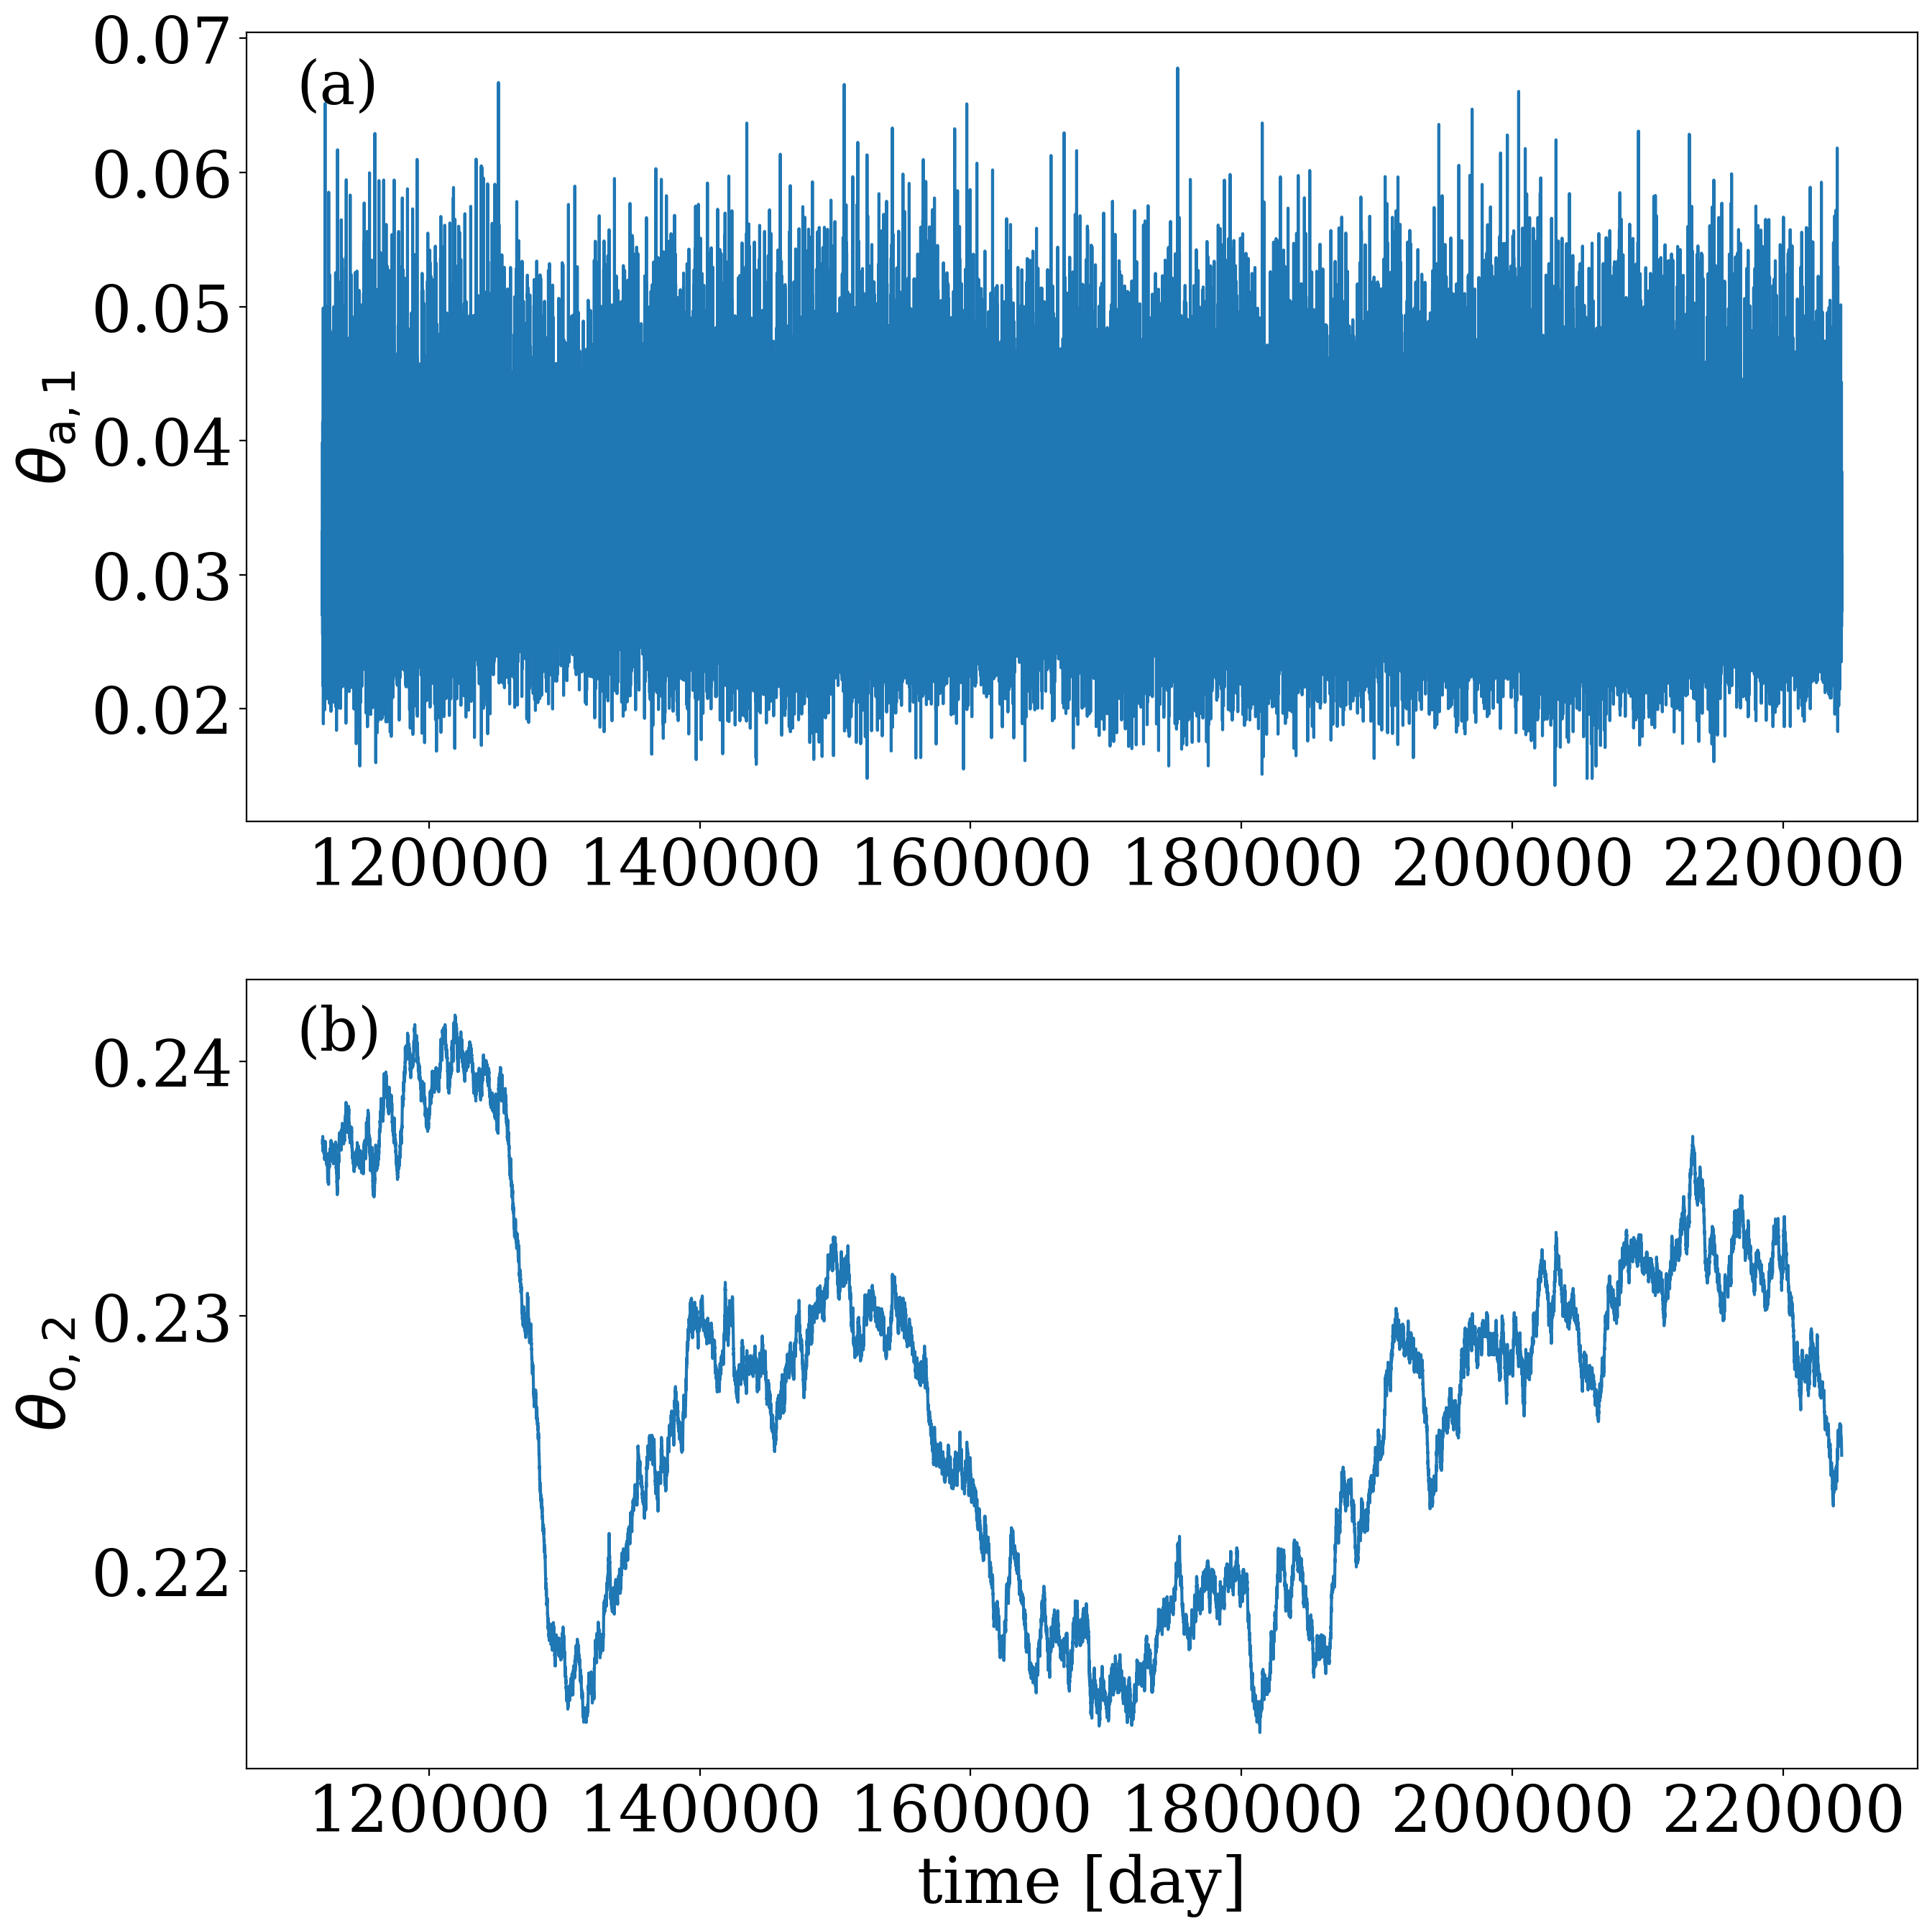

In [36]:
rc('font',**{'family':'serif','sans-serif':['Times'],'size':32})

fig, axs = plt.subplots(nrows=2,ncols=1,figsize=(15,16))

ax = axs[0]
ax.plot(ct*reference_time, reference_traj[10])


ax.set_ylabel(r'$\theta_{{\rm a}, 1}$')
ax.text(0.03, 0.91, '(a)', transform=ax.transAxes, fontsize=30.)
# ax.set_xlabel('time [day]');

ax = axs[1]
ax.plot(ct*reference_time, reference_traj[29])


ax.set_ylabel(r'$\theta_{{\rm o}, 2}$')
ax.text(0.03, 0.91, '(b)', transform=ax.transAxes, fontsize=30.)
ax.set_xlabel('time [day]');

 
plt.savefig('./fig01ab.pdf', bbox_inches='tight')

## Figure 2: Lyapunov spectra

We now show the computed Lyapunov spectra.

First we make a statistical estimation using the [bootstrap method](https://en.wikipedia.org/wiki/Bootstrapping_(statistics)):

In [37]:
%%time
# bootstraping the Lyapunov exponents

number_of_bootstraps = 10000
exponents = local_exponents

bootstraps = np.full_like(exponents, np.nan)
sample_size = exponents.shape[-1]
number_of_bootstraps = min(number_of_bootstraps, sample_size)

for i in range(number_of_bootstraps):
    choices = np.random.randint(0, sample_size, sample_size)
    bootstraps[..., i] = exponents[..., choices].mean(axis=-1)
    
lyapunov_exponents = np.nanmean(bootstraps, axis=-1)
lyapunov_exponents_std = np.nanstd(bootstraps, axis=-1)

del bootstraps
del exponents

CPU times: user 6min 30s, sys: 12.4 ms, total: 6min 30s
Wall time: 6min 32s


Defining the Near-Neutral subspace as the subspace spanned by the unstable and the stable directions for which the Lyapunov exponent $\lambda_i$ is such that $\lambda_i < 10^{-2}$ day$^{-1}$:

In [38]:
near_neutral_index, = np.where(np.abs(lyapunov_exponents/ct)<1.e-2)

Printing the exponents:

In [39]:
lyapunov_exponents/ct

array([ 3.66198350e-01,  1.38103667e-01,  3.74746284e-02,  7.27270507e-04,
        3.47536123e-04,  7.84896229e-05,  8.51431774e-05,  9.00433054e-05,
        5.17764038e-05,  3.92018208e-05, -1.10415798e-04, -4.22064201e-04,
       -1.99705820e-03, -2.79938403e-03, -3.09236900e-03, -3.07341795e-03,
       -3.12059997e-03, -3.24733273e-03, -3.53217302e-03, -3.95618692e-03,
       -1.64429436e-02, -6.00863151e-02, -9.31212518e-02, -1.25465505e-01,
       -1.55108344e-01, -1.84097173e-01, -2.09618128e-01, -2.33985870e-01,
       -2.57965516e-01, -2.79630210e-01, -3.04860547e-01, -3.29375711e-01,
       -3.58323082e-01, -3.90094152e-01, -4.31665031e-01, -5.10592675e-01])

Plotting the spectrum:

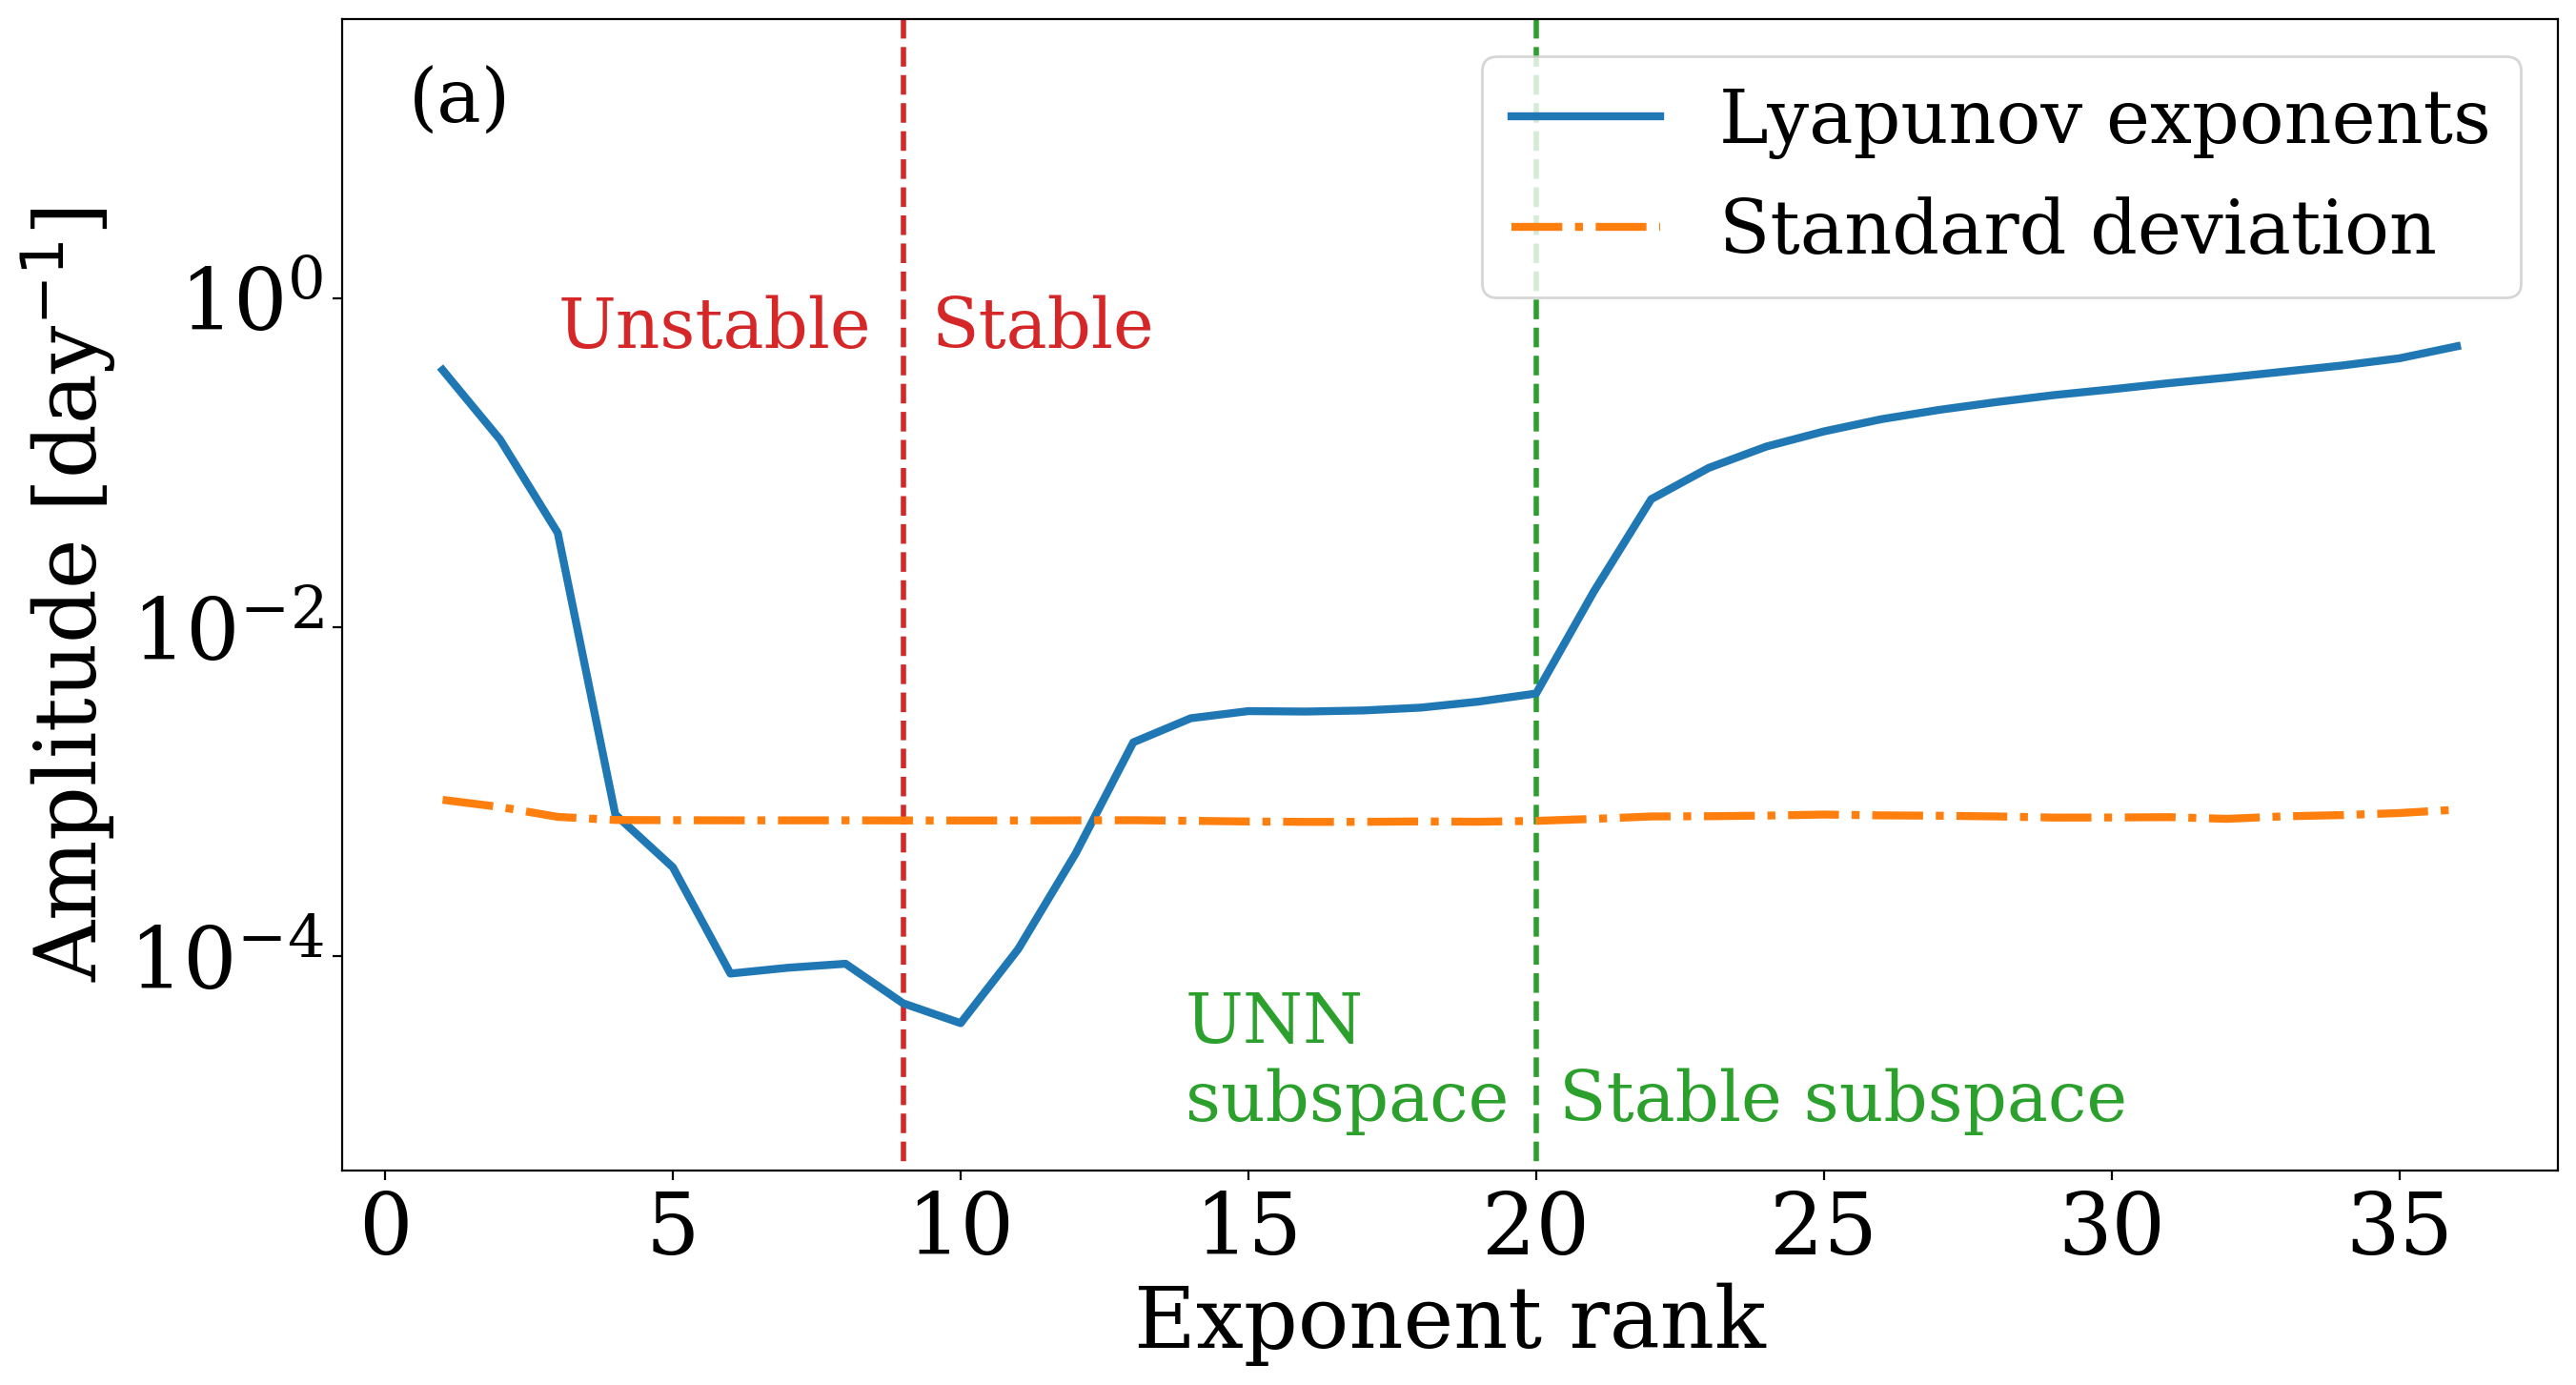

In [40]:
fig = plt.figure(figsize=(15,8))

ax = fig.gca()

ax.semilogy(range(1, len(lyapunov_exponents)+1), np.abs(lyapunov_exponents/ct), label='Lyapunov exponents', lw=3.)
ax.semilogy(range(1, len(lyapunov_exponents_std)+1), lyapunov_exponents_std/ct, label='Standard deviation', lw=3., ls='-.')
ax.set_ylim(5.e-6,50.)

ax.set_xlabel('Exponent rank')
ax.set_ylabel('Amplitude [day$^{-1}$]')
ax.text(0.03, 0.91, '(a)', transform=ax.transAxes, fontsize=28.)

ax.vlines(9.,1.e-9,60., colors='tab:red', linestyles='dashed', lw=2.)
ax.text(3., 0.5, 'Unstable', fontsize=26., color='tab:red')
ax.text(9.5, 0.5, 'Stable', fontsize=26., color='tab:red')

ax.vlines(near_neutral_index[-1]+1,1.e-9,60., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 1.e-5, 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 1.e-5, 'Stable subspace', fontsize=26., color='tab:green')

ax.legend(fontsize=28., loc='upper right')

# ax.set_title('Lyapunov exponents');
 
plt.savefig('./fig02a.pdf', bbox_inches='tight')


## Figure 5: EOF analysis

The EOFs can be obtained by considering the covariance matrix and its orthogonal eigenvectors. The eigenvalues of this matrix are related to the variance of the data projected onto the corresponding mode. The amplitude of the eigenvalues comparatively to the others then provide the *fraction of explained variance* by a given EOF.

In [41]:
cov_mat = np.cov(reference_traj)

In [42]:
eig, eof = np.linalg.eig(cov_mat)
arg = np.argsort(eig)
eig = eig[arg][::-1]
eof = eof[:, arg][:,::-1]

In [43]:
explained_variance = np.array([100*v/np.trace(cov_mat) for v in eig])

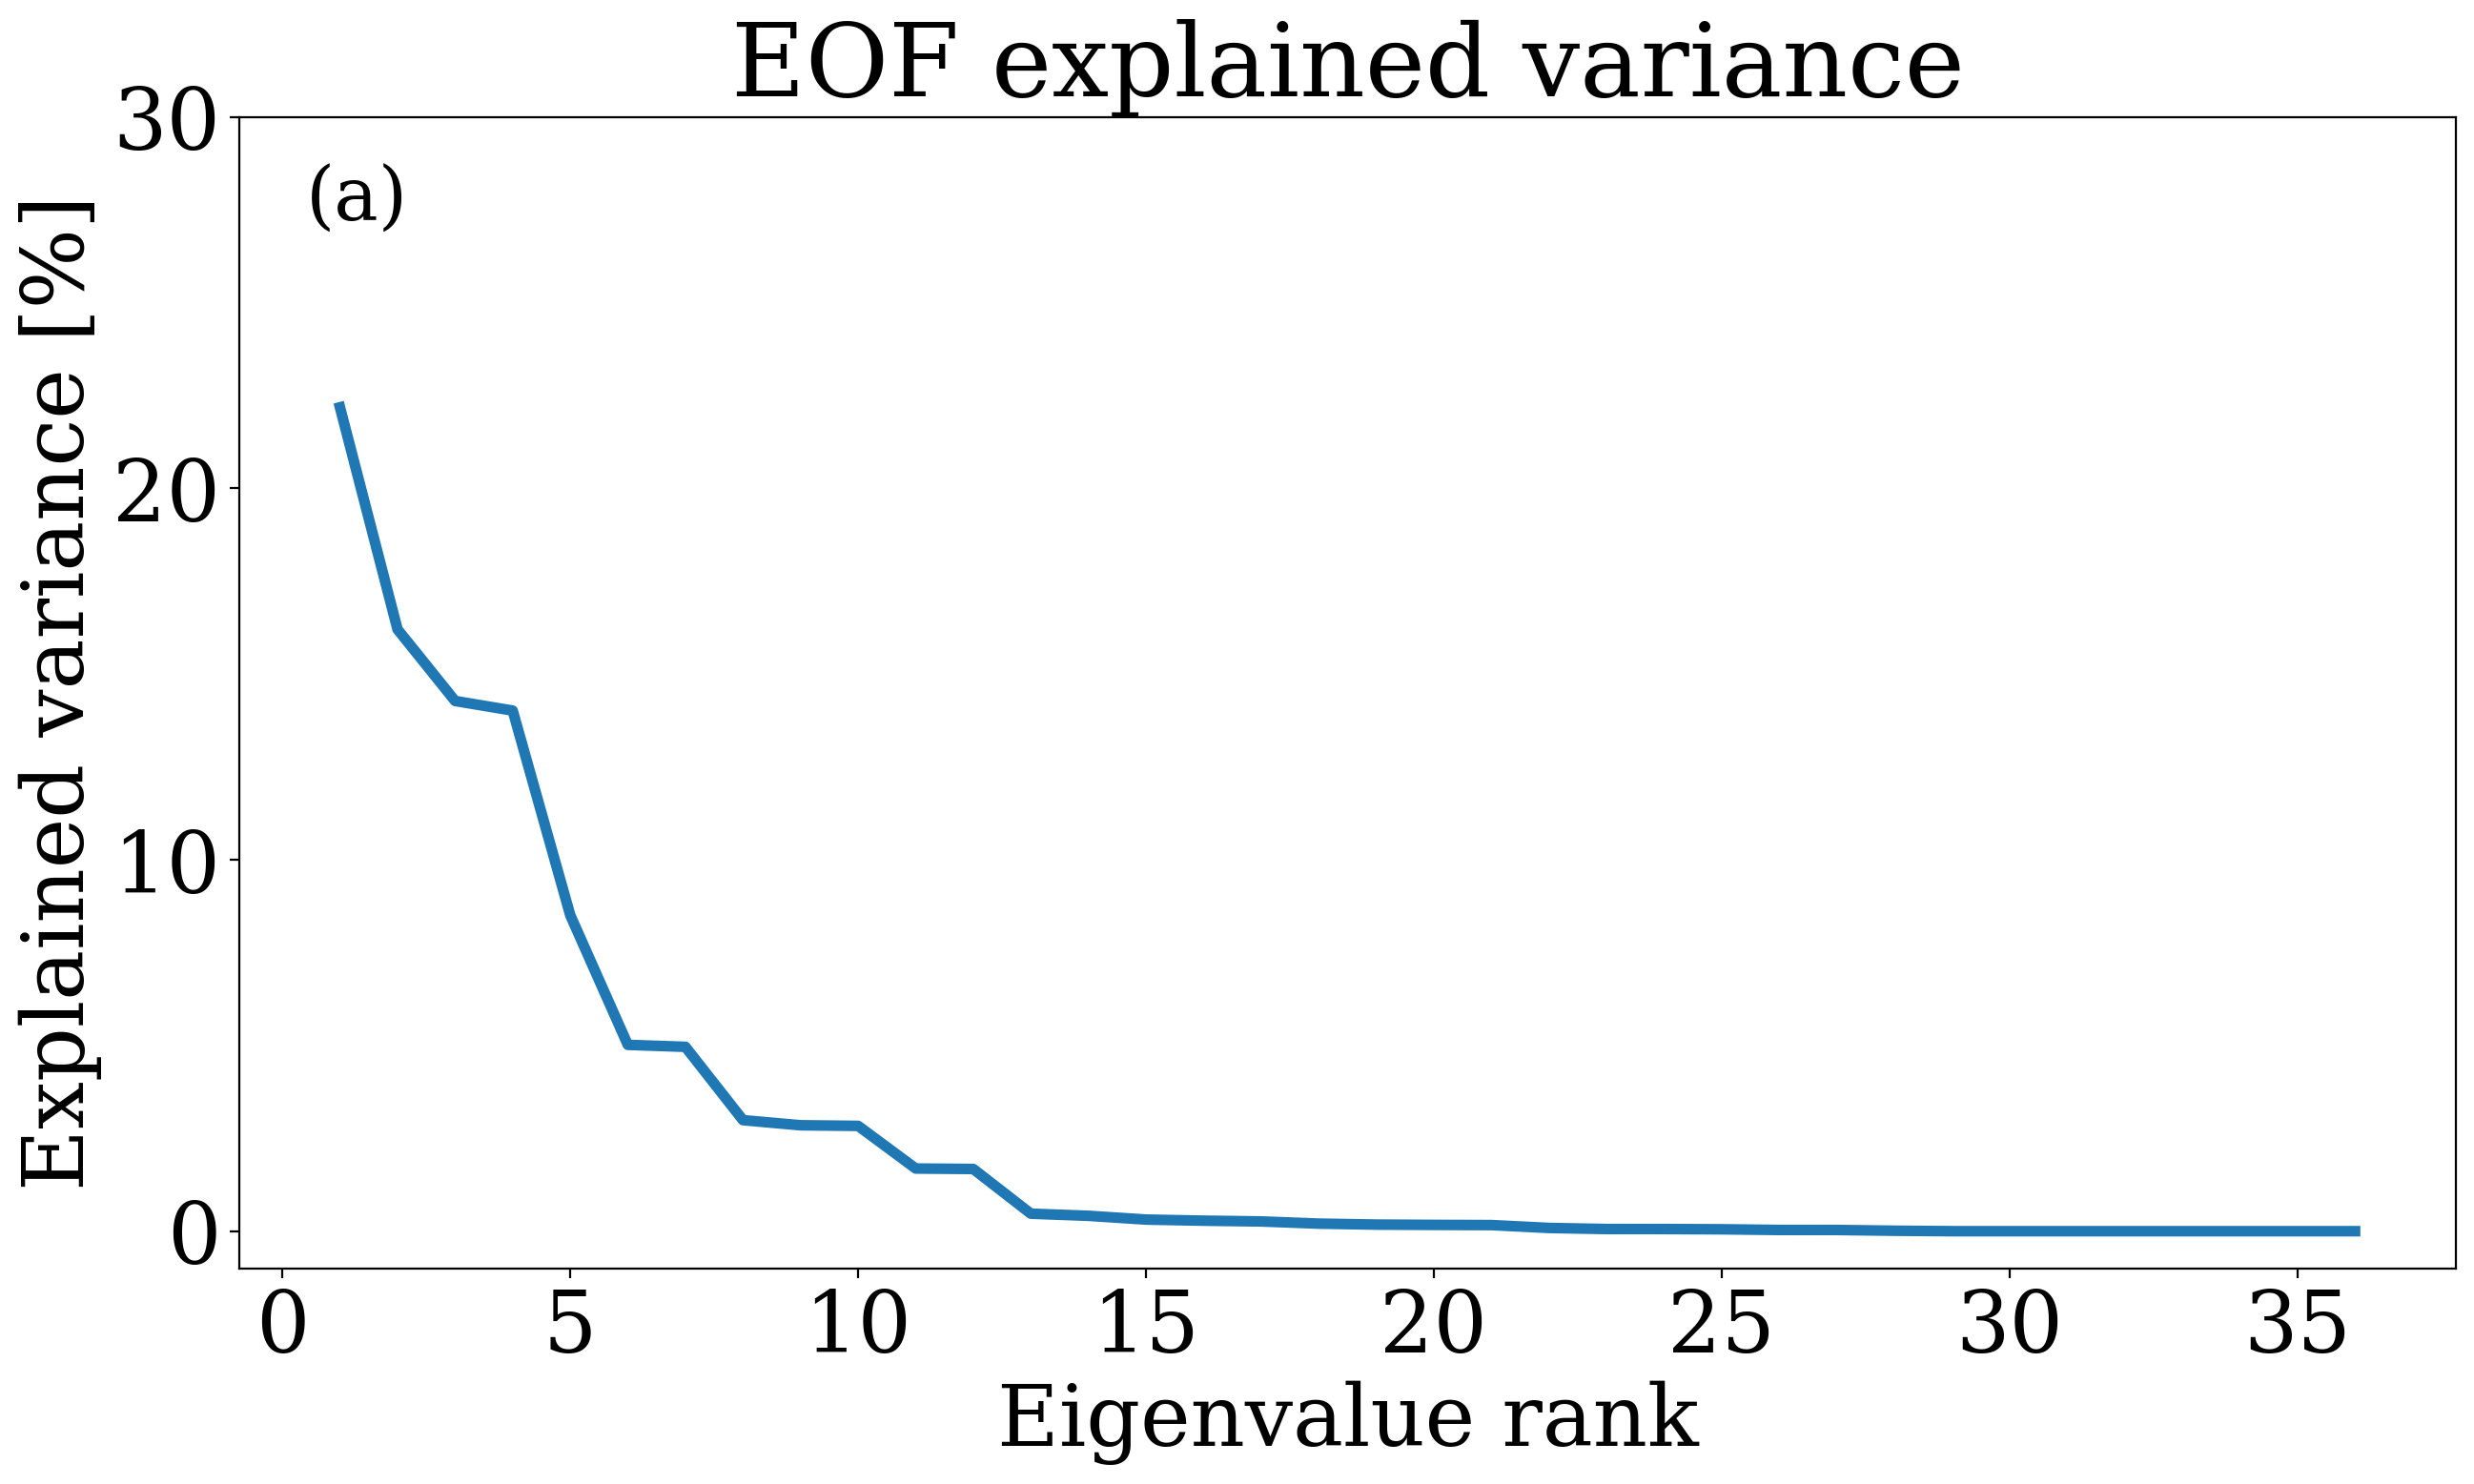

In [44]:
fig = plt.figure(figsize=(15,8))

ax = fig.gca()
v = explained_variance
ax.plot(range(1, len(v)+1), v, label='Explained variance', lw=4.)
# ax.plot(range(1, len(v)+1), np.cumsum(v), label='Cumulative explained variance')

ax.set_ylim(-1,30)

ax.set_xlabel('Eigenvalue rank')
ax.set_ylabel('Explained variance [%]')
ax.text(0.03, 0.91, '(a)', transform=ax.transAxes, fontsize=28.)

# ax.legend(fontsize=28.)

ax.set_title('EOF explained variance');

 
plt.savefig('./fig05a.pdf', bbox_inches='tight')

## DMD analysis

We use the method based on the SVD to compute the DMD associated to the reference trajectory.

### Figure 3: Computing the classic DMD

First we define the snapshot pairs $\mathsf{X}$ and $\mathsf{Y}$:

In [45]:
X = reference_traj[:,:-1]
Y = reference_traj[:,1:]

First compute the SVD decomposition

In [46]:
U,S,Vh = np.linalg.svd(X, full_matrices=False)

In [47]:
B = Y @ np.transpose(Vh) @ np.diag(np.reciprocal(S))

Compute the reduced operator $\tilde{\mathsf{M}}^{\rm DMD}$ and its eigenvalues:

In [48]:
Mt = np.transpose(U) @ B

In [49]:
eigs, v = np.linalg.eig(Mt)

In [50]:
eigs = eigs[::-1]
v = v[:,::-1]

Plotting the eigenvalues

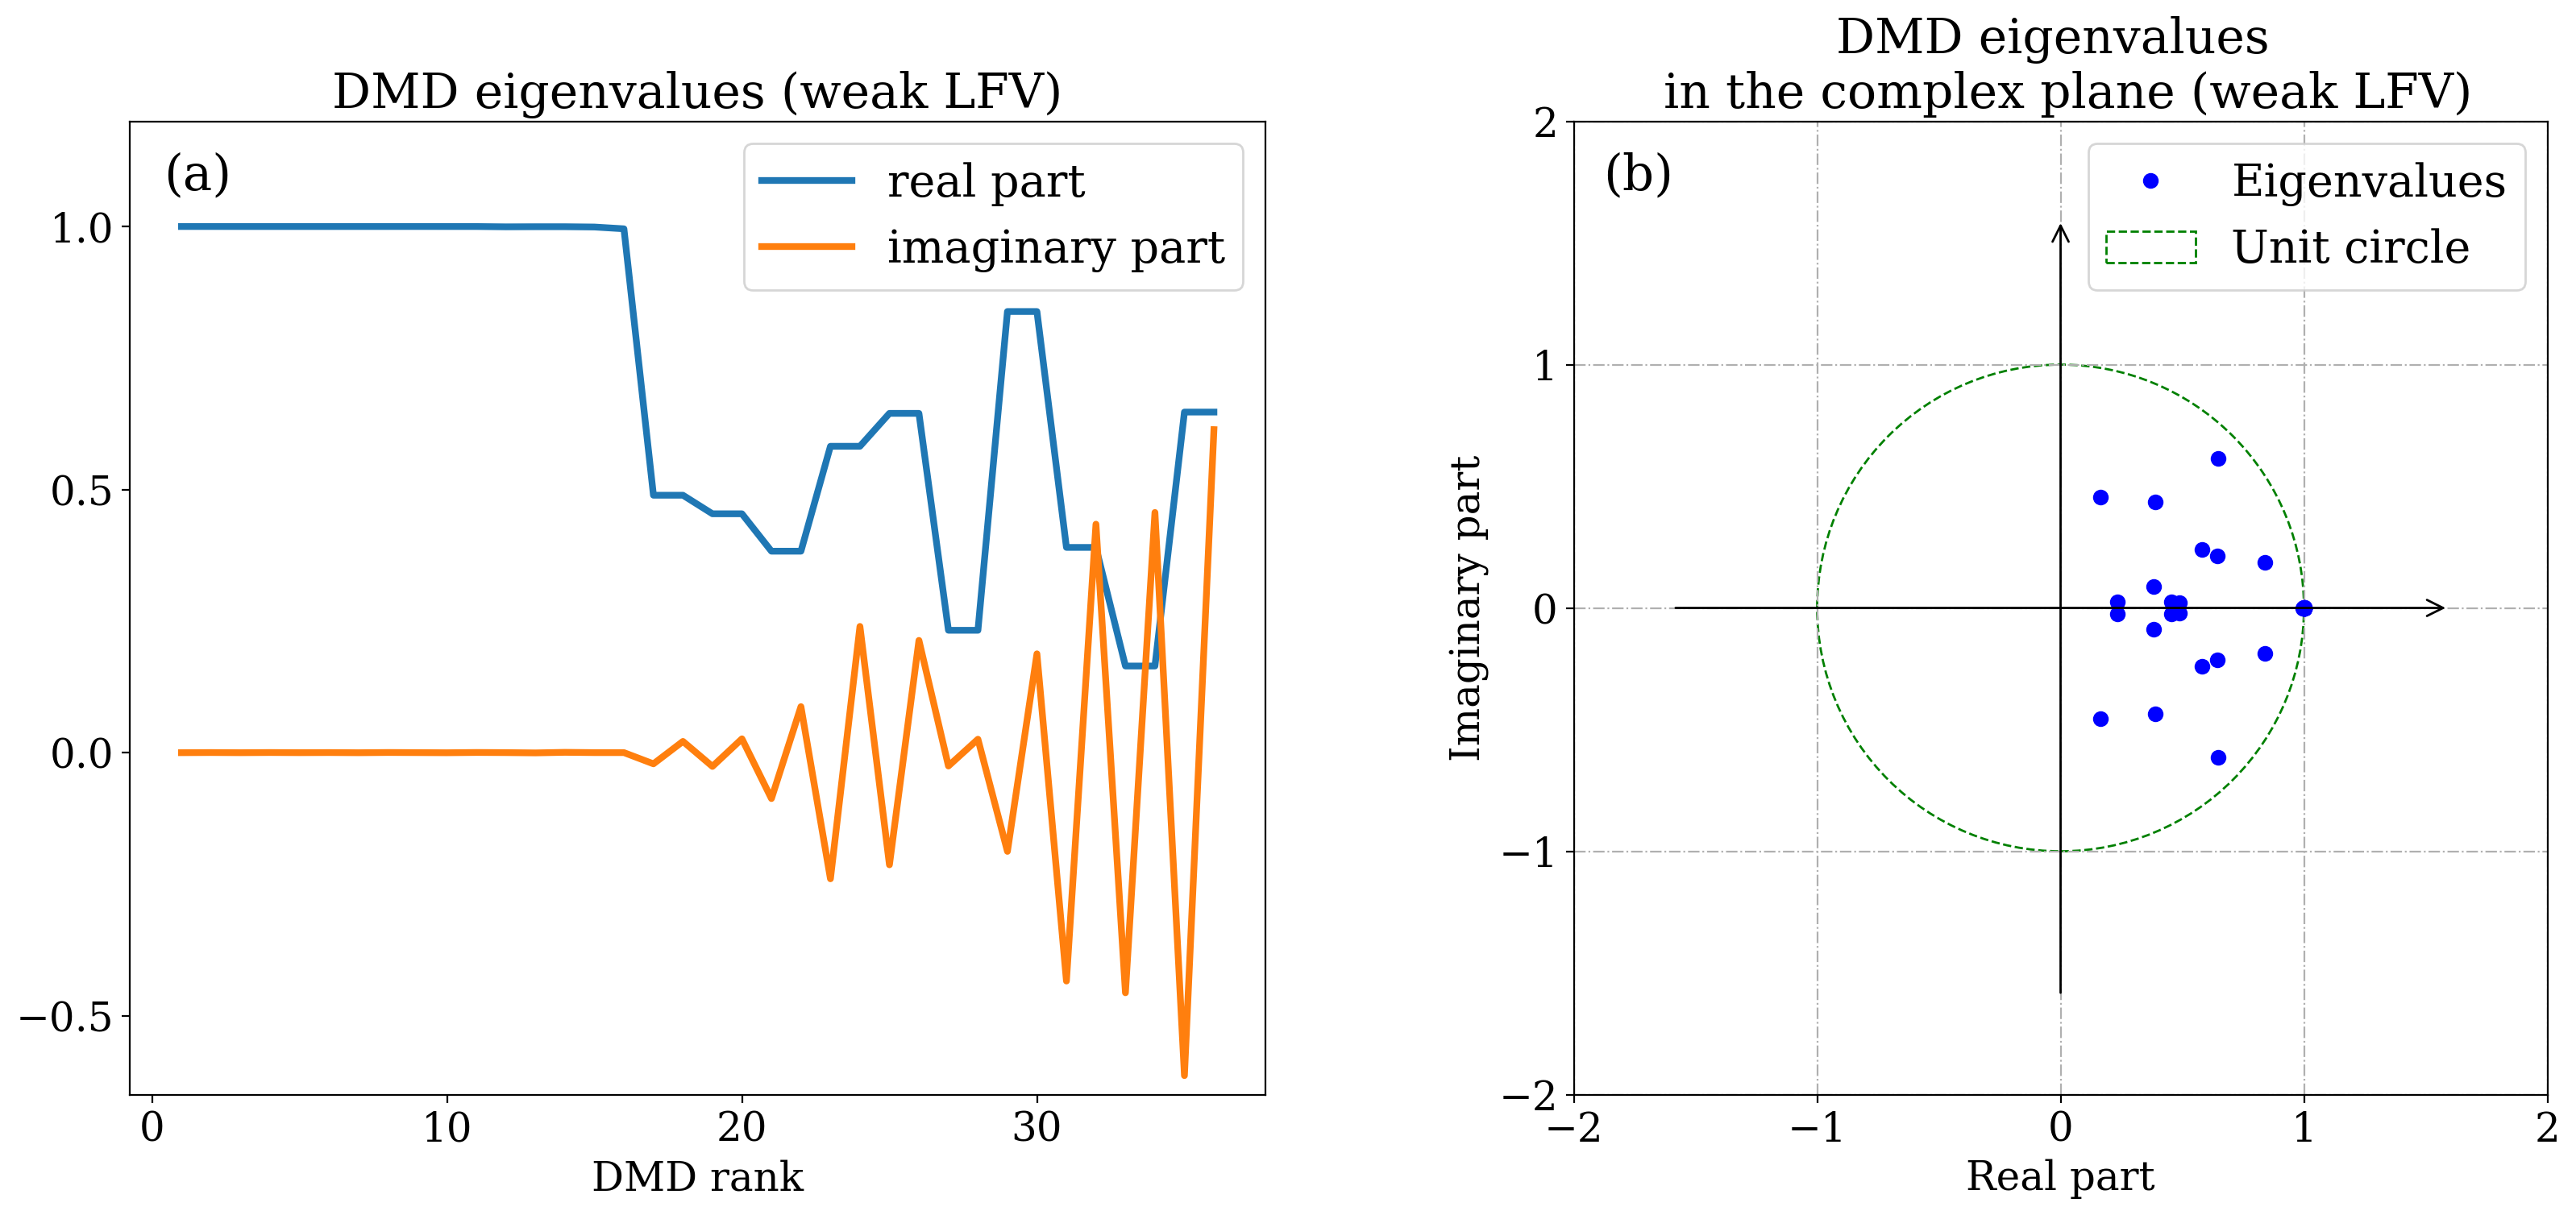

In [124]:
rc('font',**{'family':'serif','sans-serif':['Times'],'size':18})

# dmd = dmd_list 

fig, axl = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axl = axl.flatten()

axl[0].plot(range(1, len(eigs.real)+1), eigs.real, label='real part', lw=3.)
axl[0].plot(range(1, len(eigs.imag)+1), eigs.imag, label='imaginary part', lw=3.)
axl[0].text(0.03, 0.93, '(a)', transform=axl[0].transAxes, fontsize=22.);
axl[0].set_ylim(-0.65, 1.2)

axl[0].set_xlabel('DMD rank')

axl[0].legend(fontsize=20.)

axl[0].set_title('DMD eigenvalues (weak LFV)')



points, = axl[1].plot(eigs.real, eigs.imag, 'bo', label='Eigenvalues')

# set limits for axis
limit = max([np.max(np.ceil(np.absolute(eigs))), 2.])
axl[1].set_xlim((-limit, limit))
axl[1].set_ylim((-limit, limit))

axl[1].set_ylabel('Imaginary part')
axl[1].set_xlabel('Real part')

unit_circle = plt.Circle(
                (0., 0.),
                1.,
                color='green',
                fill=False,
                label='Unit circle',
                linestyle='--')
axl[1].add_artist(unit_circle)

# Dashed grid
gridlines = axl[1].get_xgridlines() + axl[1].get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')
axl[1].grid(True)

axl[1].set_aspect('equal')

# x and y axes
axl[1].annotate('',
                xy=(np.max([limit * 0.8, 1.]), 0.),
                xytext=(np.min([-limit * 0.8, -1.]), 0.),
                arrowprops=dict(arrowstyle="->"))
axl[1].annotate('',
                xy=(0., np.max([limit * 0.8, 1.])),
                xytext=(0., np.min([-limit * 0.8, -1.])),
                arrowprops=dict(arrowstyle="->"))

# legend
axl[1].legend([points, unit_circle], ['Eigenvalues', 'Unit circle'], loc=1, fontsize=20.)
axl[1].set_title('DMD eigenvalues \n in the complex plane (weak LFV)');
axl[1].text(0.03, 0.93, '(b)', transform=axl[1].transAxes, fontsize=22.);

 
plt.savefig('./fig03ab.pdf', bbox_inches='tight')

rc('font',**{'family':'serif','sans-serif':['Times'],'size':28})

Compute the DMD $\boldsymbol{v}_i$ and the Adjoint DMD $\boldsymbol{w}_i$

In [52]:
# computing the exact DMDs
dmd = (B @ (v * np.reciprocal(eigs)))

In [53]:
# computing the adjoint DMDs
w = np.linalg.inv(v).T
addmd = U @ w

Checking the biorthonormality relationship $\boldsymbol{v}_i \cdot \boldsymbol{w}_j = \delta_{i,j}$

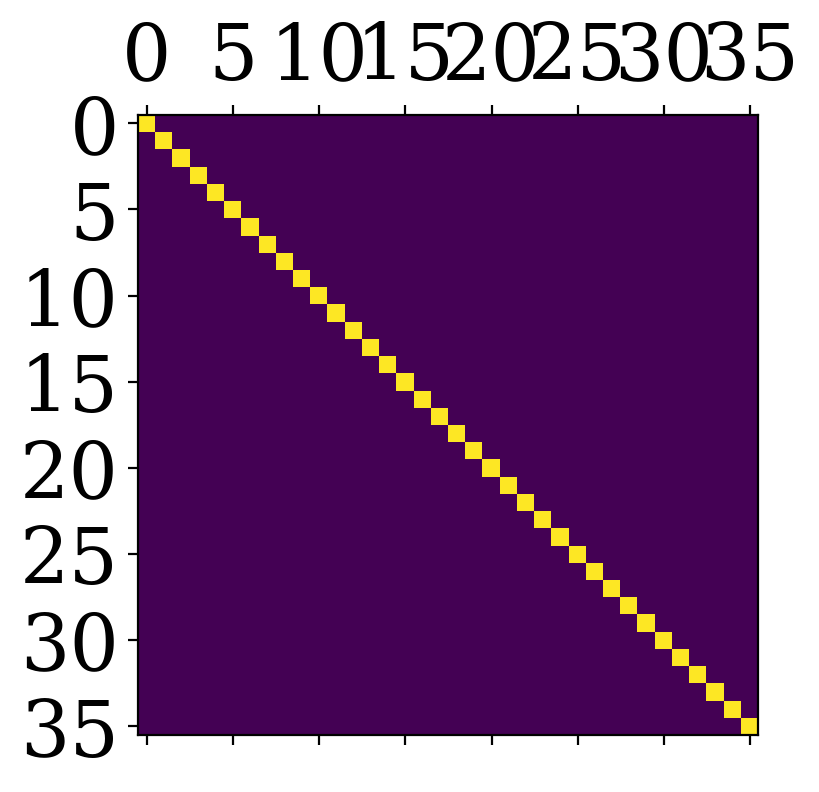

In [54]:
plt.matshow(np.real(addmd.T @ dmd))
 

Computing real-complex decompositions of (adjoint) DMD modes

In [55]:
### DMD ###
# Real/complex decomposition
dmd_modes_r = dmd.real
dmd_modes_i = dmd.imag

# Normalized
dmd_modes_r_norm = dmd_modes_r/np.sqrt((dmd_modes_r**2).sum(axis=0))
dmd_modes_i_norm = dmd_modes_i/np.sqrt((dmd_modes_i**2).sum(axis=0))

# Unfolding complex-conjugate pairs
dmd_modes = np.zeros_like(dmd_modes_r)
dmd_modes[:,::2] = dmd_modes_r[:,::2]
dmd_modes[:,1::2] = dmd_modes_i[:,1::2]
# Dealing with purely real modes
for i in range(dmd_modes.shape[1]):
    if np.all(dmd_modes[:,i]==0):
        dmd_modes[:,i] = dmd_modes_r[:,i]

# Normalized
dmd_modes_norm = dmd_modes/np.sqrt((dmd_modes**2).sum(axis=0))

### Adjoint DMD ###
# Real/complex decomposition
addmd_modes_r = addmd.real
addmd_modes_i = addmd.imag

# Normalized
addmd_modes_r_norm = addmd_modes_r/np.sqrt((addmd_modes_r**2).sum(axis=0))
addmd_modes_i_norm = addmd_modes_i/np.sqrt((addmd_modes_i**2).sum(axis=0))

# Unfolding complex-conjugate pairs
addmd_modes = np.zeros_like(addmd_modes_r)
addmd_modes[:,::2] = addmd_modes_r[:,::2]
addmd_modes[:,1::2] = addmd_modes_i[:,1::2]

# Dealing with purely real modes
for i in range(addmd_modes.shape[1]):
    if np.sqrt((addmd_modes[:,i]**2).sum()) < 1.e-7:
        addmd_modes[:,i] = addmd_modes_r[:,i]

# Normalized
addmd_modes_norm = addmd_modes/np.sqrt((addmd_modes**2).sum(axis=0))


<ipython-input-55-96839b647551>:8: RuntimeWarning: invalid value encountered in true_divide
  dmd_modes_i_norm = dmd_modes_i/np.sqrt((dmd_modes_i**2).sum(axis=0))


### Supplementary figure : Computing the Perron-Frobenius Decomposition

First compute the matrix

In [56]:
Ad = reference_traj[:,1:] @ reference_traj[:,:-1].T
G = reference_traj[:,:-1] @ reference_traj[:,:-1].T

In [57]:
P = Ad.T @ np.linalg.pinv(G)

and find the eigenvectors and eigenvalues:

In [58]:
peigs, pfd = np.linalg.eig(P.T)

In [59]:
peigs = peigs[::-1]
pfd = pfd[:,::-1]

Plotting the eigenvalues

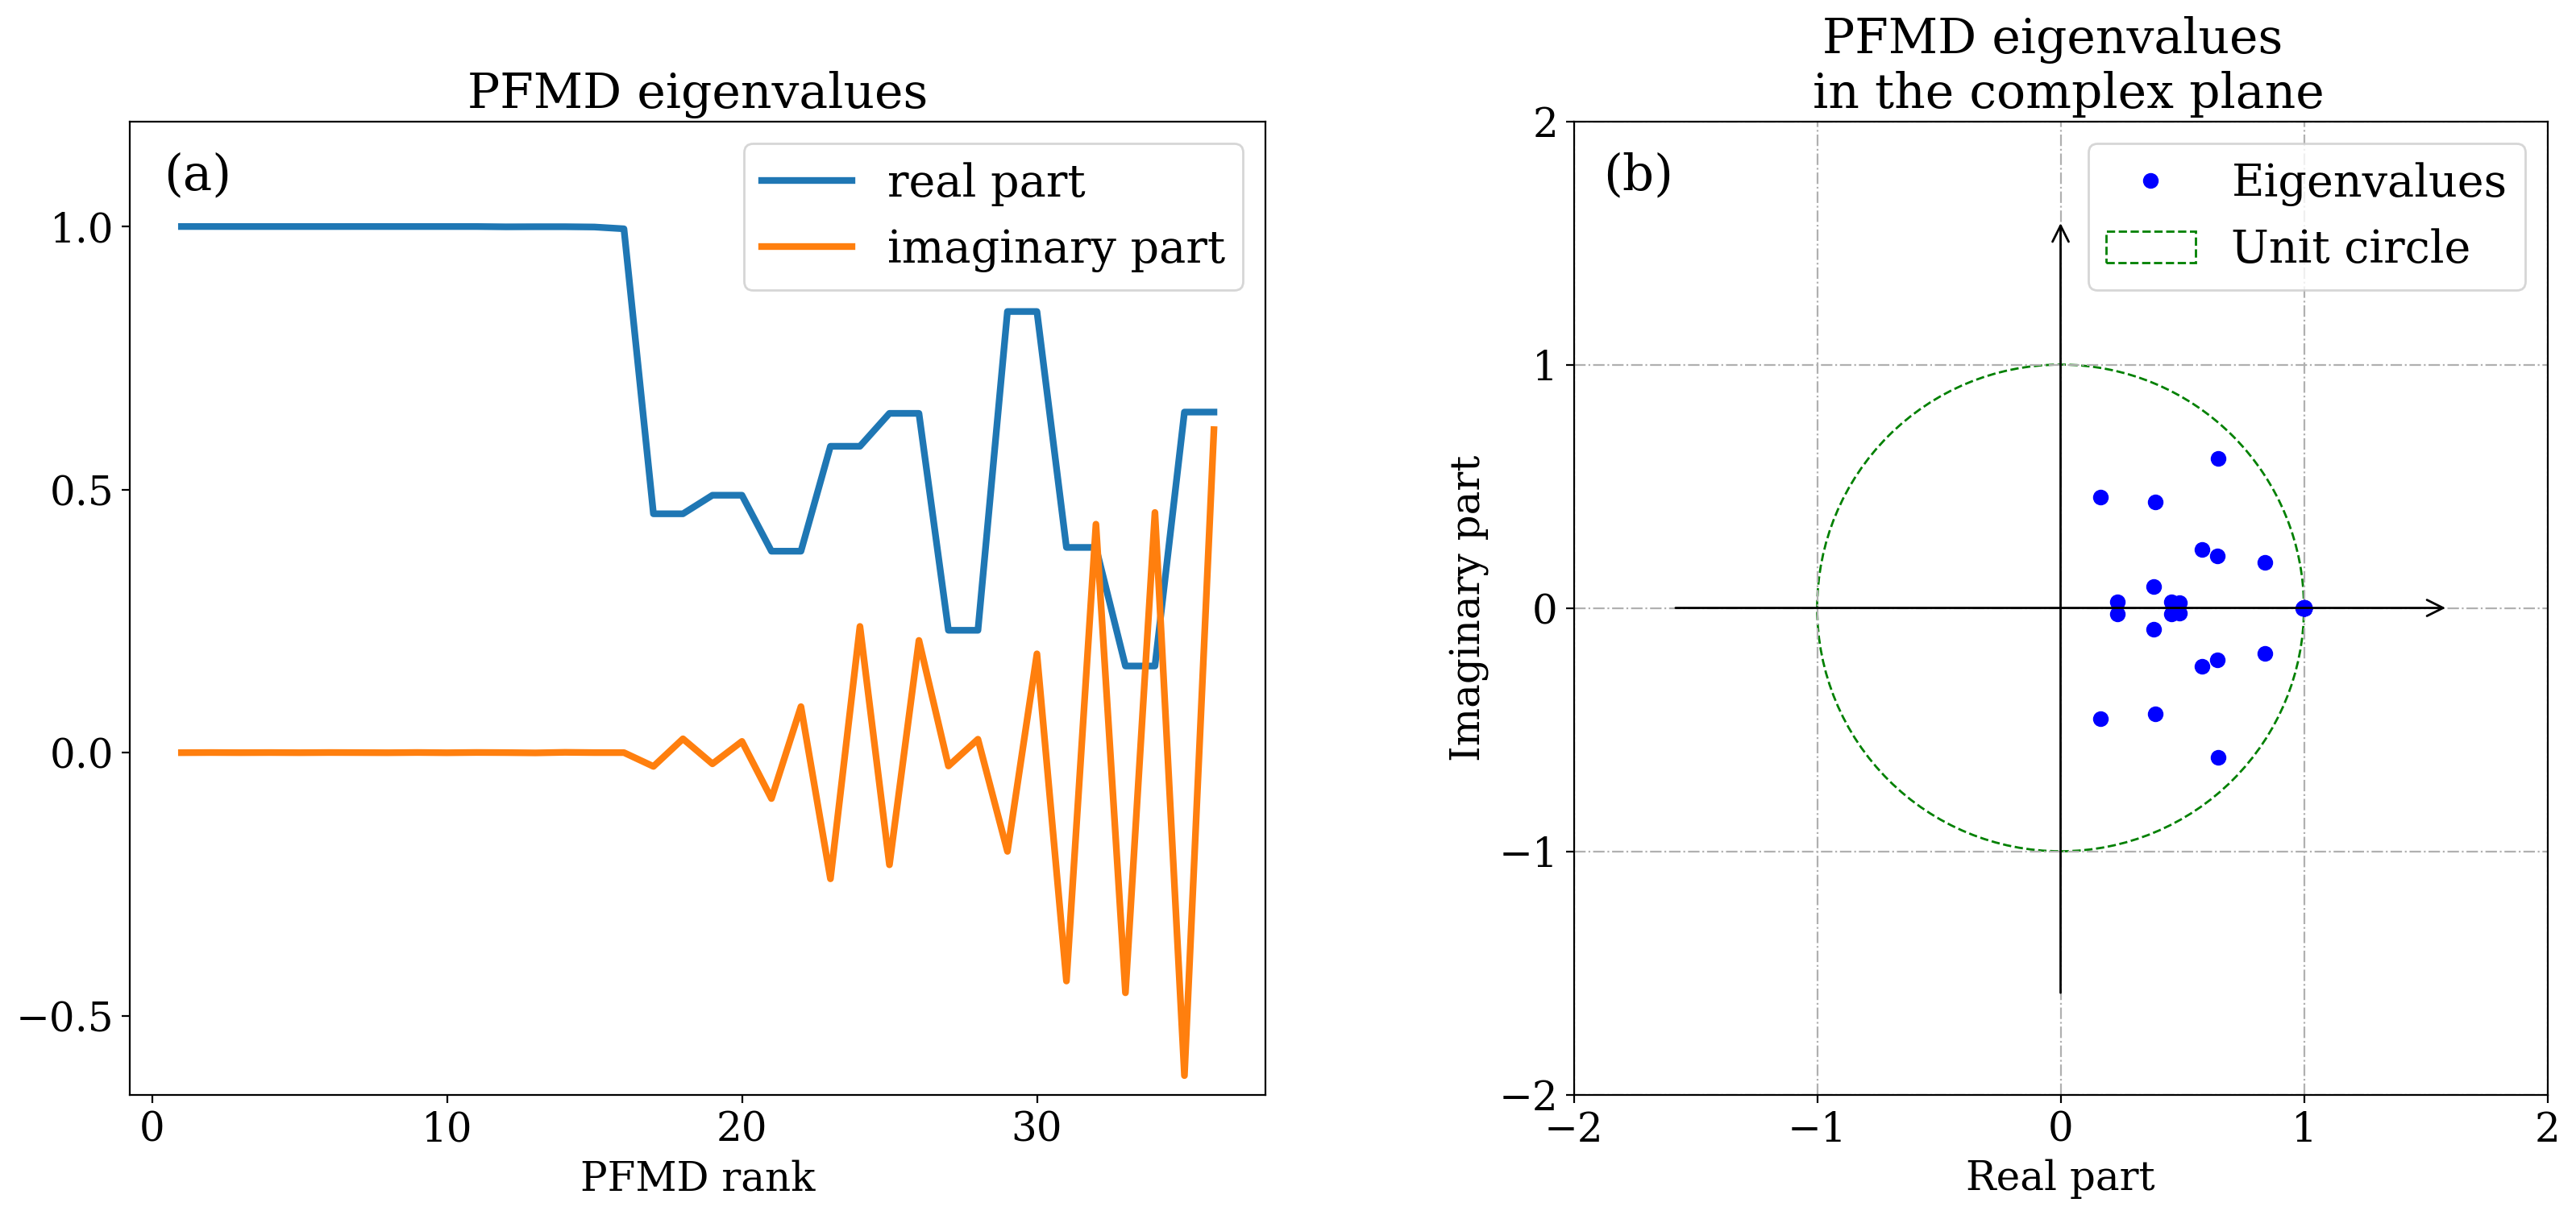

In [60]:
rc('font',**{'family':'serif','sans-serif':['Times'],'size':18})

# dmd = dmd_list 

fig, axl = plt.subplots(nrows=1, ncols=2, figsize=(20,8))

axl = axl.flatten()

axl[0].plot(range(1, len(peigs.real)+1), peigs.real, label='real part', lw=3.)
axl[0].plot(range(1, len(peigs.imag)+1), peigs.imag, label='imaginary part', lw=3.)
axl[0].text(0.03, 0.93, '(a)', transform=axl[0].transAxes, fontsize=22.);
axl[0].set_ylim(-0.65, 1.2)

axl[0].set_xlabel('PFMD rank')

axl[0].legend(fontsize=20.)

axl[0].set_title('PFMD eigenvalues')



points, = axl[1].plot(peigs.real, peigs.imag, 'bo', label='Eigenvalues')

# set limits for axis
limit = max([np.max(np.ceil(np.absolute(eigs))), 2.])
axl[1].set_xlim((-limit, limit))
axl[1].set_ylim((-limit, limit))

axl[1].set_ylabel('Imaginary part')
axl[1].set_xlabel('Real part')

unit_circle = plt.Circle(
                (0., 0.),
                1.,
                color='green',
                fill=False,
                label='Unit circle',
                linestyle='--')
axl[1].add_artist(unit_circle)

# Dashed grid
gridlines = axl[1].get_xgridlines() + axl[1].get_ygridlines()
for line in gridlines:
    line.set_linestyle('-.')
axl[1].grid(True)

axl[1].set_aspect('equal')

# x and y axes
axl[1].annotate('',
                xy=(np.max([limit * 0.8, 1.]), 0.),
                xytext=(np.min([-limit * 0.8, -1.]), 0.),
                arrowprops=dict(arrowstyle="->"))
axl[1].annotate('',
                xy=(0., np.max([limit * 0.8, 1.])),
                xytext=(0., np.min([-limit * 0.8, -1.])),
                arrowprops=dict(arrowstyle="->"))

# legend
axl[1].legend([points, unit_circle], ['Eigenvalues', 'Unit circle'], loc=1, fontsize=20.)
axl[1].set_title('PFMD eigenvalues \n in the complex plane');
axl[1].text(0.03, 0.93, '(b)', transform=axl[1].transAxes, fontsize=22.);

 
plt.savefig('./fig_supp_PFMDspectr_noLFV.pdf', bbox_inches='tight')

rc('font',**{'family':'serif','sans-serif':['Times'],'size':28})

Computing real-complex decomposition of the PFMD modes

In [61]:
pfd_modes_r = pfd.real
pfd_modes_i = pfd.imag
pfd_modes_r_norm = pfd_modes_r/np.sqrt((pfd_modes_r**2).sum(axis=0))
pfd_modes_i_norm = pfd_modes_i/np.sqrt((pfd_modes_i**2).sum(axis=0))
pfd_modes = np.zeros_like(pfd_modes_r)
pfd_modes[:,::2] = pfd_modes_r[:,::2]
pfd_modes[:,1::2] = pfd_modes_i[:,1::2]

for i in range(pfd_modes.shape[1]):
    if np.sqrt((pfd_modes[:,i]**2).sum()) < 1.e-7:
        pfd_modes[:,i] = pfd_modes_r[:,i]

pfd_modes_norm = pfd_modes/np.sqrt((pfd_modes**2).sum(axis=0))

<ipython-input-61-a1d01f9f60bc>:4: RuntimeWarning: invalid value encountered in true_divide
  pfd_modes_i_norm = pfd_modes_i/np.sqrt((pfd_modes_i**2).sum(axis=0))


## Figure 4 : Plotting the various vector components

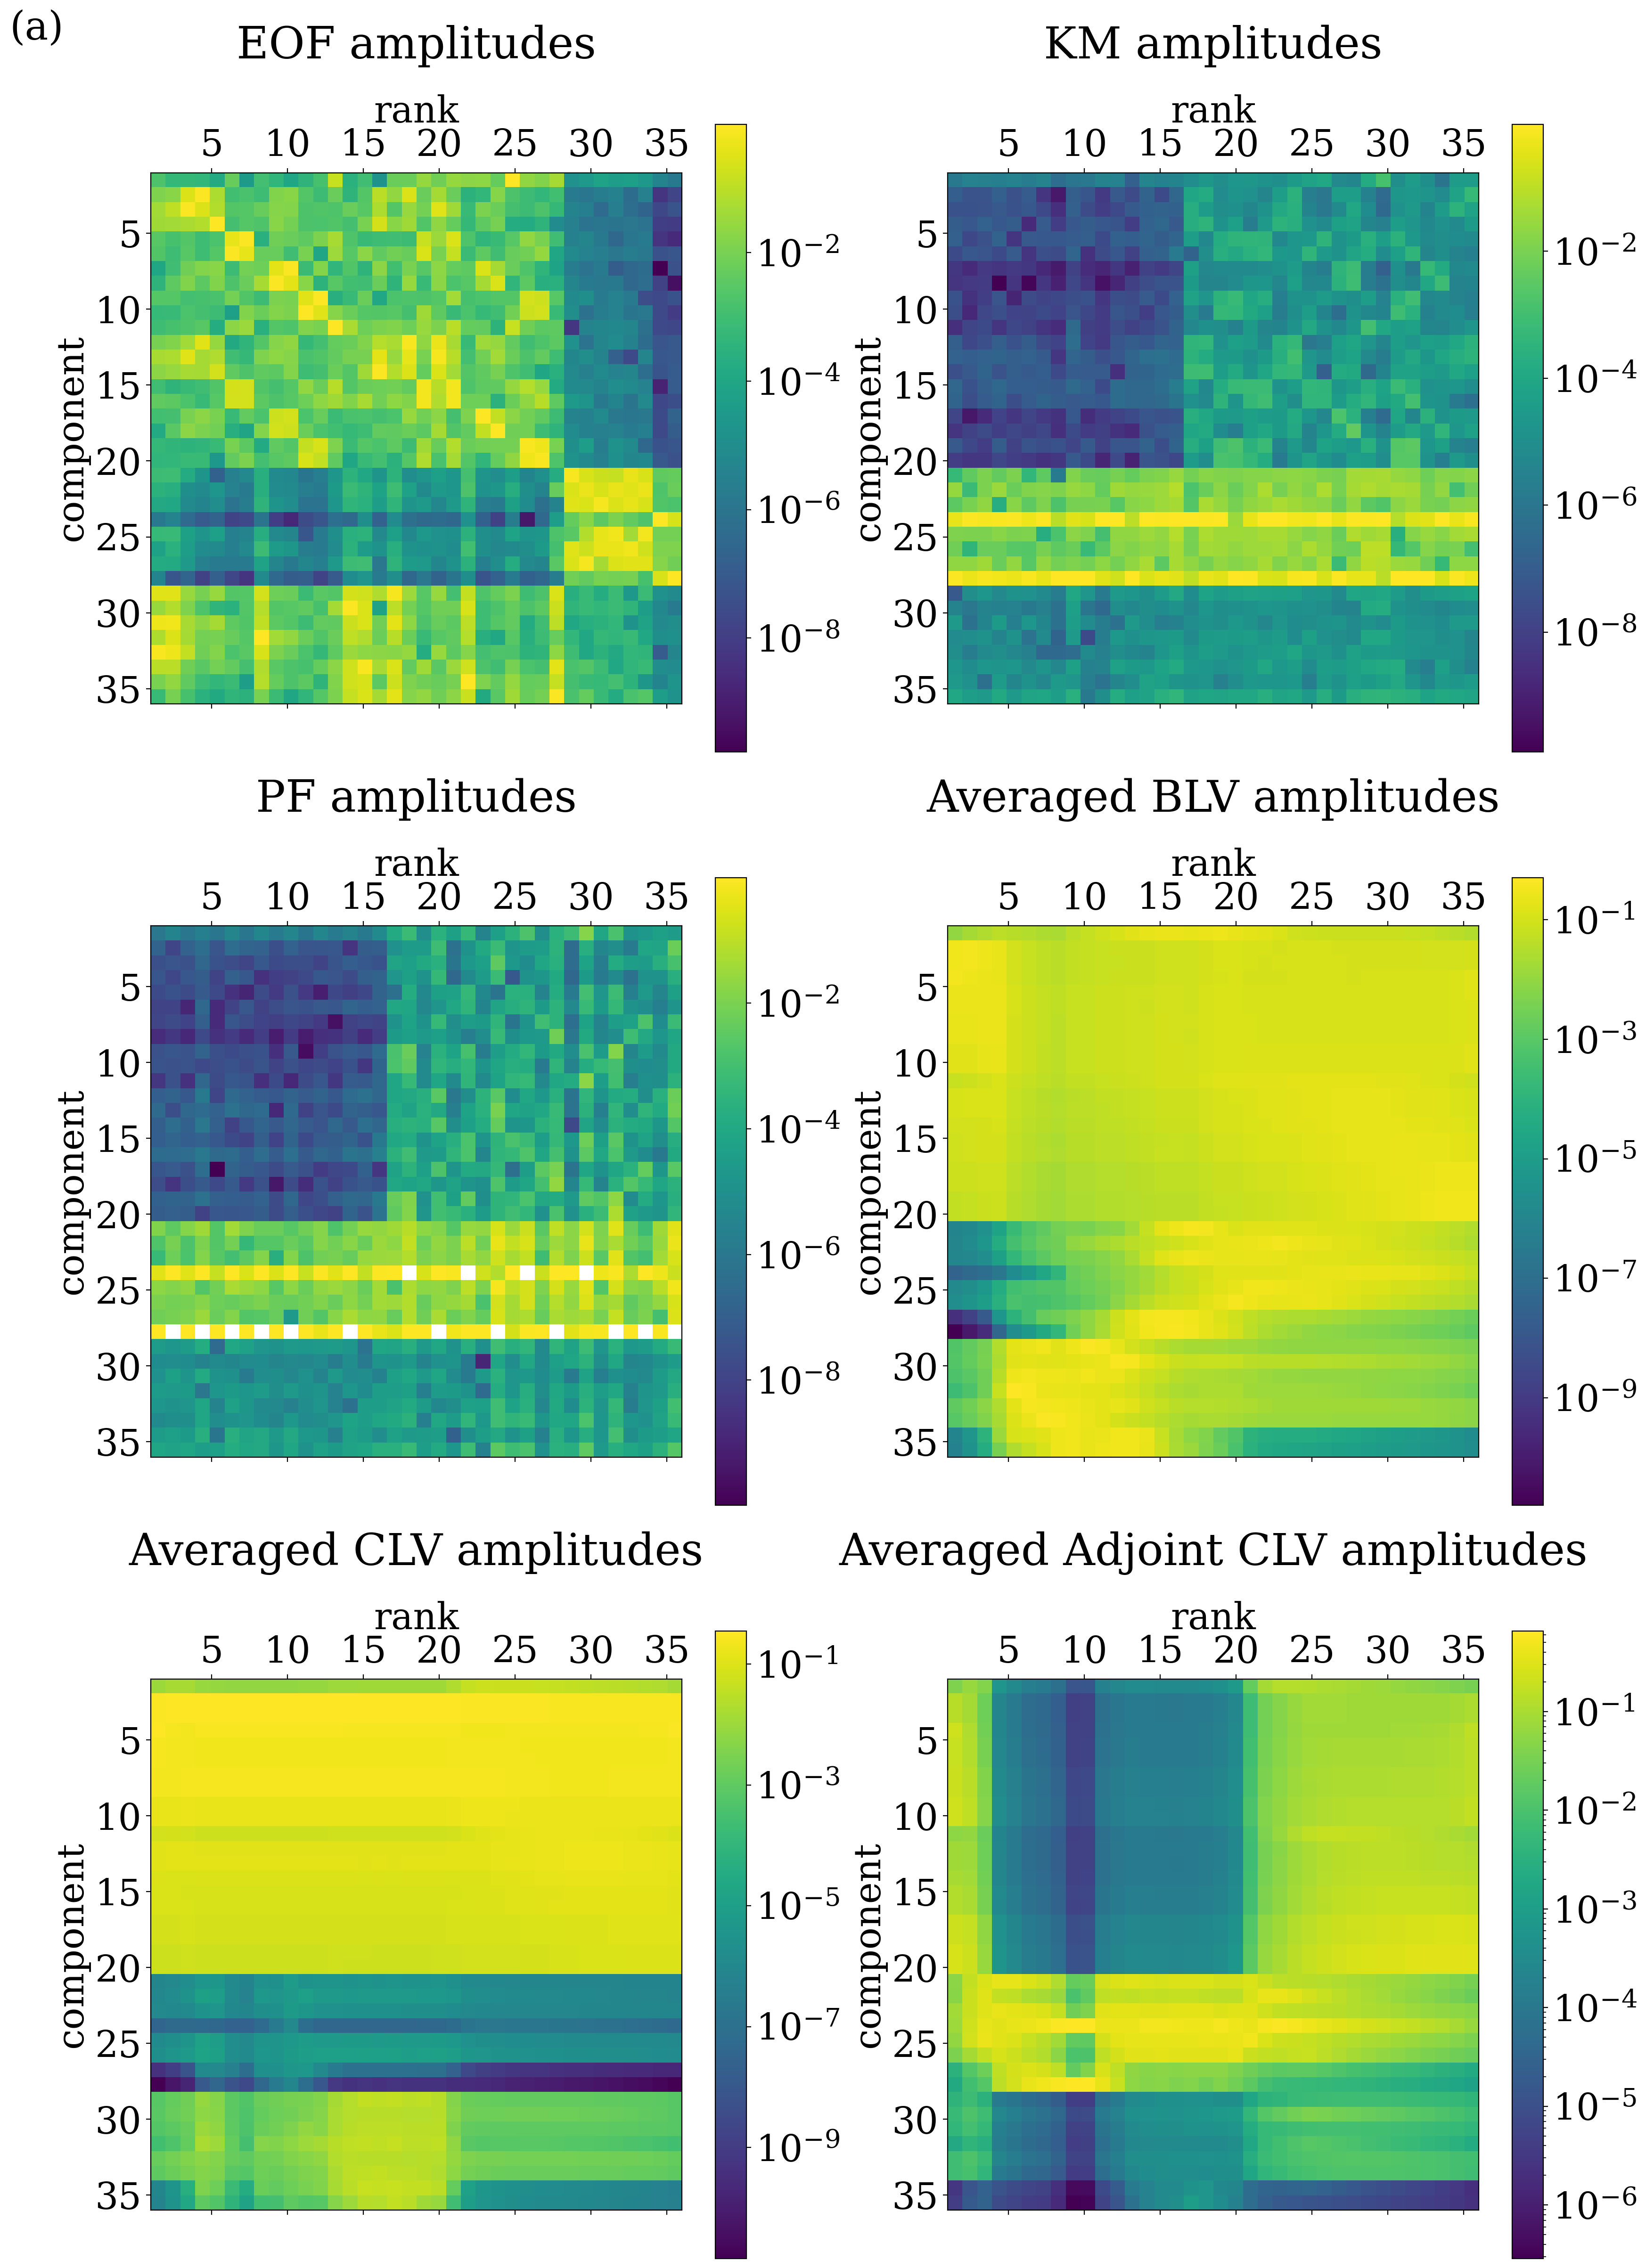

In [62]:
fig, axl = plt.subplots(nrows=3,ncols=2,figsize=(20,30))

axl = axl.flatten()

im = axl[0].matshow(np.abs(eof), norm=colors.LogNorm(), extent=(1, dmd_modes.shape[1], dmd_modes.shape[0], 1))
plt.colorbar(im, ax=axl[0])

axl[0].set_ylabel('component')
axl[0].set_xlabel('rank')
axl[0].xaxis.set_label_position('top') 
axl[0].set_title('EOF amplitudes', y=1.2);

im = axl[1].matshow(np.abs(addmd_modes_norm), norm=colors.LogNorm(), extent=(1, addmd_modes.shape[1], addmd_modes.shape[0], 1))
plt.colorbar(im, ax=axl[1])

axl[1].set_ylabel('component')
axl[1].set_xlabel('rank')
axl[1].xaxis.set_label_position('top') 
axl[1].set_title('KM amplitudes', y=1.2);

im = axl[2].matshow(np.abs(pfd_modes_norm), norm=colors.LogNorm(), extent=(1, dmd_modes.shape[1], dmd_modes.shape[0], 1))
plt.colorbar(im, ax=axl[2])

axl[2].set_ylabel('component')
axl[2].set_xlabel('rank')
axl[2].xaxis.set_label_position('top') 
axl[2].set_title('PF amplitudes', y=1.2);

im = axl[3].matshow(np.mean(np.abs(bvec), axis=-1), norm=colors.LogNorm(), extent=(1, bvec.shape[1], bvec.shape[0], 1))
plt.colorbar(im, ax=axl[3])

axl[3].set_ylabel('component')
axl[3].set_xlabel('rank')
axl[3].xaxis.set_label_position('top') 
axl[3].set_title('Averaged BLV amplitudes', y=1.2);

im = axl[4].matshow(np.mean(np.abs(cvec), axis=-1), norm=colors.LogNorm(), extent=(1, cvec.shape[1], cvec.shape[0], 1))
plt.colorbar(im, ax=axl[4])

axl[4].set_ylabel('component')
axl[4].set_xlabel('rank')
axl[4].xaxis.set_label_position('top') 
axl[4].set_title('Averaged CLV amplitudes', y=1.2);

im = axl[5].matshow(np.nanmean(np.abs(acvec), axis=-1), norm=colors.LogNorm(), extent=(1, acvec.shape[1], acvec.shape[0], 1))
plt.colorbar(im, ax=axl[5])

axl[5].set_ylabel('component')
axl[5].set_xlabel('rank')
axl[5].xaxis.set_label_position('top') 
axl[5].set_title('Averaged Adjoint CLV amplitudes', y=1.2);

fig.text(0.05,0.91,'(a)', fontsize=30.)
 
plt.savefig('./fig04a.pdf', bbox_inches='tight')

## Test of the normalization

For the BLVs:

In [63]:
norm = np.all(np.abs(np.sqrt(np.sum(bvec**2, axis=0))-1.) < real_eps)
if norm:
    print('Normalization of BLVs ok')
else:
    print('Problem with the normalization of BLVs')

Normalization of BLVs ok


For the CLVs:

In [64]:
norm = np.all(np.abs(np.sqrt(np.sum(cvec**2, axis=0))-1.) < real_eps)
if norm:
    print('Normalization of CLVs ok')
else:
    print('Problem with the normalization of CLVs')

Normalization of CLVs ok


For the Adjoint CLVs:

In [65]:
acv = np.sqrt(np.sum(acvec**2, axis=0))-1.
acv = np.where(np.isnan(acv), 0., acv)
norm = np.all(np.abs(acv) < real_eps)
if norm:
    print('Normalization of Adjoint CLVs ok')
else:
    print('Problem with the normalization of Adjoint CLVs')

Normalization of Adjoint CLVs ok


For the EOFs:

In [66]:
norm = np.all(np.abs(np.sqrt(np.sum(eof**2, axis=0))-1.) < real_eps)
if norm:
    print('Normalization of EOFs ok')
else:
    print('Problem with the normalization of Adjoint EOFs')

Normalization of EOFs ok


## Predictability analysis

### Preamble: Defining the experiments

List to hold the experiments results:

In [67]:
# Mean square errors
MSE_list = list()

# Spread
spread_list = list()

# DSS
DSS_list = list()

Name of the experiments:

In [68]:
exp_name = ["Perfect ensemble", 
            "Pertubations along 12 first EOF modes", "Pertubations along EOF modes 13 to 28", "Pertubations along the last 8 EOF modes",
            "Pertubations along slow KM eigenfunctions", "Pertubations along fast KM eigenfunctions",
            "Pertubations along slow PF eigenfunctions", "Pertubations along fast PF eigenfunctions",
            "Pertubations along BLV Unstable-NearNeutral subspace", "Pertubations along BLV Stable subspace",
            "Pertubations along CLV Unstable-NearNeutral subspace", "Pertubations along CLV Stable subspace",
            "Pertubations along Adjoint CLV Unstable-NearNeutral subspace", "Pertubations along Adjoint CLV Stable subspace"]

Short name of the experiments:

In [69]:
short_exp_name = ["Perfect ensemble", 
                  "First 12 EOF modes", "EOF modes 13 to 28", "Last 8 EOF modes",
                  "Slow KM eigenfunctions", "Fast KM eigenfunctions",
                  "Slow PF eigenfunctions", "Fast PF eigenfunctions",
                  "UNN BLV", "Stable BLV",
                  "UNN CLV", "Stable CLV",
                  "UNN Adjoint CLV", "Stable Adjoint CLV"]

Defining projectors to different subspace spanned by the DMDs

In [70]:
# definition of the slow and fast components based on their imaginary part
idx_slow = np.where(abs(np.imag(eigs)) < 0.01)[0]
idx_fast = np.where(abs(np.imag(eigs)) > 0.01)[0]

In [71]:
# constructing the DMDs projectors

d = dmd[:, idx_slow]
slow_dmd_projector = d @ np.linalg.inv(d.T @ d) @ d.T


d = dmd[:, idx_fast]
fast_dmd_projector = d @ np.linalg.inv(d.T @ d) @ d.T

In [72]:
# constructing the Adjoint DMDs projectors
d = addmd[:, idx_slow]
slow_addmd_projector = d @ np.linalg.inv(d.T @ d) @ d.T

d = addmd[:, idx_fast]
fast_addmd_projector = d @ np.linalg.inv(d.T @ d) @ d.T



Defining projectors to different subspace spanned by the PFMDs

In [73]:
# constructing the PFMDs projectors
d = pfd[:, idx_slow]
slow_pfd_projector = d @ np.linalg.inv(d.T @ d) @ d.T

d = pfd[:, idx_fast]
fast_pfd_projector = d @ np.linalg.inv(d.T @ d) @ d.T



Defining projectors to different subspace spanned by the EOFs

In [74]:
# constructing the projector on the subspace spanned by the 12 first EOFs
d = eof[:, :12]
eof_12st_projector = d @ d.T

In [75]:
# constructing the projector on the subspace spanned by the EOFs 13 to 28
d = eof[:, 12:28]
eof_13_to_28_projector = d @ d.T

In [76]:
# constructing the projector on the subspace spanned by the last 8 EOFs
d = eof[:, 28:]
eof_8st_projector = d @ d.T

The projectors on the Lyapunov vectors are defined locally.

### Experiments run

Restarting the integrator

In [77]:
integrator.start()

Forecasts parameters

In [78]:
ensemble_size = 20
forecast_lead_time = 10000.
number_of_records = int(forecast_lead_time / (write_steps * dt) + 1)

Experiment with a (random) perfect ensemble

In [79]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random ensemble
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        pert_ic = control_ic + pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 23.3 s, sys: 8.75 s, total: 32 s
Wall time: 24min 3s


Experiment with the 12 first EOFs

In [80]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = eof_12st_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbcations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 23.7 s, sys: 9.07 s, total: 32.8 s
Wall time: 23min 56s


Experiment with the EOFs 13 to 28

In [81]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = eof_13_to_28_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 24.8 s, sys: 8.91 s, total: 33.7 s
Wall time: 23min 47s


Experiment with the 8 last EOFs

In [82]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = eof_8st_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 24 s, sys: 8.99 s, total: 33 s
Wall time: 23min 57s


Experiment with the slow adjoint DMD modes

In [83]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = slow_addmd_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 5h 53min 21s, sys: 12min 29s, total: 6h 5min 50s
Wall time: 25min 41s


Experiment with the fast adjoint DMD modes

In [84]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = fast_addmd_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 5h 54min 58s, sys: 12min 32s, total: 6h 7min 31s
Wall time: 25min 57s


Experiment with the slow PFMD modes

In [85]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = slow_pfd_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 5h 51min 1s, sys: 12min 34s, total: 6h 3min 35s
Wall time: 25min 27s


Experiment with the fast PFMD modes

In [86]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# setting the projector
projector = fast_pfd_projector

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
        
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 5h 33min 14s, sys: 12min 52s, total: 5h 46min 7s
Wall time: 27min


Experiment with the BLVs Unstable-NearNeutral (UNN) subspace

In [87]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6
# Selecting the indices corresponding to the UNN subspace
k = near_neutral_index[-1] # last index of the near-neutral subspace
sl = slice(0, k+1) # taking everything up to this index (unstable + near-neutral)

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
                
        # setting the (local) projector
        projector = bvec[:, sl, i] @ bvec[:, sl, i].T

        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 24.8 s, sys: 8.99 s, total: 33.8 s
Wall time: 25min 27s


Experiment with the BLVs Stable subspace

In [88]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6
# Selecting the indices corresponding to the UNN subspace
k = near_neutral_index[-1] # last index of the near-neutral subspace
sl = slice(k+1, model_parameters.ndim) # taking everything above this index (stable - near-neutral)

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
                
        # setting the (local) projector
        projector = bvec[:, sl, i] @ bvec[:, sl, i].T

        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 25 s, sys: 8.88 s, total: 33.9 s
Wall time: 25min 36s


Experiment with the CLVs Unstable-NearNeutral subspace

In [89]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6
# Selecting the indices corresponding to the UNN subspace
k = near_neutral_index[-1] # last index of the near-neutral subspace
sl = slice(0, k+1) # taking everything up to this index (unstable + near-neutral)

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
                
        # setting the (local) projector
        d = cvec[:, sl, i]
        projector = d @ np.linalg.inv(d.T @ d) @ d.T
       
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 1h 47min 43s, sys: 4min 41s, total: 1h 52min 24s
Wall time: 28min 20s


Experiment with the CLVs Stable subspace

In [90]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6
# Selecting the indices corresponding to the UNN subspace
k = near_neutral_index[-1] # last index of the near-neutral subspace
sl = slice(k+1, model_parameters.ndim) # taking everything above this index (stable - near-neutral)

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
                
        # setting the (local) projector
        d = cvec[:, sl, i]
        projector = d @ np.linalg.inv(d.T @ d) @ d.T

        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 25.2 s, sys: 8.75 s, total: 34 s
Wall time: 25min 40s


Experiment with the Adjoint CLVs Unstable-NearNeutral subspace

In [91]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6
# Selecting the indices corresponding to the UNN subspace
k = near_neutral_index[-1] # last index of the near-neutral subspace
sl = slice(0, k+1) # taking everything up to this index (unstable + near-neutral)

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
                
        # setting the (local) projector
        d = acvec[:, sl, i]
        projector = d @ np.linalg.inv(d.T @ d) @ d.T
       
        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 1h 55min 6s, sys: 3min 58s, total: 1h 59min 5s
Wall time: 25min 58s


Experiment with the Adjoint CLVs Stable subspace

In [92]:
%%time

# Take a new initial condition every 'stride' saved reference state
stride = 50
# Size of the random perturbation used to create the ensemble
pert_size = 1.e-6
# Selecting the indices corresponding to the UNN subspace
k = near_neutral_index[-1] # last index of the near-neutral subspace
sl = slice(k+1, model_parameters.ndim) # taking everything above this index (stable - near-neutral)

# Appending empty arrays to the lists
MSE_list.append(np.zeros((model_parameters.ndim, number_of_records)))
spread_list.append(np.zeros_like(MSE_list[-1]))
DSS_list.append(np.zeros_like(MSE_list[-1]))

# counter for the number of forecast sampled
n_count = 0

# loop over the forecasts
for i in range(0, reference_traj.shape[-1]-number_of_records, stride):
    try:
        # setting the reference (truth) and true initial condition
        reference = reference_traj[:, i:i+number_of_records]
        ref_ic = reference[:, 0]
        
        # creating the initial condition of the control
        control_ic = ref_ic + pert_size * np.random.random(model_parameters.ndim) - pert_size / 2
        
        # creating the random perturbations
        pert = pert_size * np.random.random((ensemble_size - 1, model_parameters.ndim)) - pert_size / 2
                
        # setting the (local) projector
        d = acvec[:, sl, i]
        projector = d @ np.linalg.inv(d.T @ d) @ d.T

        # creating the ensemble with the projected perturbations
        proj_pert = np.real(projector @ pert.T).T
        pert_ic = control_ic + proj_pert
        ensemble_ic = np.vstack((control_ic, pert_ic))
        
        # integrating the ensemble forecast
        integrator.integrate(0., forecast_lead_time, dt, ic=ensemble_ic, write_steps=write_steps)
        t, forecast = integrator.get_trajectories()
        
        # computing the forecast variance and ensemble mean
        ensemble_mean = np.mean(forecast, axis=0)
        ensemble_var = np.var(forecast, axis=0)
        
        # computing the MSE and the spread
        MSE_tmp = (ensemble_mean - reference)**2

        # adding the results to the lists (and ruling out cases too close to a tangency)
        if not (np.any(np.isnan(MSE_tmp)) or np.any(np.isnan(ensemble_var)) or np.any(MSE_tmp > 10.) or np.any(ensemble_var > 10.)):

            MSE_list[-1] += MSE_tmp
            spread_list[-1] += ensemble_var

            # computing the DSS
            DSS_list[-1] += 0.5 * (np.log(2 * np.pi) + np.log(ensemble_var) + ((ensemble_size-3)/(ensemble_size-1)) * MSE_tmp / ensemble_var)

            # if everything ok, then increment the counter
            n_count += 1
    except:
        pass

# normalizing
spread_list[-1] = spread_list[-1] / n_count
MSE_list[-1] = MSE_list[-1] / n_count
DSS_list[-1] = DSS_list[-1] / n_count

CPU times: user 25.3 s, sys: 9.01 s, total: 34.4 s
Wall time: 25min 49s


In [93]:
integrator.terminate()

## MSE and Spread

Computing the MSE and Spread per component

In [94]:
MSE_psi_a = list()
spread_psi_a = list()

MSE_psi_o = list()
spread_psi_o = list()

MSE_theta_a = list()
spread_theta_a = list()

MSE_theta_o = list()
spread_theta_o = list()

for MSE, spread in zip(MSE_list, spread_list):
    MSE_psi_a.append(np.sum(MSE[0:10,:], axis=0))
    spread_psi_a.append(np.sum(spread[0:10,:], axis=0))

    MSE_theta_a.append(np.sum(MSE[10:20,:], axis=0))
    spread_theta_a.append(np.sum(spread[10:20,:], axis=0))

    MSE_psi_o.append(np.sum(MSE[20:28,:], axis=0))
    spread_psi_o.append(np.sum(spread[20:28,:], axis=0))

    MSE_theta_o.append(np.sum(MSE[28:,:], axis=0))
    spread_theta_o.append(np.sum(spread[28:,:], axis=0))


and the DSS

In [95]:
DSS_psi_a = list()

DSS_psi_o = list()

DSS_theta_a = list()

DSS_theta_o = list()

for DSS in DSS_list:
    DSS_psi_a.append(np.sum(DSS[0:10,:], axis=0))

    DSS_theta_a.append(np.sum(DSS[10:20,:], axis=0))

    DSS_psi_o.append(np.sum(DSS[20:28,:], axis=0))

    DSS_theta_o.append(np.sum(DSS[28:,:], axis=0))


## Supplementary figure: Plotting the MSE and Spread as a function of the lead time

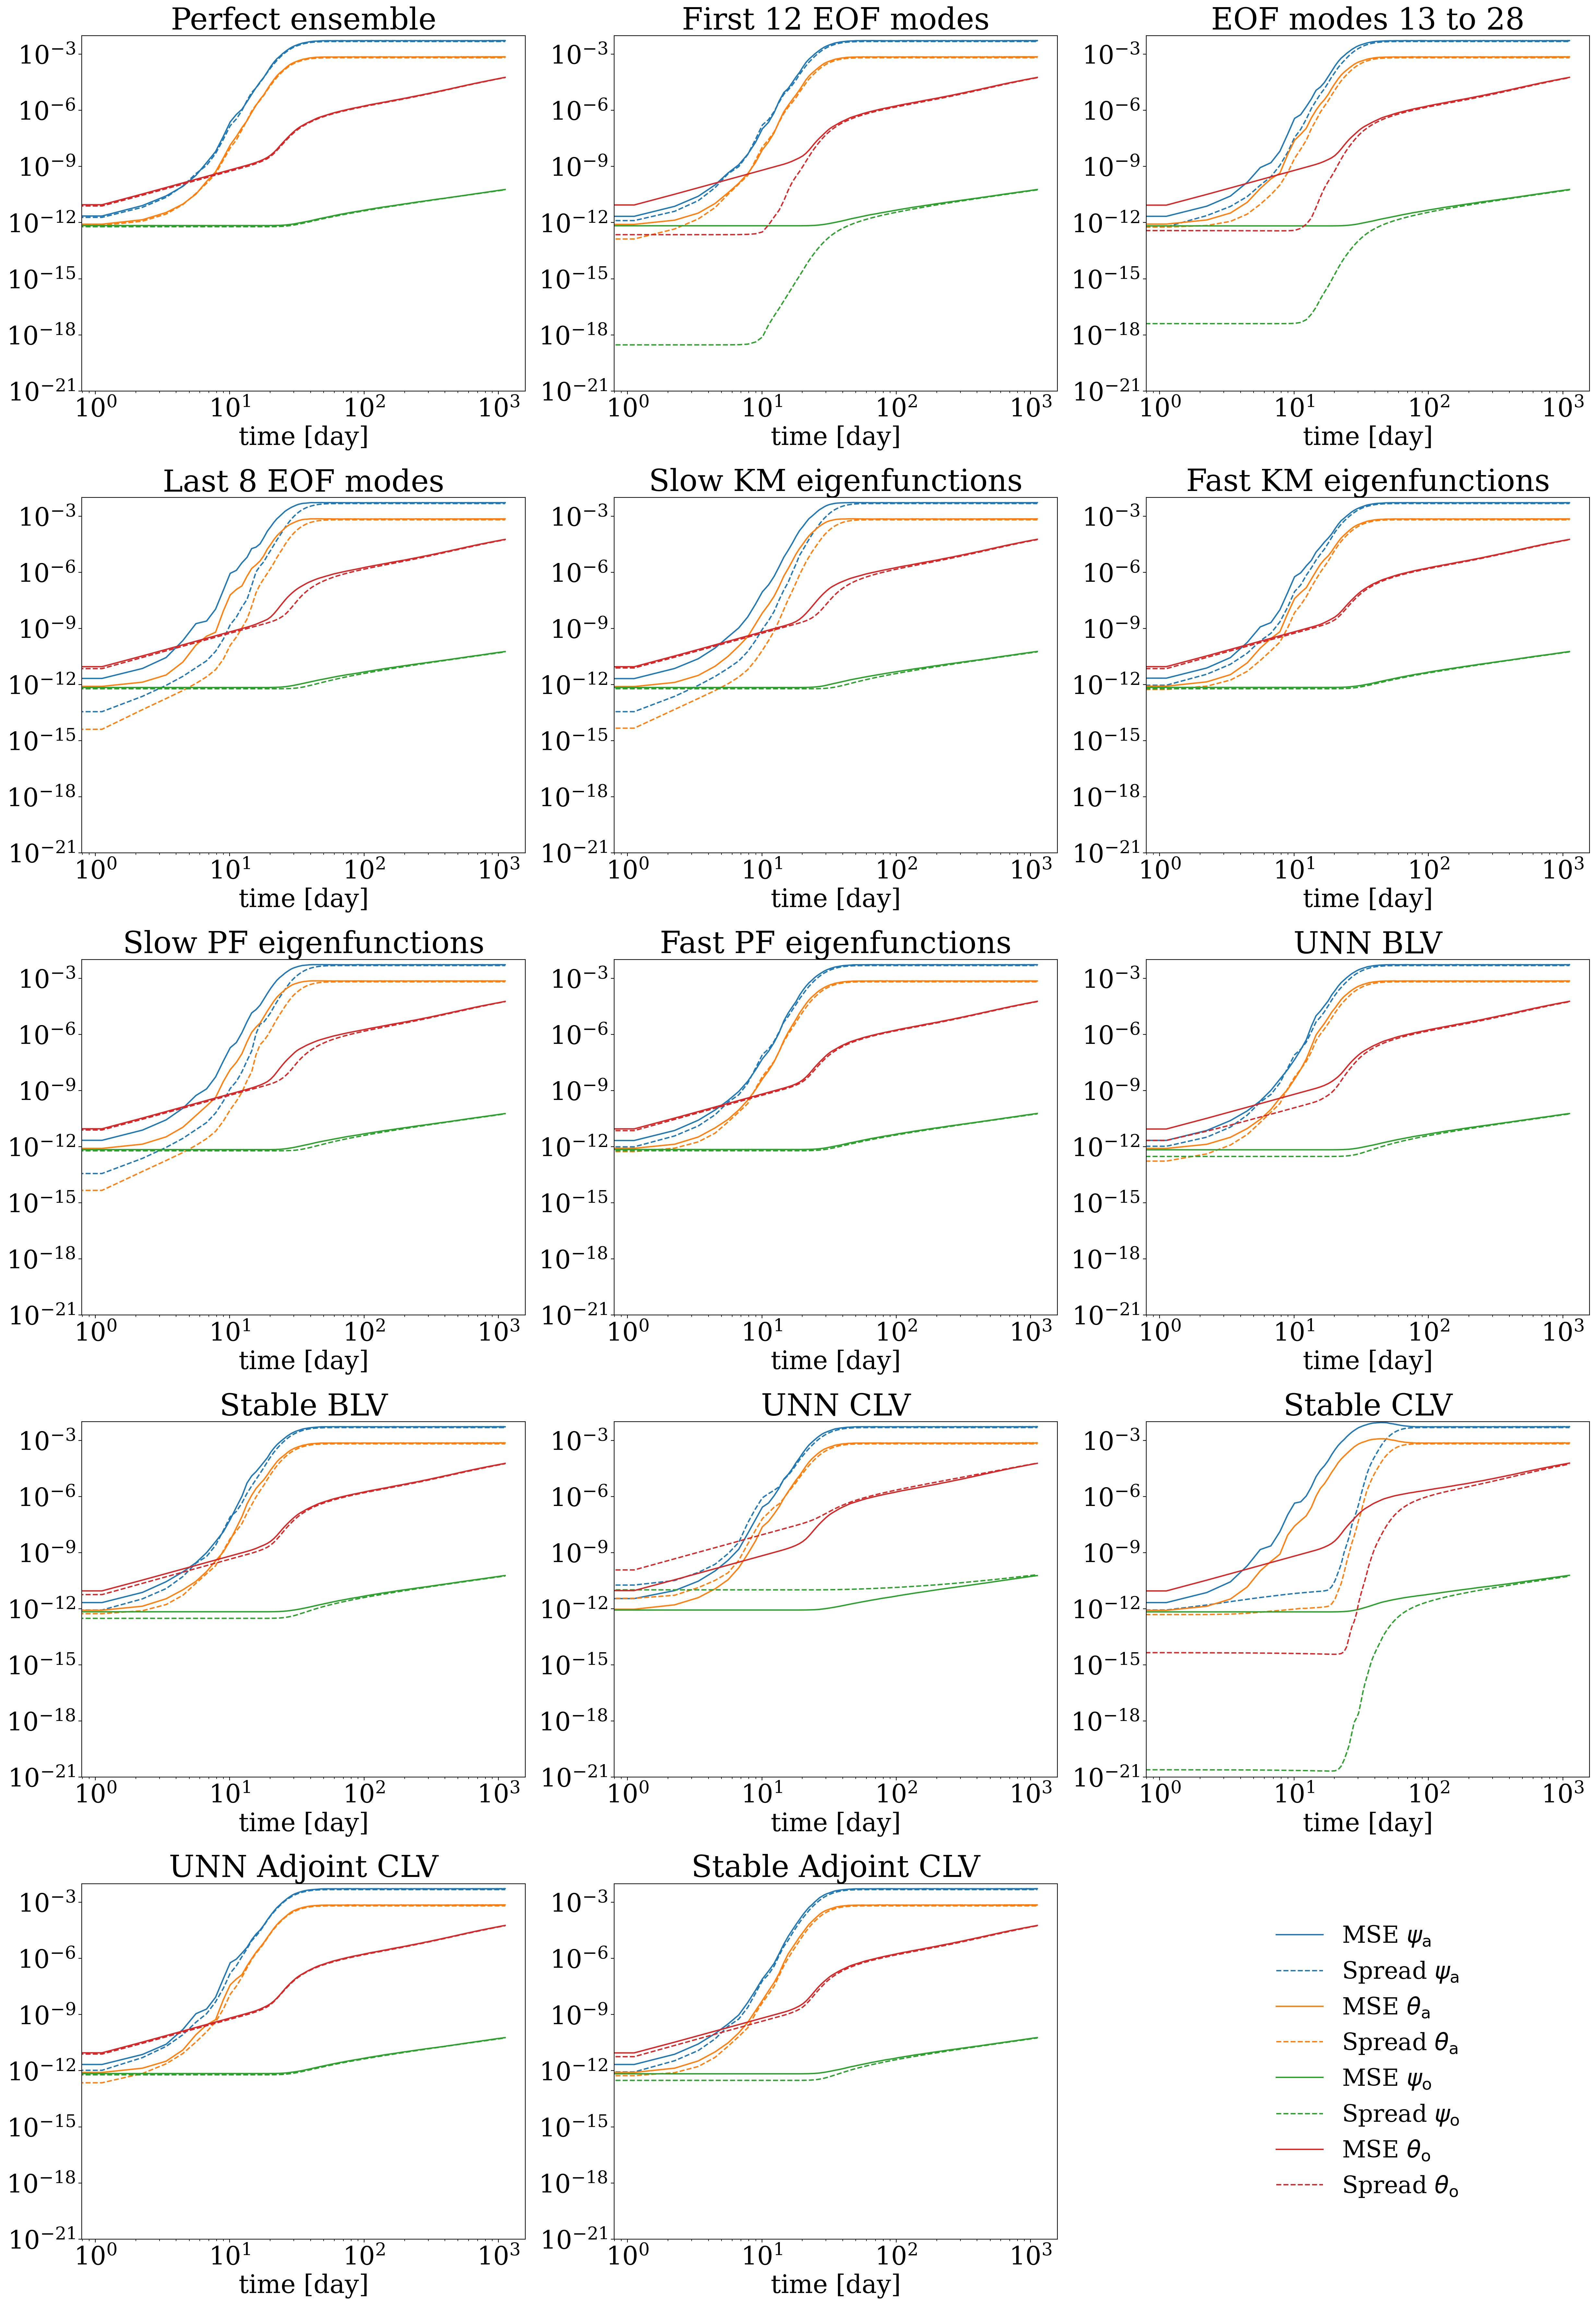

In [96]:
fig, axs = plt.subplots(5, 3, figsize=(30,45))
axsl = axs.flatten()
ct = model_parameters.dimensional_time
obj = list()

for i in range(len(short_exp_name)):
    l, = axsl[i].loglog(ct*t, MSE_psi_a[i], color='tab:blue', label=r'MSE $\psi_{\rm a}$')
    if i==0:
        obj.append(l)
    l, = axsl[i].loglog(ct*t, spread_psi_a[i], color='tab:blue', ls='--', label=r'Spread $\psi_{\rm a}$')
    if i==0:
        obj.append(l)
    
    l, = axsl[i].loglog(ct*t, MSE_theta_a[i], color='tab:orange', label=r'MSE $\theta_{\rm a}$')
    if i==0:
        obj.append(l)
    l, = axsl[i].loglog(ct*t, spread_theta_a[i], color='tab:orange', ls='--', label=r'Spread $\theta_{\rm a}$')
    if i==0:
        obj.append(l)
    
    l, = axsl[i].loglog(ct*t, MSE_psi_o[i], color='tab:green', label=r'MSE $\psi_{\rm o}$')
    if i==0:
        obj.append(l)
    l, = axsl[i].loglog(ct*t, spread_psi_o[i], color='tab:green', ls='--', label=r'Spread $\psi_{\rm o}$')
    if i==0:
        obj.append(l)
    
    l, = axsl[i].loglog(ct*t, MSE_theta_o[i], color='tab:red', label=r'MSE $\theta_{\rm o}$')
    if i==0:
        obj.append(l)
    l, = axsl[i].loglog(ct*t, spread_theta_o[i], color='tab:red', ls='--', label=r'Spread $\theta_{\rm o}$')
    if i==0:
        obj.append(l)
    
#     axsl[i].legend(fontsize=16.)
    axsl[i].set_title(short_exp_name[i])
#     ylim = axsl[i].get_ylim()
    axsl[i].set_ylim(1.e-21, 0.01)
    axsl[i].set_xlabel('time [day]')

axsl[-1].set_frame_on(False)
axsl[-1].axes.get_yaxis().set_visible(False)
axsl[-1].axes.get_xaxis().set_visible(False)

axsl[-1].legend(handles=obj, frameon=False, fontsize=26., loc="center");

plt.subplots_adjust(hspace=0.3)
 
plt.savefig('./fig_supp_MSE_noLFV.pdf', bbox_inches='tight')

## Supplementary figure: Plotting the DSSS as a function of the lead time

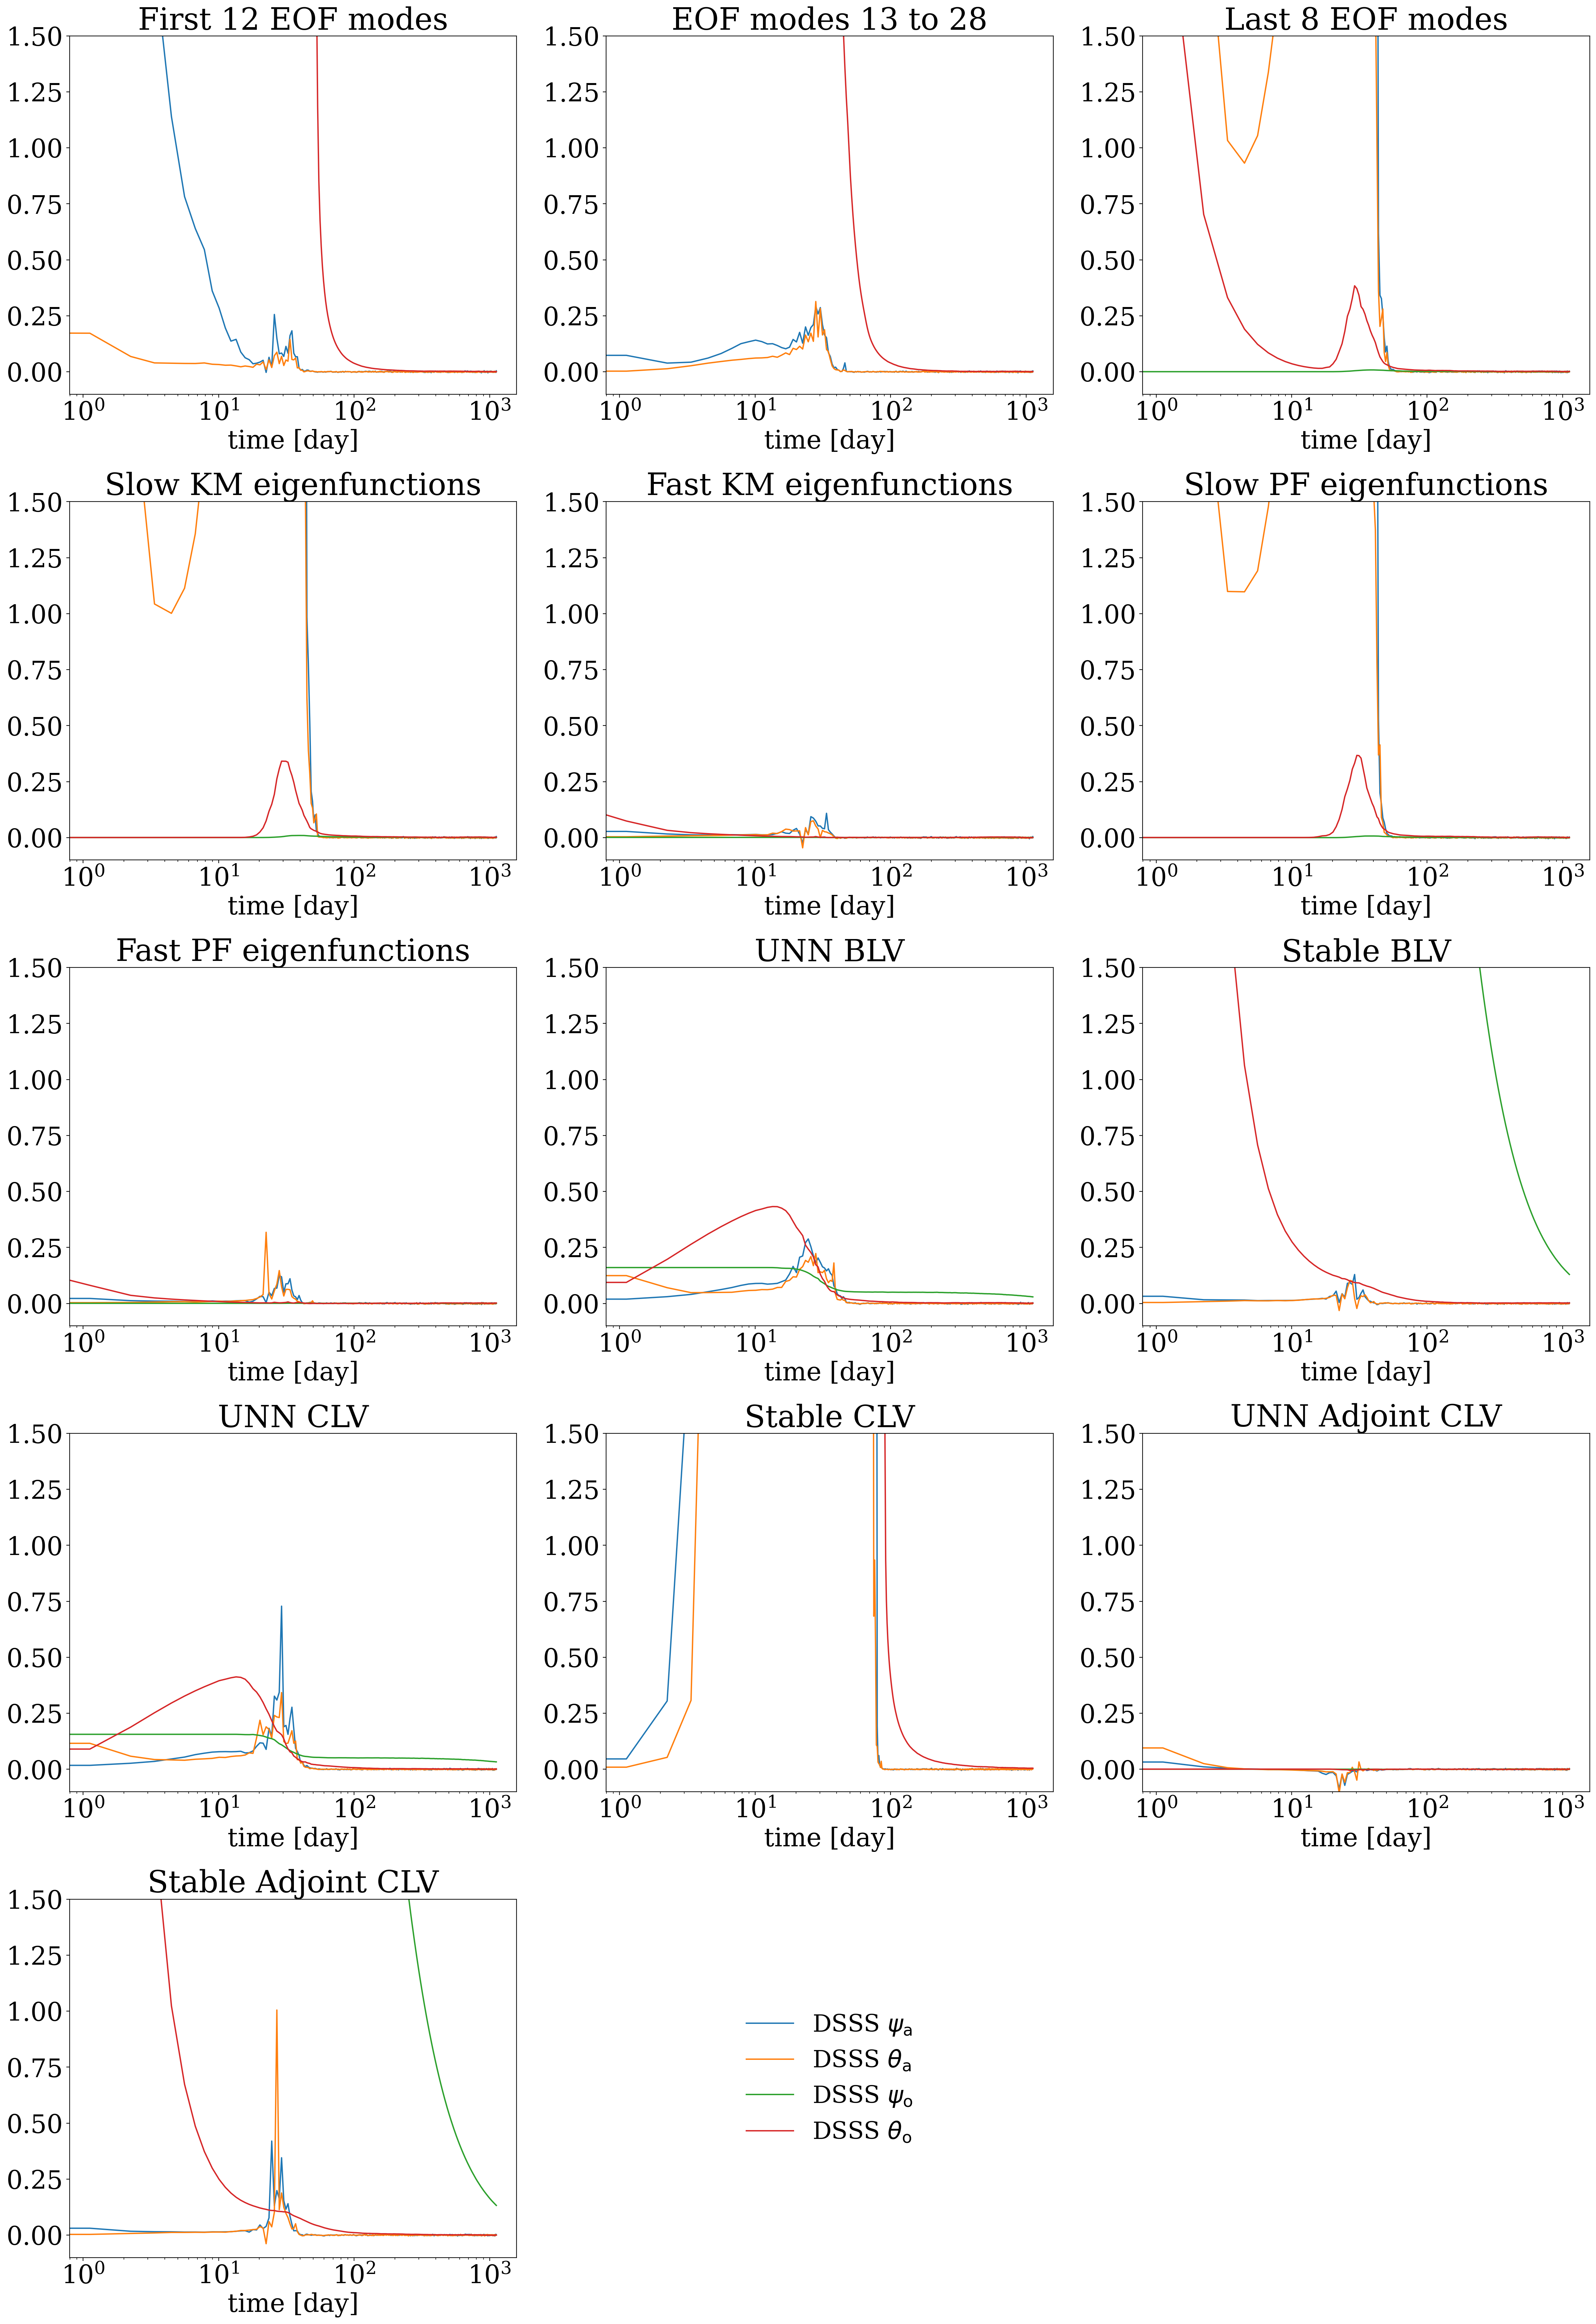

In [97]:
fig, axs = plt.subplots(5, 3, figsize=(30,45))
axsl = axs.flatten()
ct = model_parameters.dimensional_time
obj = list()

for i in range(1,len(exp_name)):
    l, = axsl[i-1].semilogx(ct*t, 1.-DSS_psi_a[i]/DSS_psi_a[0], color='tab:blue', label=r'DSSS $\psi_{\rm a}$')
    if i==1:
        obj.append(l)
    l, = axsl[i-1].semilogx(ct*t, 1.-DSS_theta_a[i]/DSS_theta_a[0], color='tab:orange', label=r'DSSS $\theta_{\rm a}$')
    if i==1:
        obj.append(l)
    l, = axsl[i-1].semilogx(ct*t, 1.-DSS_psi_o[i]/DSS_psi_o[0], color='tab:green', label=r'DSSS $\psi_{\rm o}$')
    if i==1:
        obj.append(l)
    l, = axsl[i-1].semilogx(ct*t, 1.-DSS_theta_o[i]/DSS_theta_o[0], color='tab:red', label=r'DSSS $\theta_{\rm o}$')
    if i==1:
        obj.append(l)
    
#     axsl[i-1].legend(fontsize=16.)
    axsl[i-1].set_title(short_exp_name[i])
    axsl[i-1].set_xlabel('time [day]')
#     axsl[i-1].set_ylabel('DSS anomaly')
    axsl[i-1].set_ylim(-0.1,1.5)
    
axsl[-2].set_frame_on(False)
axsl[-2].axes.get_yaxis().set_visible(False)
axsl[-2].axes.get_xaxis().set_visible(False)

axsl[-2].legend(handles=obj, frameon=False, fontsize=26., loc="center");

axsl[-1].set_frame_on(False)
axsl[-1].axes.get_yaxis().set_visible(False)
axsl[-1].axes.get_xaxis().set_visible(False)

plt.subplots_adjust(hspace=0.3)    
 
plt.savefig('./fig_supp_DSSS_noLFV.pdf', bbox_inches='tight')

## Figure 6: Plotting the DSSS ranking at certain lead time

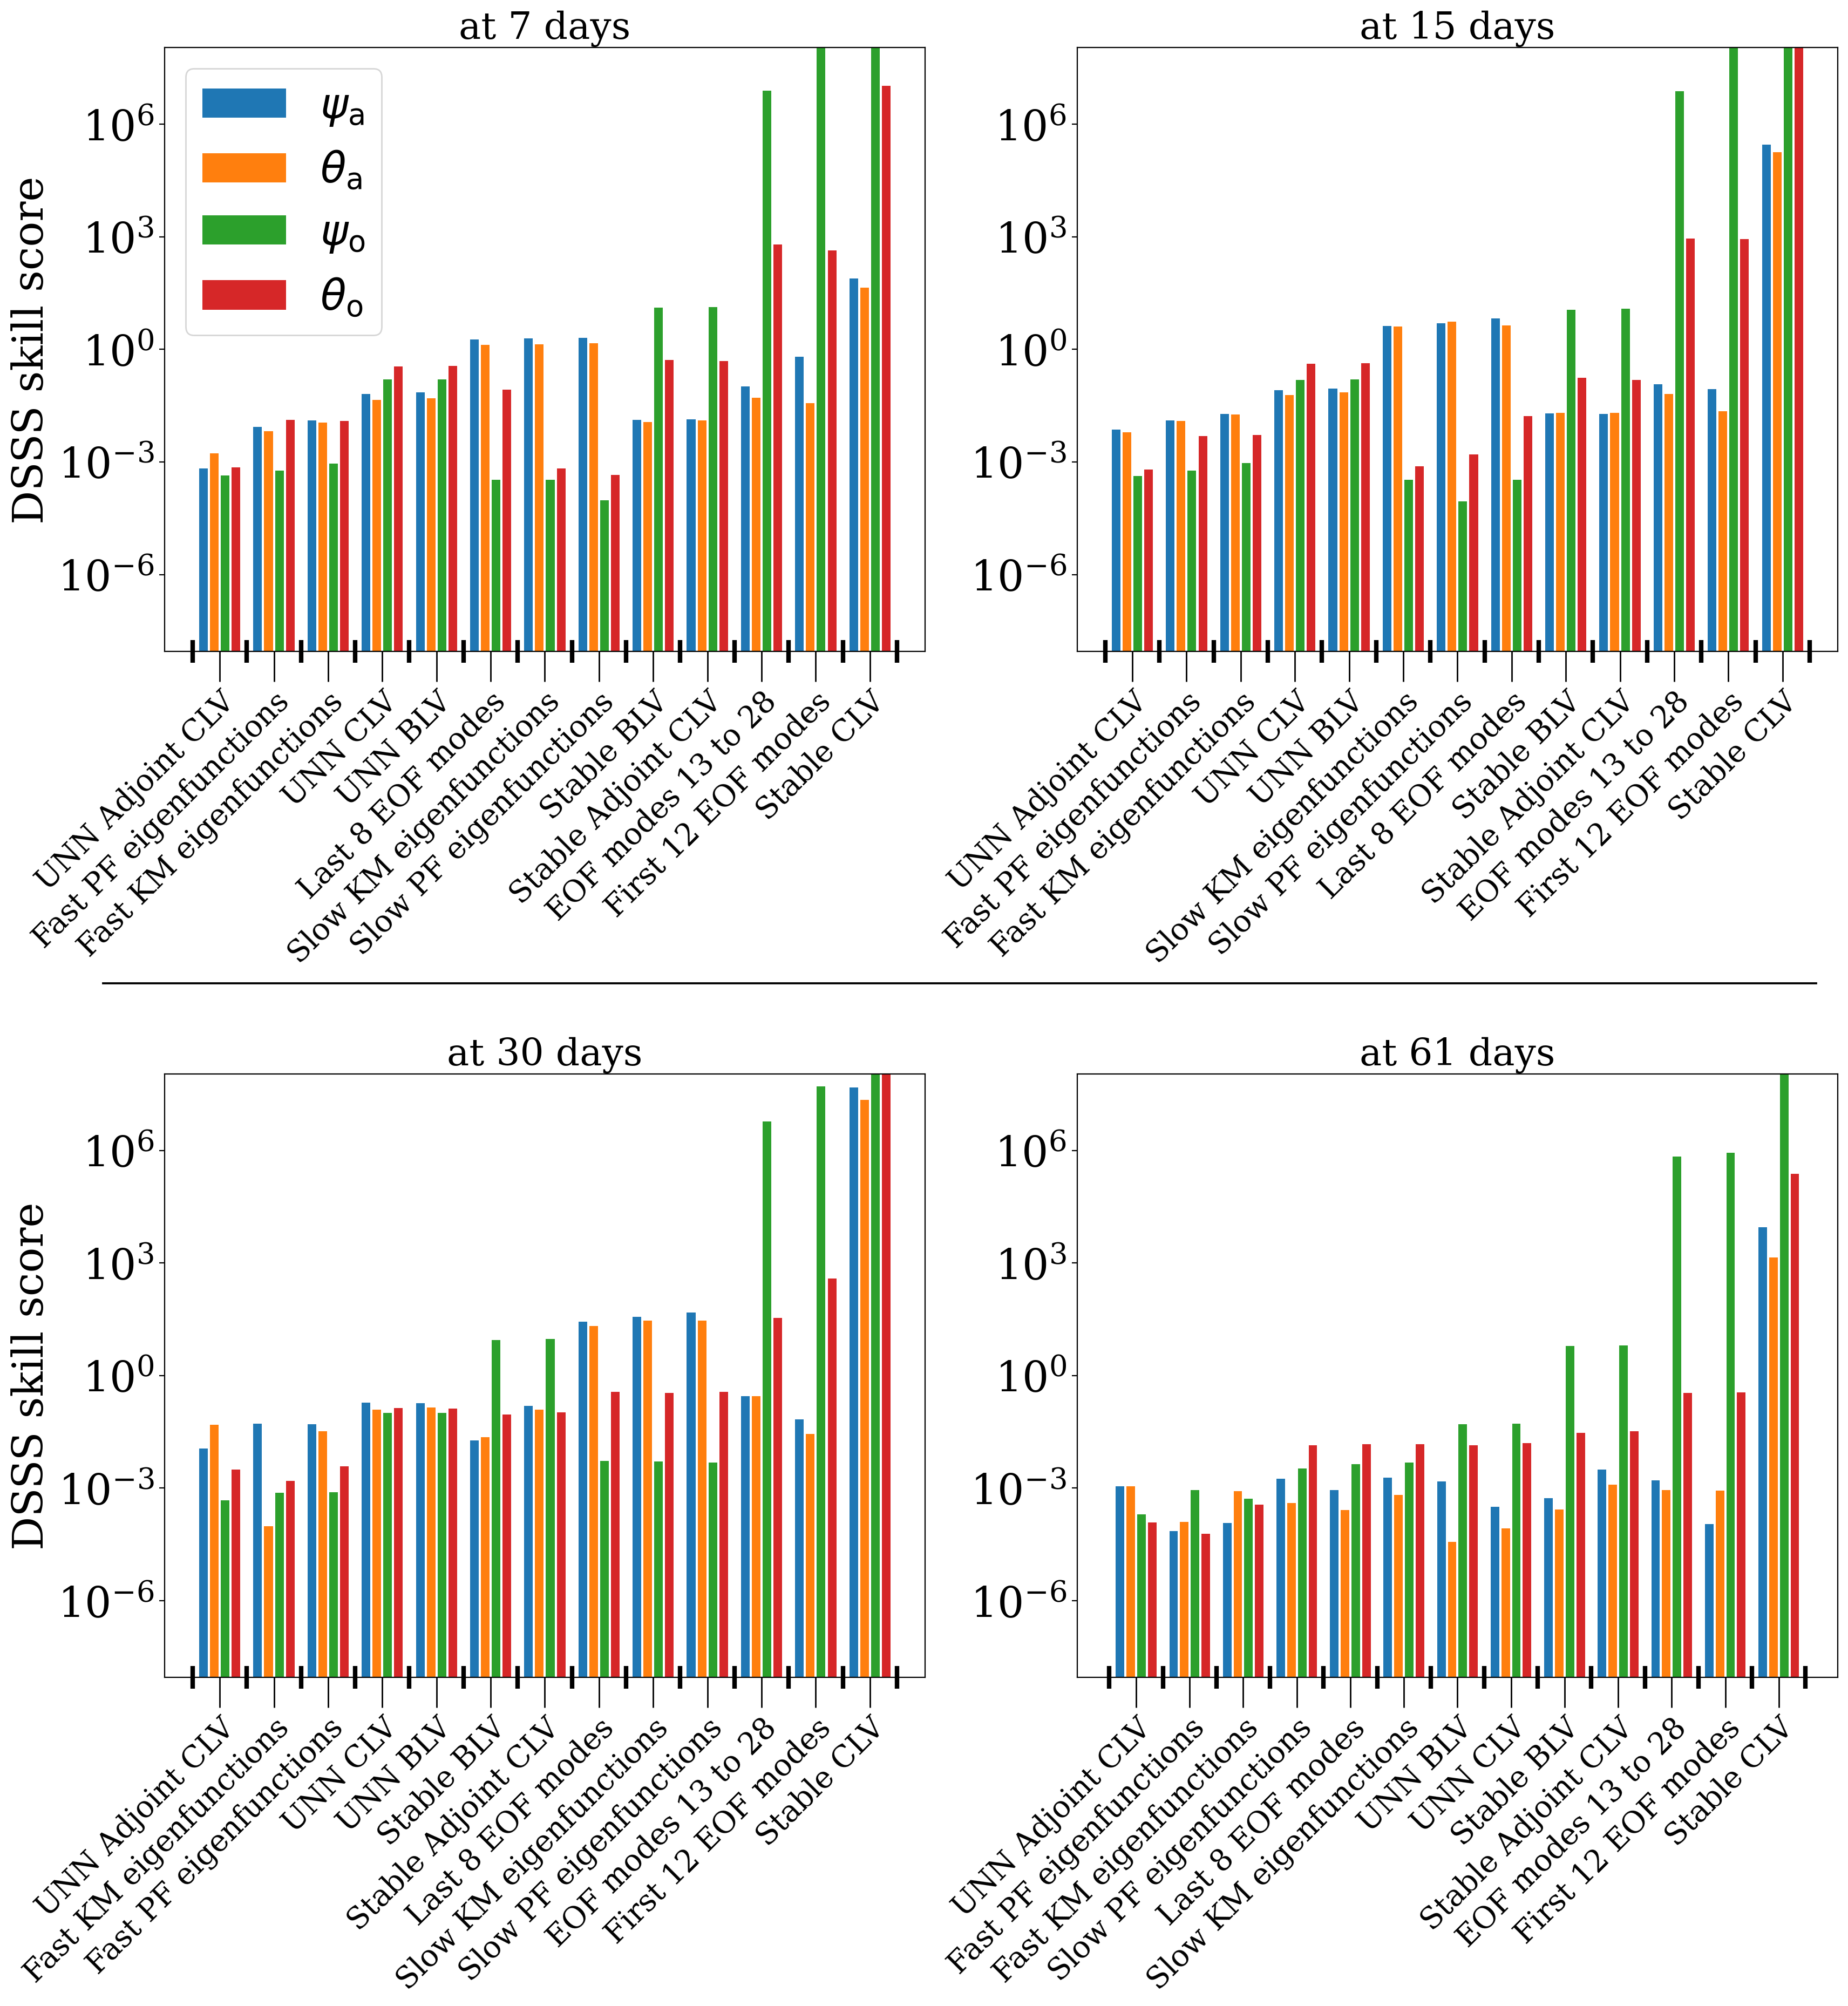

In [98]:
cov_times = [6, 13, 27, 54]
nrows = int(len(cov_times)/2)
fig, axl = plt.subplots(nrows=nrows,ncols=2,figsize=(20,10*nrows))
plt.subplots_adjust(hspace=0.7)

axl = axl.flatten()

for i in range(0,len(cov_times)):
    DSSS_order = list()
    DSSS_sum = list()
    for j in range(1,len(exp_name)):
        DSSS_sum.append(4.-DSS_psi_a[j][cov_times[i]]/DSS_psi_a[0][cov_times[i]]
                        -DSS_theta_a[j][cov_times[i]]/DSS_theta_a[0][cov_times[i]]
                        -DSS_psi_o[j][cov_times[i]]/DSS_psi_o[0][cov_times[i]]
                        -DSS_theta_o[j][cov_times[i]]/DSS_theta_o[0][cov_times[i]])
    DSSS_order = np.argsort(DSSS_sum)
    
    for k in range(len(exp_name)-1):
        p = k+1
        j = DSSS_order[k]+1
        if k == 0:
            axl[i].bar(p*5, np.abs(1.-DSS_psi_a[j][cov_times[i]]/DSS_psi_a[0][cov_times[i]]), color='tab:blue', label=r'$\psi_{\rm a}$')
            axl[i].bar(p*5+1, np.abs(1.-DSS_theta_a[j][cov_times[i]]/DSS_theta_a[0][cov_times[i]]), color='tab:orange', label=r'$\theta_{\rm a}$')
            axl[i].bar(p*5+2, np.abs(1.-DSS_psi_o[j][cov_times[i]]/DSS_psi_o[0][cov_times[i]]), color='tab:green', label=r'$\psi_{\rm o}$')
            axl[i].bar(p*5+3, np.abs(1.-DSS_theta_o[j][cov_times[i]]/DSS_theta_o[0][cov_times[i]]), color='tab:red', label=r'$\theta_{\rm o}$')

        else:
            axl[i].bar(p*5, np.abs(1.-DSS_psi_a[j][cov_times[i]]/DSS_psi_a[0][cov_times[i]]), color='tab:blue')
            axl[i].bar(p*5+1, np.abs(1.-DSS_theta_a[j][cov_times[i]]/DSS_theta_a[0][cov_times[i]]), color='tab:orange')
            axl[i].bar(p*5+2, np.abs(1.-DSS_psi_o[j][cov_times[i]]/DSS_psi_o[0][cov_times[i]]), color='tab:green')
            axl[i].bar(p*5+3, np.abs(1.-DSS_theta_o[j][cov_times[i]]/DSS_theta_o[0][cov_times[i]]), color='tab:red')

    tlabels = [short_exp_name[1:][DSSS_order[l]] for l in range(len(DSSS_order))]

    # axl[i].set_ylabel('component')
    # axl[i].set_xlabel('rank')
    
    axl[i].set_title('at '+str(round(ct*t[cov_times[i]]))+' days', y=1., fontsize=25.);
    axl[i].set_ylim(0.9e-8,1.1e8)
    axl[i].set_yscale('log')
    if i==0:
        axl[i].legend()
    plt.margins(0.2)
    
    major = np.arange(4.,(len(exp_name))*5,5.)
    minor = major[:-1]+2.5
    axl[i].tick_params(axis='x', which='major', direction='inout', length=15., width=3.)
    axl[i].tick_params(axis='x', which='minor', direction='out', length=20., width=1.)
    axl[i].set_xticks(major)
    axl[i].set_xticks(minor, minor=True)
    axl[i].set_xticklabels(len(major)*[''], fontsize=14.)
    axl[i].set_xticklabels(tlabels, fontsize=20., minor=True, rotation=45., va="top", ha="right", rotation_mode="anchor")


axl[0].set_ylabel("DSSS skill score")
axl[2].set_ylabel("DSSS skill score")
axl[-1].set_xlim(1.,72.)
axl[-1].axvspan(-90.,70.,1.150,1.151, clip_on=False, color='k')

# fig.suptitle('DSSS', y=0.93)
# axl[-1].set_frame_on(False)
# axl[-1].axes.get_yaxis().set_visible(False)
# axl[-1].axes.get_xaxis().set_visible(False)
 

plt.savefig('./fig06.pdf', bbox_inches='tight')

## Figure 9: Projecting the BLVs on the DMD and adjoint DMD subspaces

Defining a standard deviation range plot:

In [99]:
def std_plot(x, mean, std, ax=None, **kwargs):

    if ax is None:
        fig = plt.figure()
        ax = fig.gca()

    ax.fill_between(x, mean - std, mean + std, **kwargs)

    return ax


Computing the projection and their angle with the original vector:

In [100]:
# slow PFMDs
# projecting
slow_pfd_proj_blvs = np.real(np.moveaxis(slow_pfd_projector @ np.moveaxis(bvec, -1, 0), 0, -1))
# normalizing
slow_pfd_proj_blvs = slow_pfd_proj_blvs / np.sqrt(np.sum(slow_pfd_proj_blvs**2, axis=0))
# scalar products
slow_pfd_sp = np.sum(bvec * slow_pfd_proj_blvs, axis=0)
# extracting the angles and averaging
angle_btw_blvs_and_slow_pfds = np.mean(np.rad2deg(np.arccos(np.abs(slow_pfd_sp))), axis=-1)
std_angle_btw_blvs_and_slow_pfds = np.std(np.rad2deg(np.arccos(np.abs(slow_pfd_sp))), axis=-1)

In [101]:
# fast PFMDs
# projecting
fast_pfd_proj_blvs = np.real(np.moveaxis(fast_pfd_projector @ np.moveaxis(bvec, -1, 0), 0, -1))
# normalizing
fast_pfd_proj_blvs = fast_pfd_proj_blvs / np.sqrt(np.sum(fast_pfd_proj_blvs**2, axis=0))
# scalar products
fast_pfd_sp = np.sum(bvec * fast_pfd_proj_blvs, axis=0)
# extracting the angles and averaging
angle_btw_blvs_and_fast_pfds = np.mean(np.rad2deg(np.arccos(np.abs(fast_pfd_sp))), axis=-1)
std_angle_btw_blvs_and_fast_pfds = np.std(np.rad2deg(np.arccos(np.abs(fast_pfd_sp))), axis=-1)

In [102]:
# slow DMDs
# projecting
slow_dmd_proj_blvs = np.real(np.moveaxis(slow_dmd_projector @ np.moveaxis(bvec, -1, 0), 0, -1))
# normalizing
slow_dmd_proj_blvs = slow_dmd_proj_blvs / np.sqrt(np.sum(slow_dmd_proj_blvs**2, axis=0))
# scalar products
slow_dmd_sp = np.sum(bvec * slow_dmd_proj_blvs, axis=0)
# extracting the angles and averaging
angle_btw_blvs_and_slow_dmds = np.mean(np.rad2deg(np.arccos(np.abs(slow_dmd_sp))), axis=-1)
std_angle_btw_blvs_and_slow_dmds = np.std(np.rad2deg(np.arccos(np.abs(slow_dmd_sp))), axis=-1)

In [103]:
# fast DMDs
# projecting
fast_dmd_proj_blvs = np.real(np.moveaxis(fast_dmd_projector @ np.moveaxis(bvec, -1, 0), 0, -1))
# normalizing
fast_dmd_proj_blvs = fast_dmd_proj_blvs / np.sqrt(np.sum(fast_dmd_proj_blvs**2, axis=0))
# scalar products
fast_dmd_sp = np.sum(bvec * fast_dmd_proj_blvs, axis=0)
# extracting the angles and averaging
angle_btw_blvs_and_fast_dmds = np.mean(np.rad2deg(np.arccos(np.abs(fast_dmd_sp))), axis=-1)
std_angle_btw_blvs_and_fast_dmds = np.std(np.rad2deg(np.arccos(np.abs(fast_dmd_sp))), axis=-1)

In [104]:
# slow Adjoint DMDs
# projecting
slow_addmd_proj_blvs = np.real(np.moveaxis(slow_addmd_projector @ np.moveaxis(bvec, -1, 0), 0, -1))
# normalizing
slow_addmd_proj_blvs = slow_addmd_proj_blvs / np.sqrt(np.sum(slow_addmd_proj_blvs**2, axis=0))
# scalar products
slow_addmd_sp = np.sum(bvec * slow_addmd_proj_blvs, axis=0)
# extracting the angles and averaging
angle_btw_blvs_and_slow_addmds = np.mean(np.rad2deg(np.arccos(np.abs(slow_addmd_sp))), axis=-1)
std_angle_btw_blvs_and_slow_addmds = np.std(np.rad2deg(np.arccos(np.abs(slow_addmd_sp))), axis=-1)

In [105]:
# fast Adjoint DMDs
# projecting
fast_addmd_proj_blvs = np.real(np.moveaxis(fast_addmd_projector @ np.moveaxis(bvec, -1, 0), 0, -1))
# normalizing
fast_addmd_proj_blvs = fast_addmd_proj_blvs / np.sqrt(np.sum(fast_addmd_proj_blvs**2, axis=0))
# scalar products
fast_addmd_sp = np.sum(bvec * fast_addmd_proj_blvs, axis=0)
# extracting the angles and averaging
angle_btw_blvs_and_fast_addmds = np.mean(np.rad2deg(np.arccos(np.abs(fast_addmd_sp))), axis=-1)
std_angle_btw_blvs_and_fast_addmds = np.std(np.rad2deg(np.arccos(np.abs(fast_addmd_sp))), axis=-1)

Plotting

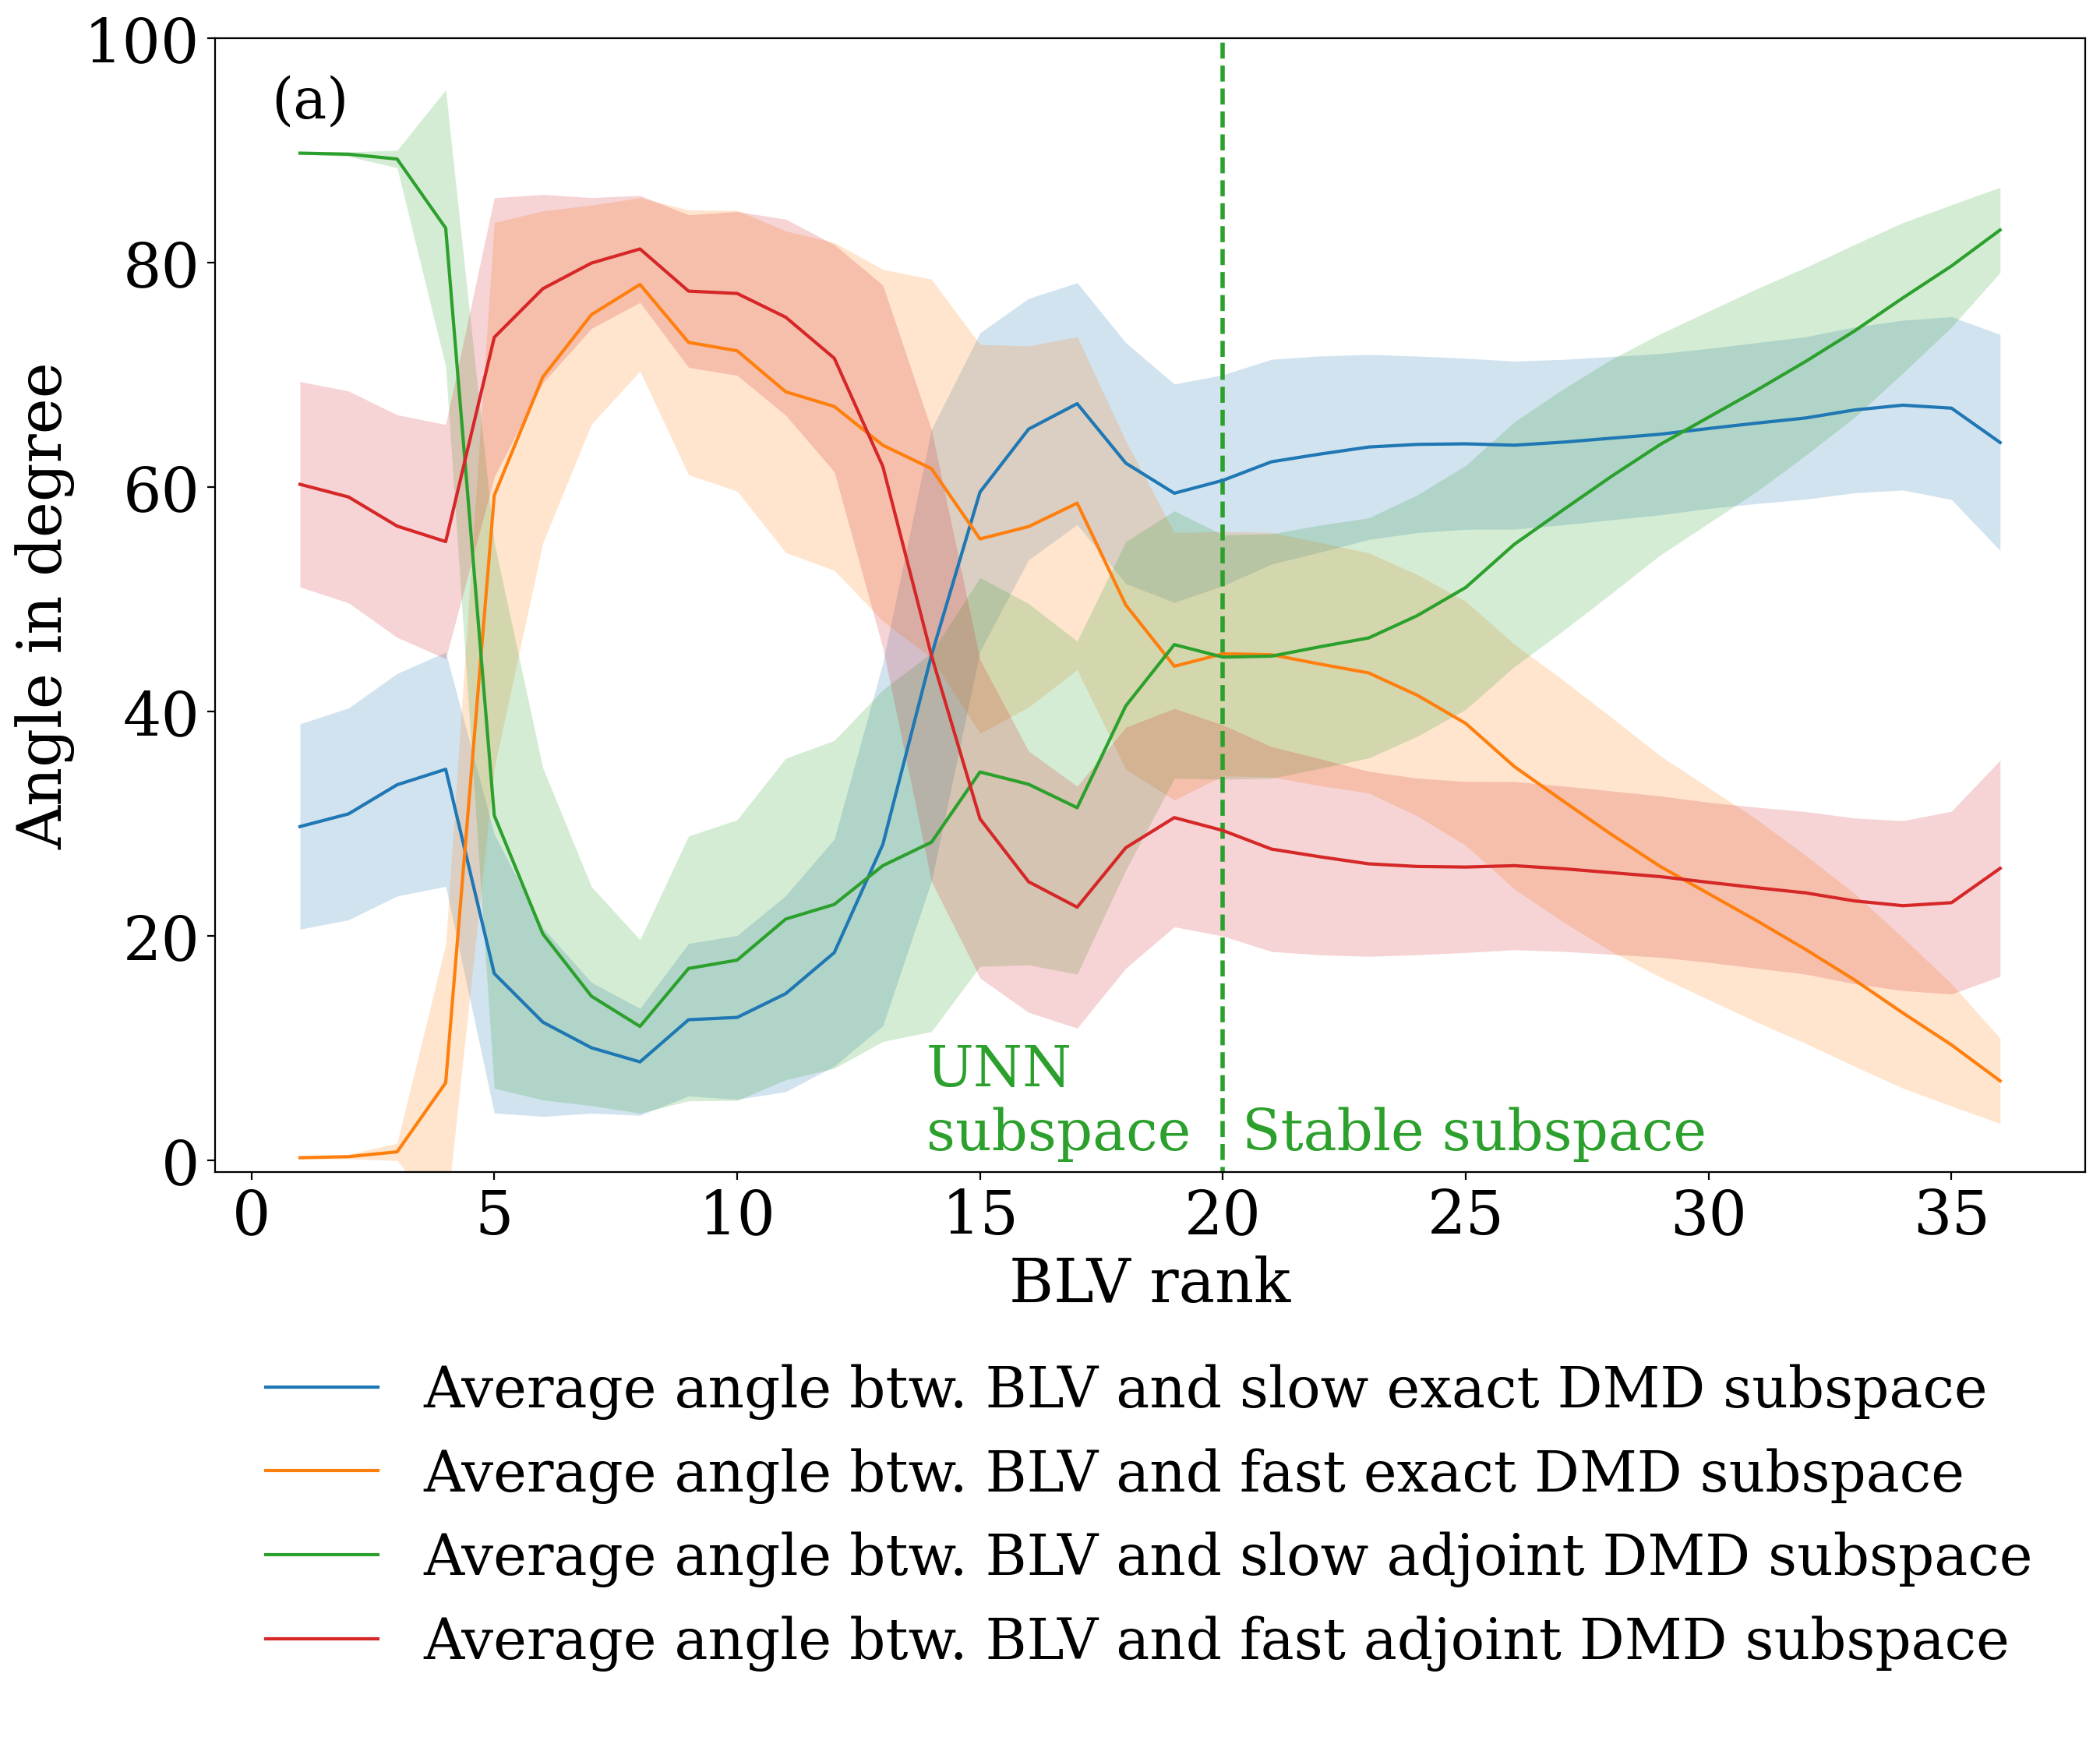

In [126]:
fig = plt.figure(figsize=(15,13.5))

gs = fig.add_gridspec(2, 1, height_ratios=(10,3.5), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

ax = fig.add_subplot(gs[0,0])

obj = list()

l, = ax.plot(range(1, len(angle_btw_blvs_and_slow_dmds)+1), angle_btw_blvs_and_slow_dmds, label='Average angle btw. BLV and slow exact DMD subspace')
std_plot(range(1, len(angle_btw_blvs_and_slow_dmds)+1), angle_btw_blvs_and_slow_dmds, std_angle_btw_blvs_and_slow_dmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_blvs_and_fast_dmds)+1), angle_btw_blvs_and_fast_dmds, label='Average angle btw. BLV and fast exact DMD subspace')
std_plot(range(1, len(angle_btw_blvs_and_fast_dmds)+1), angle_btw_blvs_and_fast_dmds, std_angle_btw_blvs_and_fast_dmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)                   
l, = ax.plot(range(1, len(angle_btw_blvs_and_slow_addmds)+1), angle_btw_blvs_and_slow_addmds, label='Average angle btw. BLV and slow adjoint DMD subspace')
std_plot(range(1, len(angle_btw_blvs_and_slow_addmds)+1), angle_btw_blvs_and_slow_addmds, std_angle_btw_blvs_and_slow_addmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_blvs_and_fast_addmds)+1), angle_btw_blvs_and_fast_addmds, label='Average angle btw. BLV and fast adjoint DMD subspace')
std_plot(range(1, len(angle_btw_blvs_and_fast_addmds)+1), angle_btw_blvs_and_fast_addmds, std_angle_btw_blvs_and_fast_addmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)

# ax.legend(fontsize=16.)

ax.text(0.03, 0.93, '(a)', transform=ax.transAxes, fontsize=26.)
ax.set_ylim(-1,100)
ax.vlines(near_neutral_index[-1]+1,-2.,100., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 1., 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 1., 'Stable subspace', fontsize=26., color='tab:green')
ax.set_xlabel('BLV rank')
ax.set_ylabel('Angle in degree');

ax = fig.add_subplot(gs[1,0])

ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.legend(handles=obj, frameon=False, fontsize=26., loc='lower left');
 
plt.savefig('./fig09a.pdf', bbox_inches='tight')

### Supplementary figure : Projecting the BLVs on the PFMD

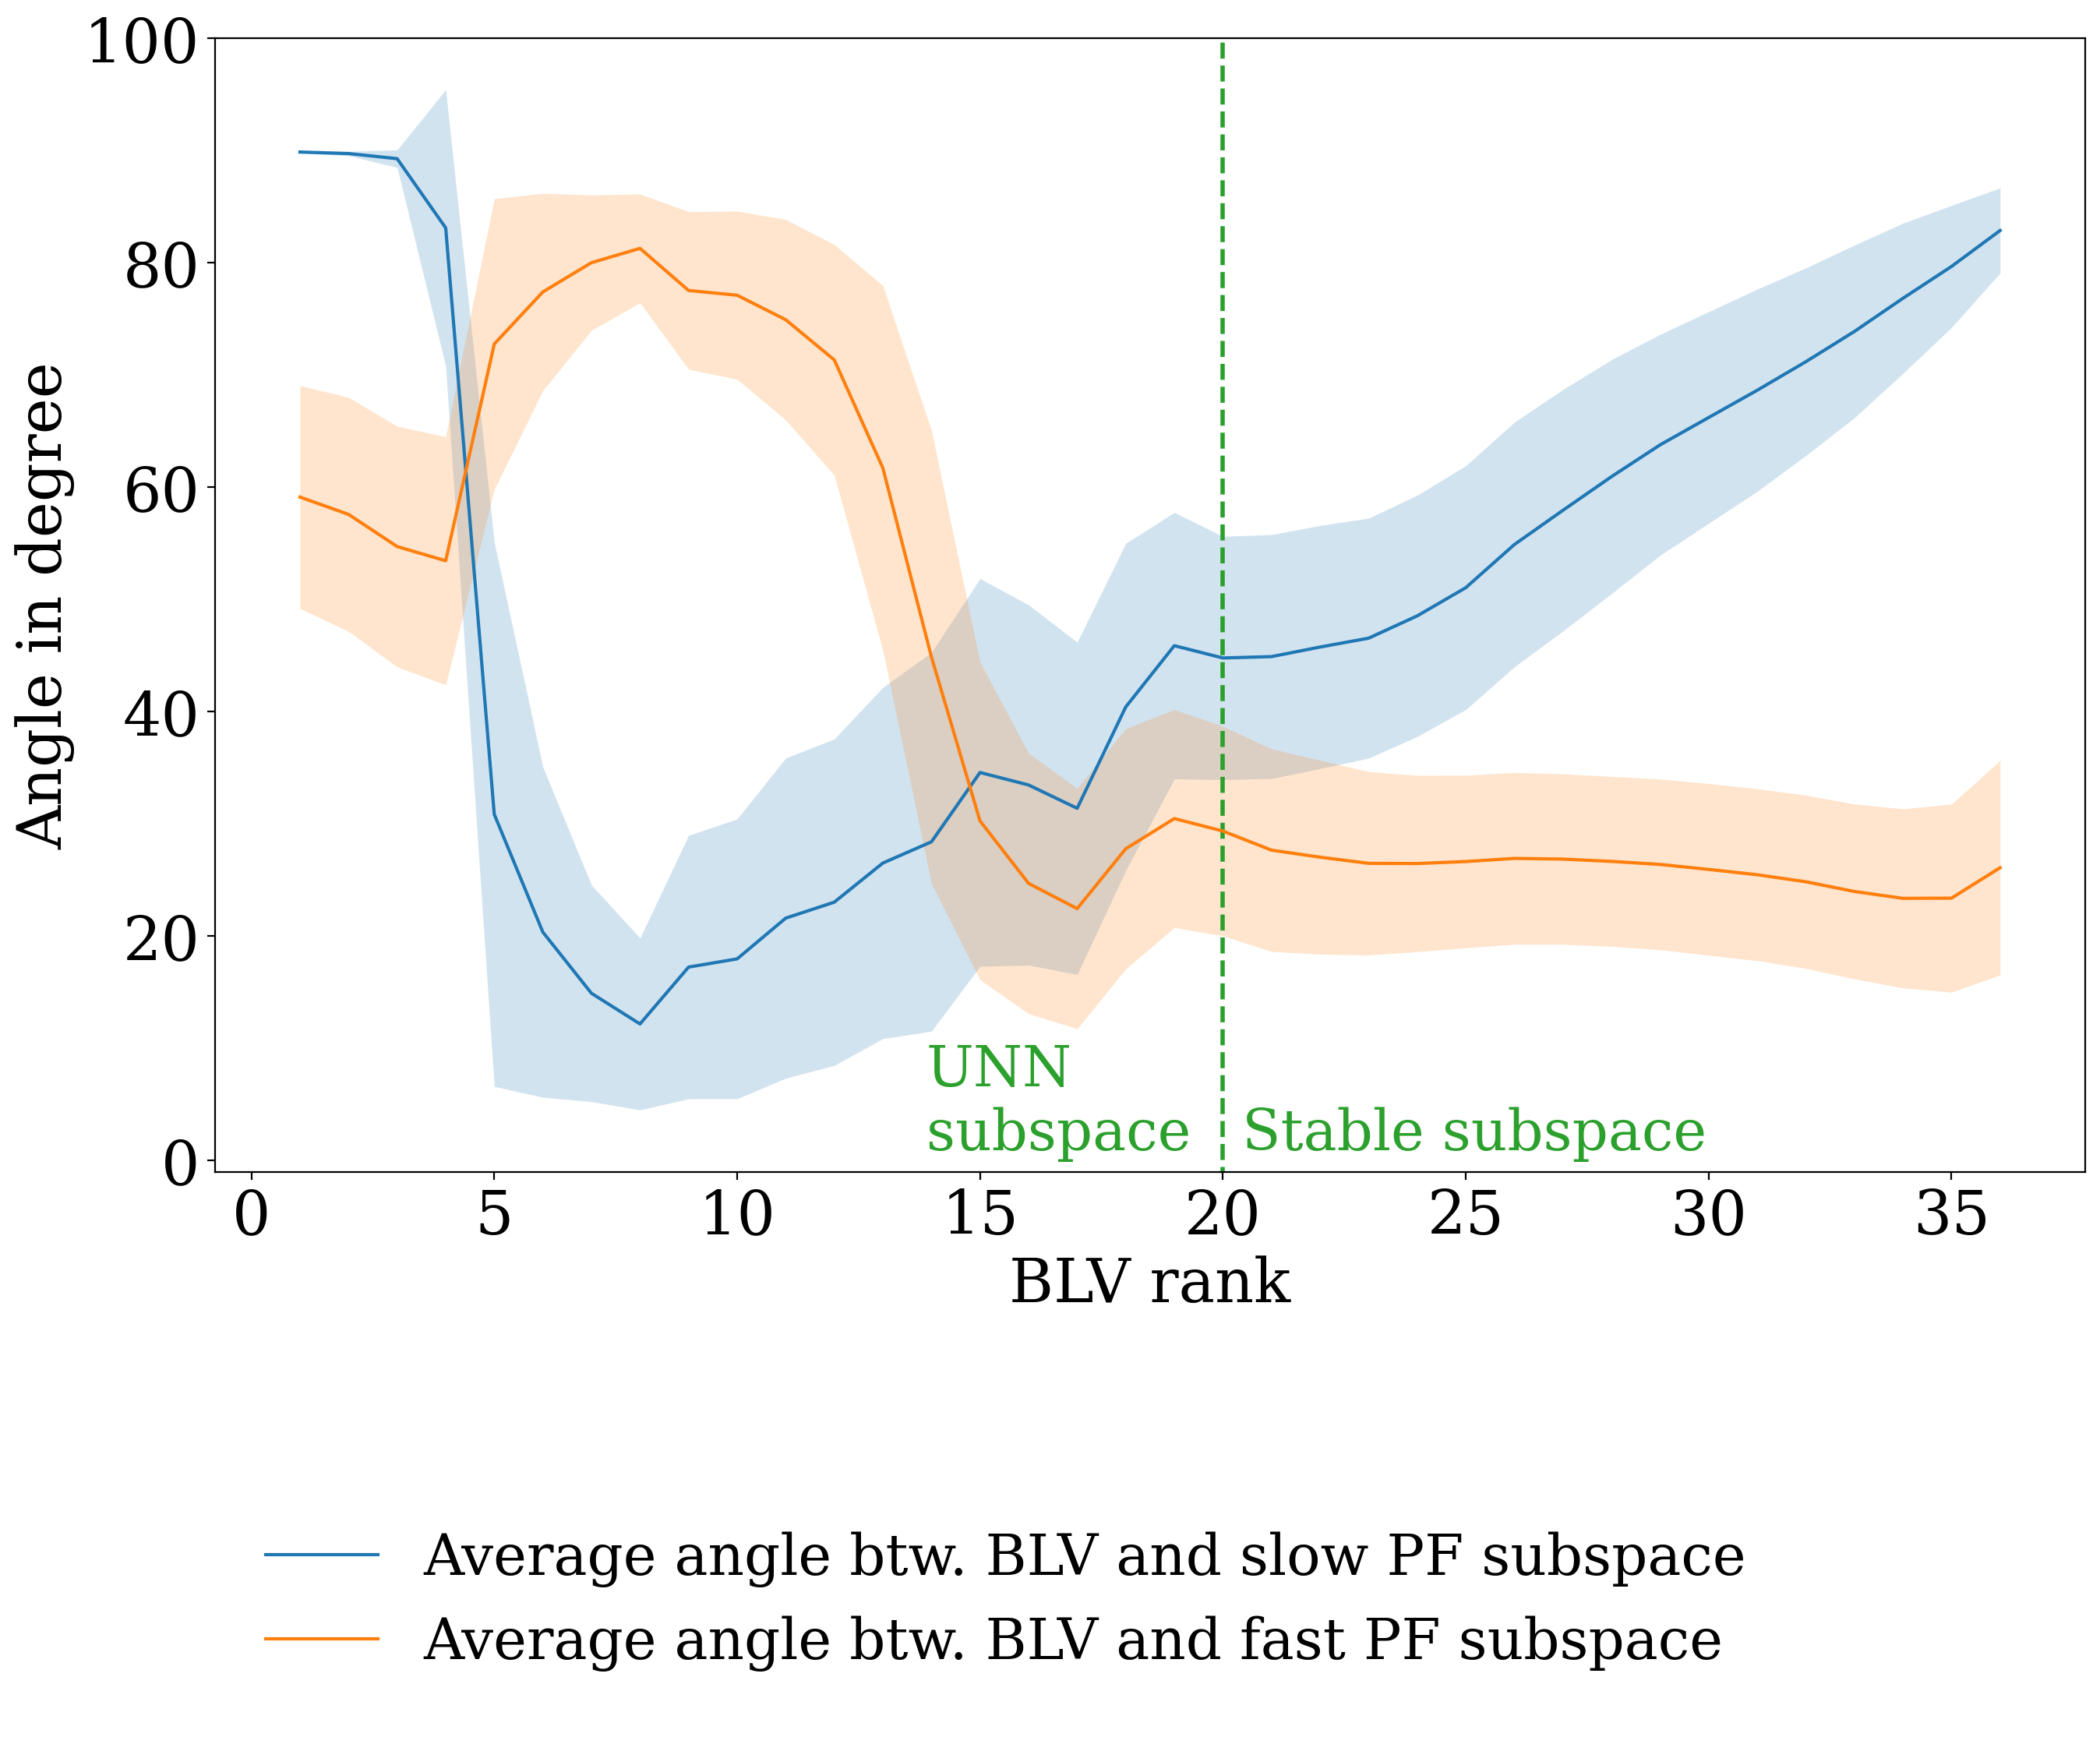

In [107]:
fig = plt.figure(figsize=(15,13.5))

gs = fig.add_gridspec(2, 1, height_ratios=(10,3.5), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

ax = fig.add_subplot(gs[0,0])

obj = list()
                   
l, = ax.plot(range(1, len(angle_btw_blvs_and_slow_pfds)+1), angle_btw_blvs_and_slow_pfds, label='Average angle btw. BLV and slow PF subspace')
std_plot(range(1, len(angle_btw_blvs_and_slow_pfds)+1), angle_btw_blvs_and_slow_pfds, std_angle_btw_blvs_and_slow_pfds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_blvs_and_fast_pfds)+1), angle_btw_blvs_and_fast_pfds, label='Average angle btw. BLV and fast PF subspace')
std_plot(range(1, len(angle_btw_blvs_and_fast_pfds)+1), angle_btw_blvs_and_fast_pfds, std_angle_btw_blvs_and_fast_pfds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)

# ax.legend(fontsize=16.)

# ax.text(0.03, 0.93, '(a)', transform=ax.transAxes, fontsize=26.)
ax.set_ylim(-1,100)
ax.vlines(near_neutral_index[-1]+1,-2.,100., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 1., 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 1., 'Stable subspace', fontsize=26., color='tab:green')
ax.set_xlabel('BLV rank')
ax.set_ylabel('Angle in degree');

ax = fig.add_subplot(gs[1,0])

ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.legend(handles=obj, frameon=False, fontsize=26., loc='lower left');
 
plt.savefig('./fig_supp_BLVvsPFMD_noLFV.pdf', bbox_inches='tight')

## Figure 10: Projecting the CLVs on the DMD and adjoint DMD subspaces

Computing the projection and their angle with the original vector:

In [108]:
# slow PFDs
# projecting
slow_pfd_proj_clvs = np.real(np.moveaxis(slow_pfd_projector @ np.moveaxis(cvec, -1, 0), 0, -1))
# normalizing
slow_pfd_proj_clvs = slow_pfd_proj_clvs / np.sqrt(np.sum(slow_pfd_proj_clvs**2, axis=0))
# scalar products
slow_pfd_sp = np.sum(cvec * slow_pfd_proj_clvs, axis=0)
# extracting the angles and averaging
angle_btw_clvs_and_slow_pfds = np.mean(np.rad2deg(np.arccos(np.abs(slow_pfd_sp))), axis=-1)
std_angle_btw_clvs_and_slow_pfds = np.std(np.rad2deg(np.arccos(np.abs(slow_pfd_sp))), axis=-1)

In [109]:
# fast PFDs
# projecting
fast_pfd_proj_clvs = np.real(np.moveaxis(fast_pfd_projector @ np.moveaxis(cvec, -1, 0), 0, -1))
# normalizing
fast_pfd_proj_clvs = fast_pfd_proj_clvs / np.sqrt(np.sum(fast_pfd_proj_clvs**2, axis=0))
# scalar products
fast_pfd_sp = np.sum(cvec * fast_pfd_proj_clvs, axis=0)
# extracting the angles and averaging
angle_btw_clvs_and_fast_pfds = np.mean(np.rad2deg(np.arccos(np.abs(fast_pfd_sp))), axis=-1)
std_angle_btw_clvs_and_fast_pfds = np.std(np.rad2deg(np.arccos(np.abs(fast_pfd_sp))), axis=-1)

In [110]:
# slow exact DMDs
# projecting
slow_dmd_proj_clvs = np.real(np.moveaxis(slow_dmd_projector @ np.moveaxis(cvec, -1, 0), 0, -1))
# normalizing
slow_dmd_proj_clvs = slow_dmd_proj_clvs / np.sqrt(np.sum(slow_dmd_proj_clvs**2, axis=0))
# scalar products
slow_dmd_sp = np.sum(cvec * slow_dmd_proj_clvs, axis=0)
# extracting the angles and averaging
angle_btw_clvs_and_slow_dmds = np.mean(np.rad2deg(np.arccos(np.abs(slow_dmd_sp))), axis=-1)
std_angle_btw_clvs_and_slow_dmds = np.std(np.rad2deg(np.arccos(np.abs(slow_dmd_sp))), axis=-1)

In [111]:
# fast exact DMDs
# projecting
fast_dmd_proj_clvs = np.real(np.moveaxis(fast_dmd_projector @ np.moveaxis(cvec, -1, 0), 0, -1))
# normalizing
fast_dmd_proj_clvs = fast_dmd_proj_clvs / np.sqrt(np.sum(fast_dmd_proj_clvs**2, axis=0))
# scalar products
fast_dmd_sp = np.sum(cvec * fast_dmd_proj_clvs, axis=0)
# extracting the angles and averaging
angle_btw_clvs_and_fast_dmds = np.mean(np.rad2deg(np.arccos(np.abs(fast_dmd_sp))), axis=-1)
std_angle_btw_clvs_and_fast_dmds = np.std(np.rad2deg(np.arccos(np.abs(fast_dmd_sp))), axis=-1)

In [112]:
# slow adjoint DMDs
# projecting
slow_addmd_proj_clvs = np.real(np.moveaxis(slow_addmd_projector @ np.moveaxis(cvec, -1, 0), 0, -1))
# normalizing
slow_addmd_proj_clvs = slow_addmd_proj_clvs / np.sqrt(np.sum(slow_addmd_proj_clvs**2, axis=0))
# scalar products
slow_addmd_sp = np.sum(cvec * slow_addmd_proj_clvs, axis=0)
# extracting the angles and averaging
angle_btw_clvs_and_slow_addmds = np.mean(np.rad2deg(np.arccos(np.abs(slow_addmd_sp))), axis=-1)
std_angle_btw_clvs_and_slow_addmds = np.std(np.rad2deg(np.arccos(np.abs(slow_addmd_sp))), axis=-1)

In [113]:
# fast adjoint DMDs
# projecting
fast_addmd_proj_clvs = np.real(np.moveaxis(fast_addmd_projector @ np.moveaxis(cvec, -1, 0), 0, -1))
# normalizing
fast_addmd_proj_clvs = fast_addmd_proj_clvs / np.sqrt(np.sum(fast_addmd_proj_clvs**2, axis=0))
# scalar products
fast_addmd_sp = np.sum(cvec * fast_addmd_proj_clvs, axis=0)
# extracting the angles and averaging
angle_btw_clvs_and_fast_addmds = np.mean(np.rad2deg(np.arccos(np.abs(fast_addmd_sp))), axis=-1)
std_angle_btw_clvs_and_fast_addmds = np.std(np.rad2deg(np.arccos(np.abs(fast_addmd_sp))), axis=-1)

Plotting

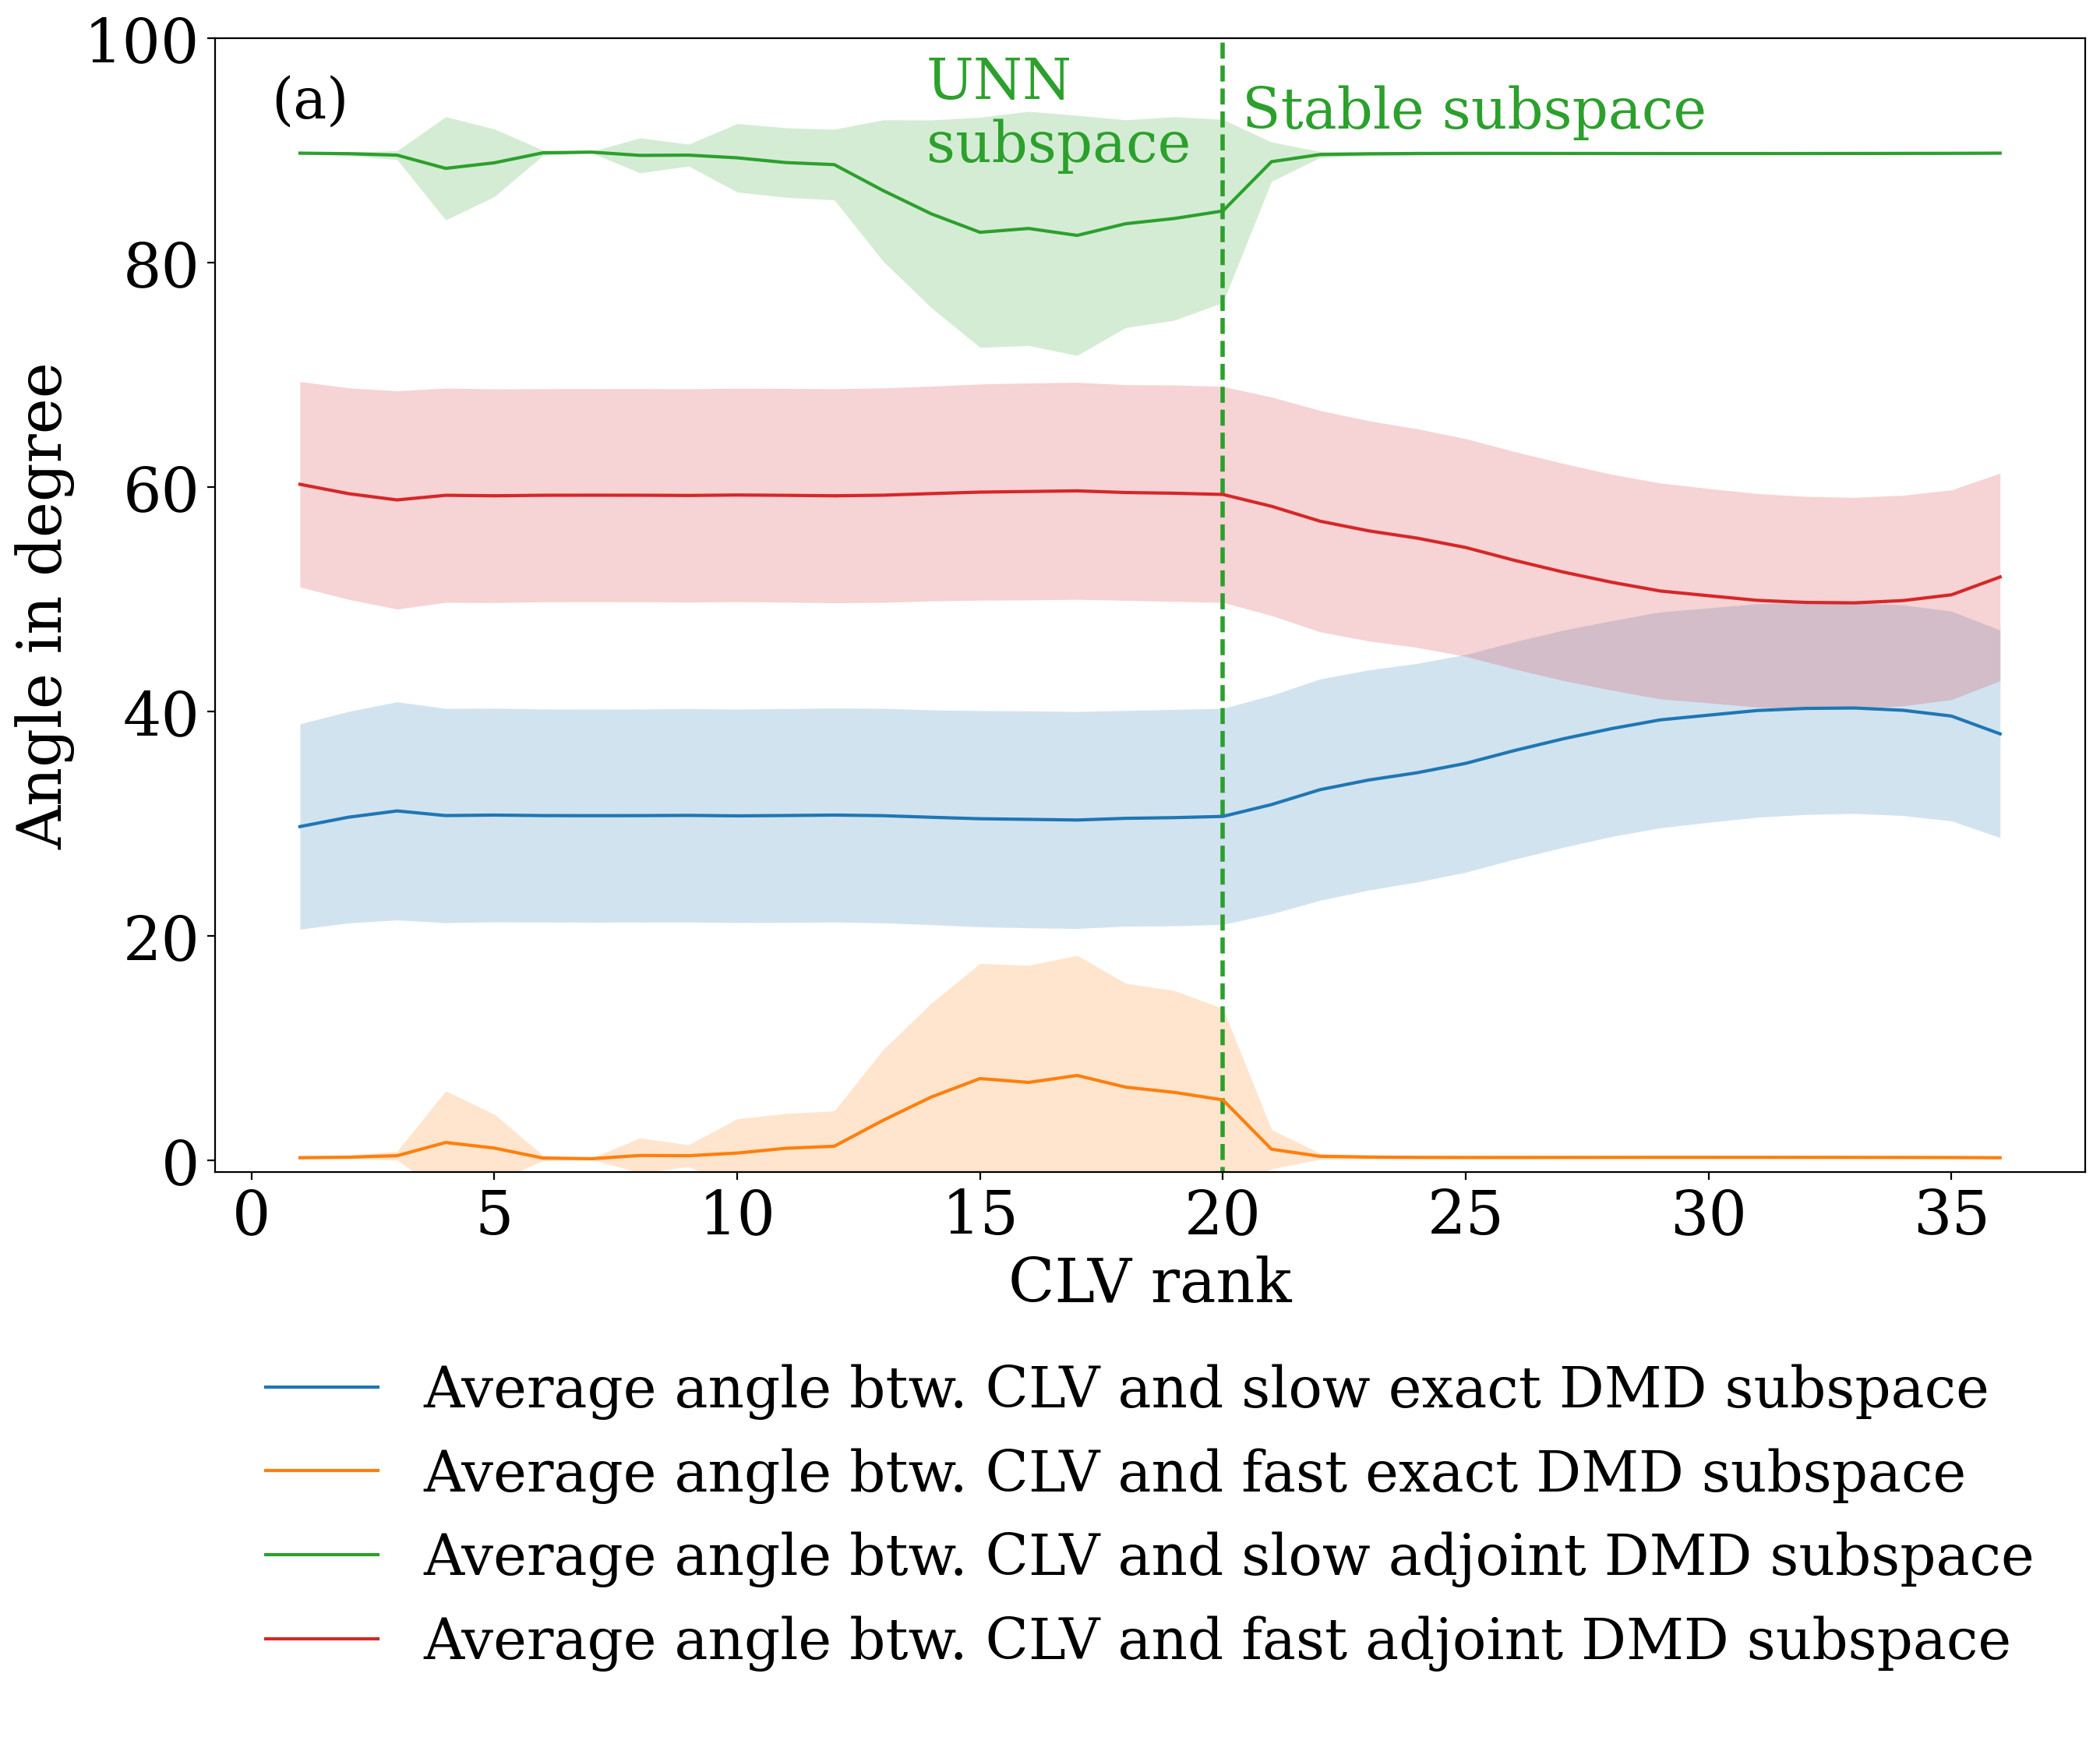

In [125]:
fig = plt.figure(figsize=(15,13.5))

gs = fig.add_gridspec(2, 1, height_ratios=(10,3.5), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

ax = fig.add_subplot(gs[0,0])

obj = list()

l, = ax.plot(range(1, len(angle_btw_clvs_and_slow_dmds)+1), angle_btw_clvs_and_slow_dmds, label='Average angle btw. CLV and slow exact DMD subspace')
std_plot(range(1, len(angle_btw_clvs_and_slow_dmds)+1), angle_btw_clvs_and_slow_dmds, std_angle_btw_clvs_and_slow_dmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_clvs_and_fast_dmds)+1), angle_btw_clvs_and_fast_dmds, label='Average angle btw. CLV and fast exact DMD subspace')
std_plot(range(1, len(angle_btw_clvs_and_fast_dmds)+1), angle_btw_clvs_and_fast_dmds, std_angle_btw_clvs_and_fast_dmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_clvs_and_slow_addmds)+1), angle_btw_clvs_and_slow_addmds, label='Average angle btw. CLV and slow adjoint DMD subspace')
std_plot(range(1, len(angle_btw_clvs_and_slow_addmds)+1), angle_btw_clvs_and_slow_addmds, std_angle_btw_clvs_and_slow_addmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_clvs_and_fast_addmds)+1), angle_btw_clvs_and_fast_addmds, label='Average angle btw. CLV and fast adjoint DMD subspace')
std_plot(range(1, len(angle_btw_clvs_and_fast_addmds)+1), angle_btw_clvs_and_fast_addmds, std_angle_btw_clvs_and_fast_addmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)

# ax.legend(fontsize=16.)

ax.text(0.03, 0.93, '(a)', transform=ax.transAxes, fontsize=26.)
ax.set_ylim(-1,100)
ax.vlines(near_neutral_index[-1]+1,-2.,100., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 89, 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 92., 'Stable subspace', fontsize=26., color='tab:green')
ax.set_xlabel('CLV rank')
ax.set_ylabel('Angle in degree');

ax = fig.add_subplot(gs[1,0])

ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.legend(handles=obj, frameon=False, fontsize=26., loc='lower left');

 
plt.savefig('./fig10a.pdf', bbox_inches='tight')

### Supplementary figure : Projecting the CLVs on the PFMD

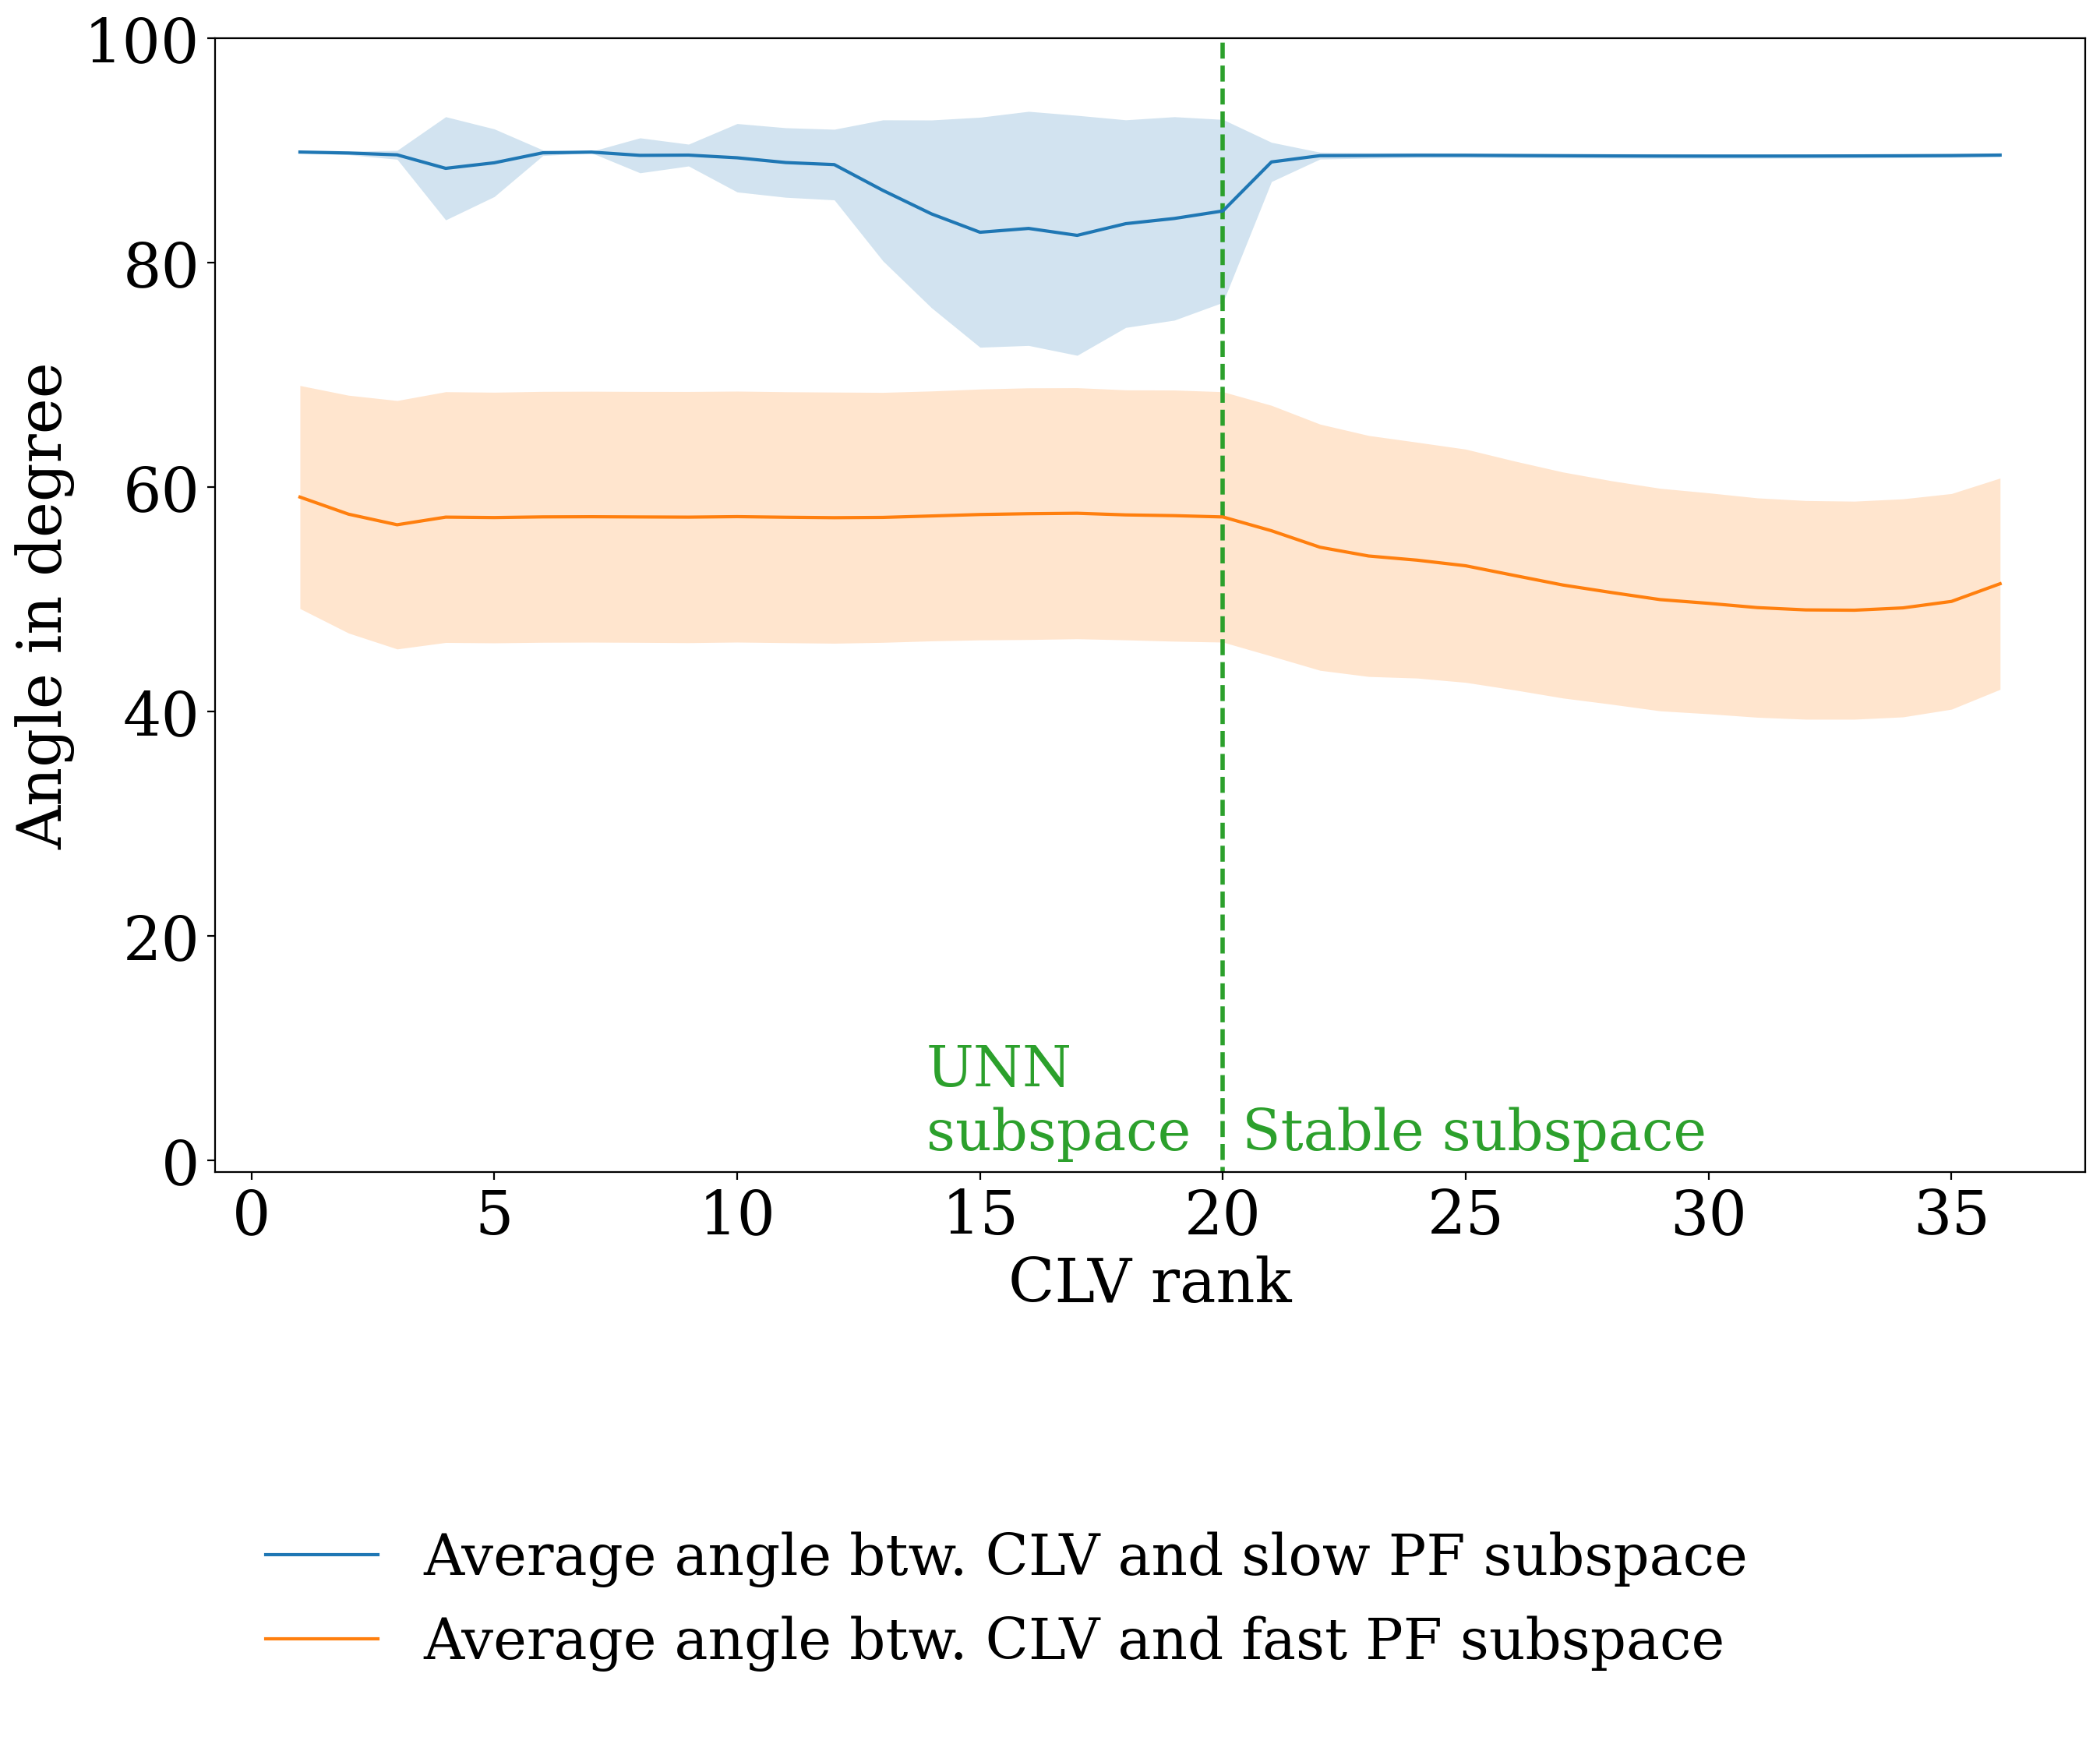

In [115]:
fig = plt.figure(figsize=(15,13.5))

gs = fig.add_gridspec(2, 1, height_ratios=(10,3.5), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

ax = fig.add_subplot(gs[0,0])

obj = list()

l, = ax.plot(range(1, len(angle_btw_clvs_and_slow_pfds)+1), angle_btw_clvs_and_slow_pfds, label='Average angle btw. CLV and slow PF subspace')
std_plot(range(1, len(angle_btw_clvs_and_slow_pfds)+1), angle_btw_clvs_and_slow_pfds, std_angle_btw_clvs_and_slow_pfds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_clvs_and_fast_pfds)+1), angle_btw_clvs_and_fast_pfds, label='Average angle btw. CLV and fast PF subspace')
std_plot(range(1, len(angle_btw_clvs_and_fast_pfds)+1), angle_btw_clvs_and_fast_pfds, std_angle_btw_clvs_and_fast_pfds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)

# ax.legend(fontsize=16.)

# ax.text(0.03, 0.93, '(a)', transform=ax.transAxes, fontsize=26.)
ax.set_ylim(-1,100)
ax.vlines(near_neutral_index[-1]+1,-2.,100., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 1., 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 1., 'Stable subspace', fontsize=26., color='tab:green')
ax.set_xlabel('CLV rank')
ax.set_ylabel('Angle in degree');

ax = fig.add_subplot(gs[1,0])

ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.legend(handles=obj, frameon=False, fontsize=26., loc='lower left');

 
plt.savefig('./fig_supp_CLVvsPFMD_noLFV.pdf', bbox_inches='tight')

## Figure 11: Projecting the Adjoint CLVs on the DMD and adjoint DMD subspaces

Computing the projection and their angle with the original vector:

In [116]:
# slow PFDs
# projecting
slow_pfd_proj_aclvs = np.real(np.moveaxis(slow_pfd_projector @ np.moveaxis(acvec, -1, 0), 0, -1))
# normalizing
slow_pfd_proj_aclvs = slow_pfd_proj_aclvs / np.sqrt(np.sum(slow_pfd_proj_aclvs**2, axis=0))
# scalar products
slow_pfd_sp = np.sum(acvec * slow_pfd_proj_aclvs, axis=0)
# extracting the angles and averaging
angle_btw_aclvs_and_slow_pfds = np.nanmean(np.rad2deg(np.arccos(np.abs(slow_pfd_sp))), axis=-1)
std_angle_btw_aclvs_and_slow_pfds = np.nanstd(np.rad2deg(np.arccos(np.abs(slow_pfd_sp))), axis=-1)

In [117]:
# fast PFDs
# projecting
fast_pfd_proj_aclvs = np.real(np.moveaxis(fast_pfd_projector @ np.moveaxis(acvec, -1, 0), 0, -1))
# normalizing
fast_pfd_proj_aclvs = fast_pfd_proj_aclvs / np.sqrt(np.sum(fast_pfd_proj_aclvs**2, axis=0))
# scalar products
fast_pfd_sp = np.sum(acvec * fast_pfd_proj_aclvs, axis=0)
# extracting the angles and averaging
angle_btw_aclvs_and_fast_pfds = np.nanmean(np.rad2deg(np.arccos(np.abs(fast_pfd_sp))), axis=-1)
std_angle_btw_aclvs_and_fast_pfds = np.nanstd(np.rad2deg(np.arccos(np.abs(fast_pfd_sp))), axis=-1)

In [118]:
# slow exact DMDs
# projecting
slow_dmd_proj_aclvs = np.real(np.moveaxis(slow_dmd_projector @ np.moveaxis(acvec, -1, 0), 0, -1))
# normalizing
slow_dmd_proj_aclvs = slow_dmd_proj_aclvs / np.sqrt(np.sum(slow_dmd_proj_aclvs**2, axis=0))
# scalar products
slow_dmd_sp = np.sum(acvec * slow_dmd_proj_aclvs, axis=0)
# extracting the angles and averaging
angle_btw_aclvs_and_slow_dmds = np.nanmean(np.rad2deg(np.arccos(np.abs(slow_dmd_sp))), axis=-1)
std_angle_btw_aclvs_and_slow_dmds = np.nanstd(np.rad2deg(np.arccos(np.abs(slow_dmd_sp))), axis=-1)

In [119]:
# fast exact DMDs
# projecting
fast_dmd_proj_aclvs = np.real(np.moveaxis(fast_dmd_projector @ np.moveaxis(acvec, -1, 0), 0, -1))
# normalizing
fast_dmd_proj_aclvs = fast_dmd_proj_aclvs / np.sqrt(np.sum(fast_dmd_proj_aclvs**2, axis=0))
# scalar products
fast_dmd_sp = np.sum(acvec * fast_dmd_proj_aclvs, axis=0)
# extracting the angles and averaging
angle_btw_aclvs_and_fast_dmds = np.nanmean(np.rad2deg(np.arccos(np.abs(fast_dmd_sp))), axis=-1)
std_angle_btw_aclvs_and_fast_dmds = np.nanstd(np.rad2deg(np.arccos(np.abs(fast_dmd_sp))), axis=-1)

In [120]:
# slow adjoint DMDs
# projecting
slow_addmd_proj_aclvs = np.real(np.moveaxis(slow_addmd_projector @ np.moveaxis(acvec, -1, 0), 0, -1))
# normalizing
slow_addmd_proj_aclvs = slow_addmd_proj_aclvs / np.sqrt(np.sum(slow_addmd_proj_aclvs**2, axis=0))
# scalar products
slow_addmd_sp = np.sum(acvec * slow_addmd_proj_aclvs, axis=0)
# extracting the angles and averaging
angle_btw_aclvs_and_slow_addmds = np.nanmean(np.rad2deg(np.arccos(np.abs(slow_addmd_sp))), axis=-1)
std_angle_btw_aclvs_and_slow_addmds = np.nanstd(np.rad2deg(np.arccos(np.abs(slow_addmd_sp))), axis=-1)

In [121]:
# fast adjoint DMDs
# projecting
fast_addmd_proj_aclvs = np.real(np.moveaxis(fast_addmd_projector @ np.moveaxis(acvec, -1, 0), 0, -1))
# normalizing
fast_addmd_proj_aclvs = fast_addmd_proj_aclvs / np.sqrt(np.sum(fast_addmd_proj_aclvs**2, axis=0))
# scalar products
fast_addmd_sp = np.sum(acvec * fast_addmd_proj_aclvs, axis=0)
# extracting the angles and averaging
angle_btw_aclvs_and_fast_addmds = np.nanmean(np.rad2deg(np.arccos(np.abs(fast_addmd_sp))), axis=-1)
std_angle_btw_aclvs_and_fast_addmds = np.nanstd(np.rad2deg(np.arccos(np.abs(fast_addmd_sp))), axis=-1)

Plotting

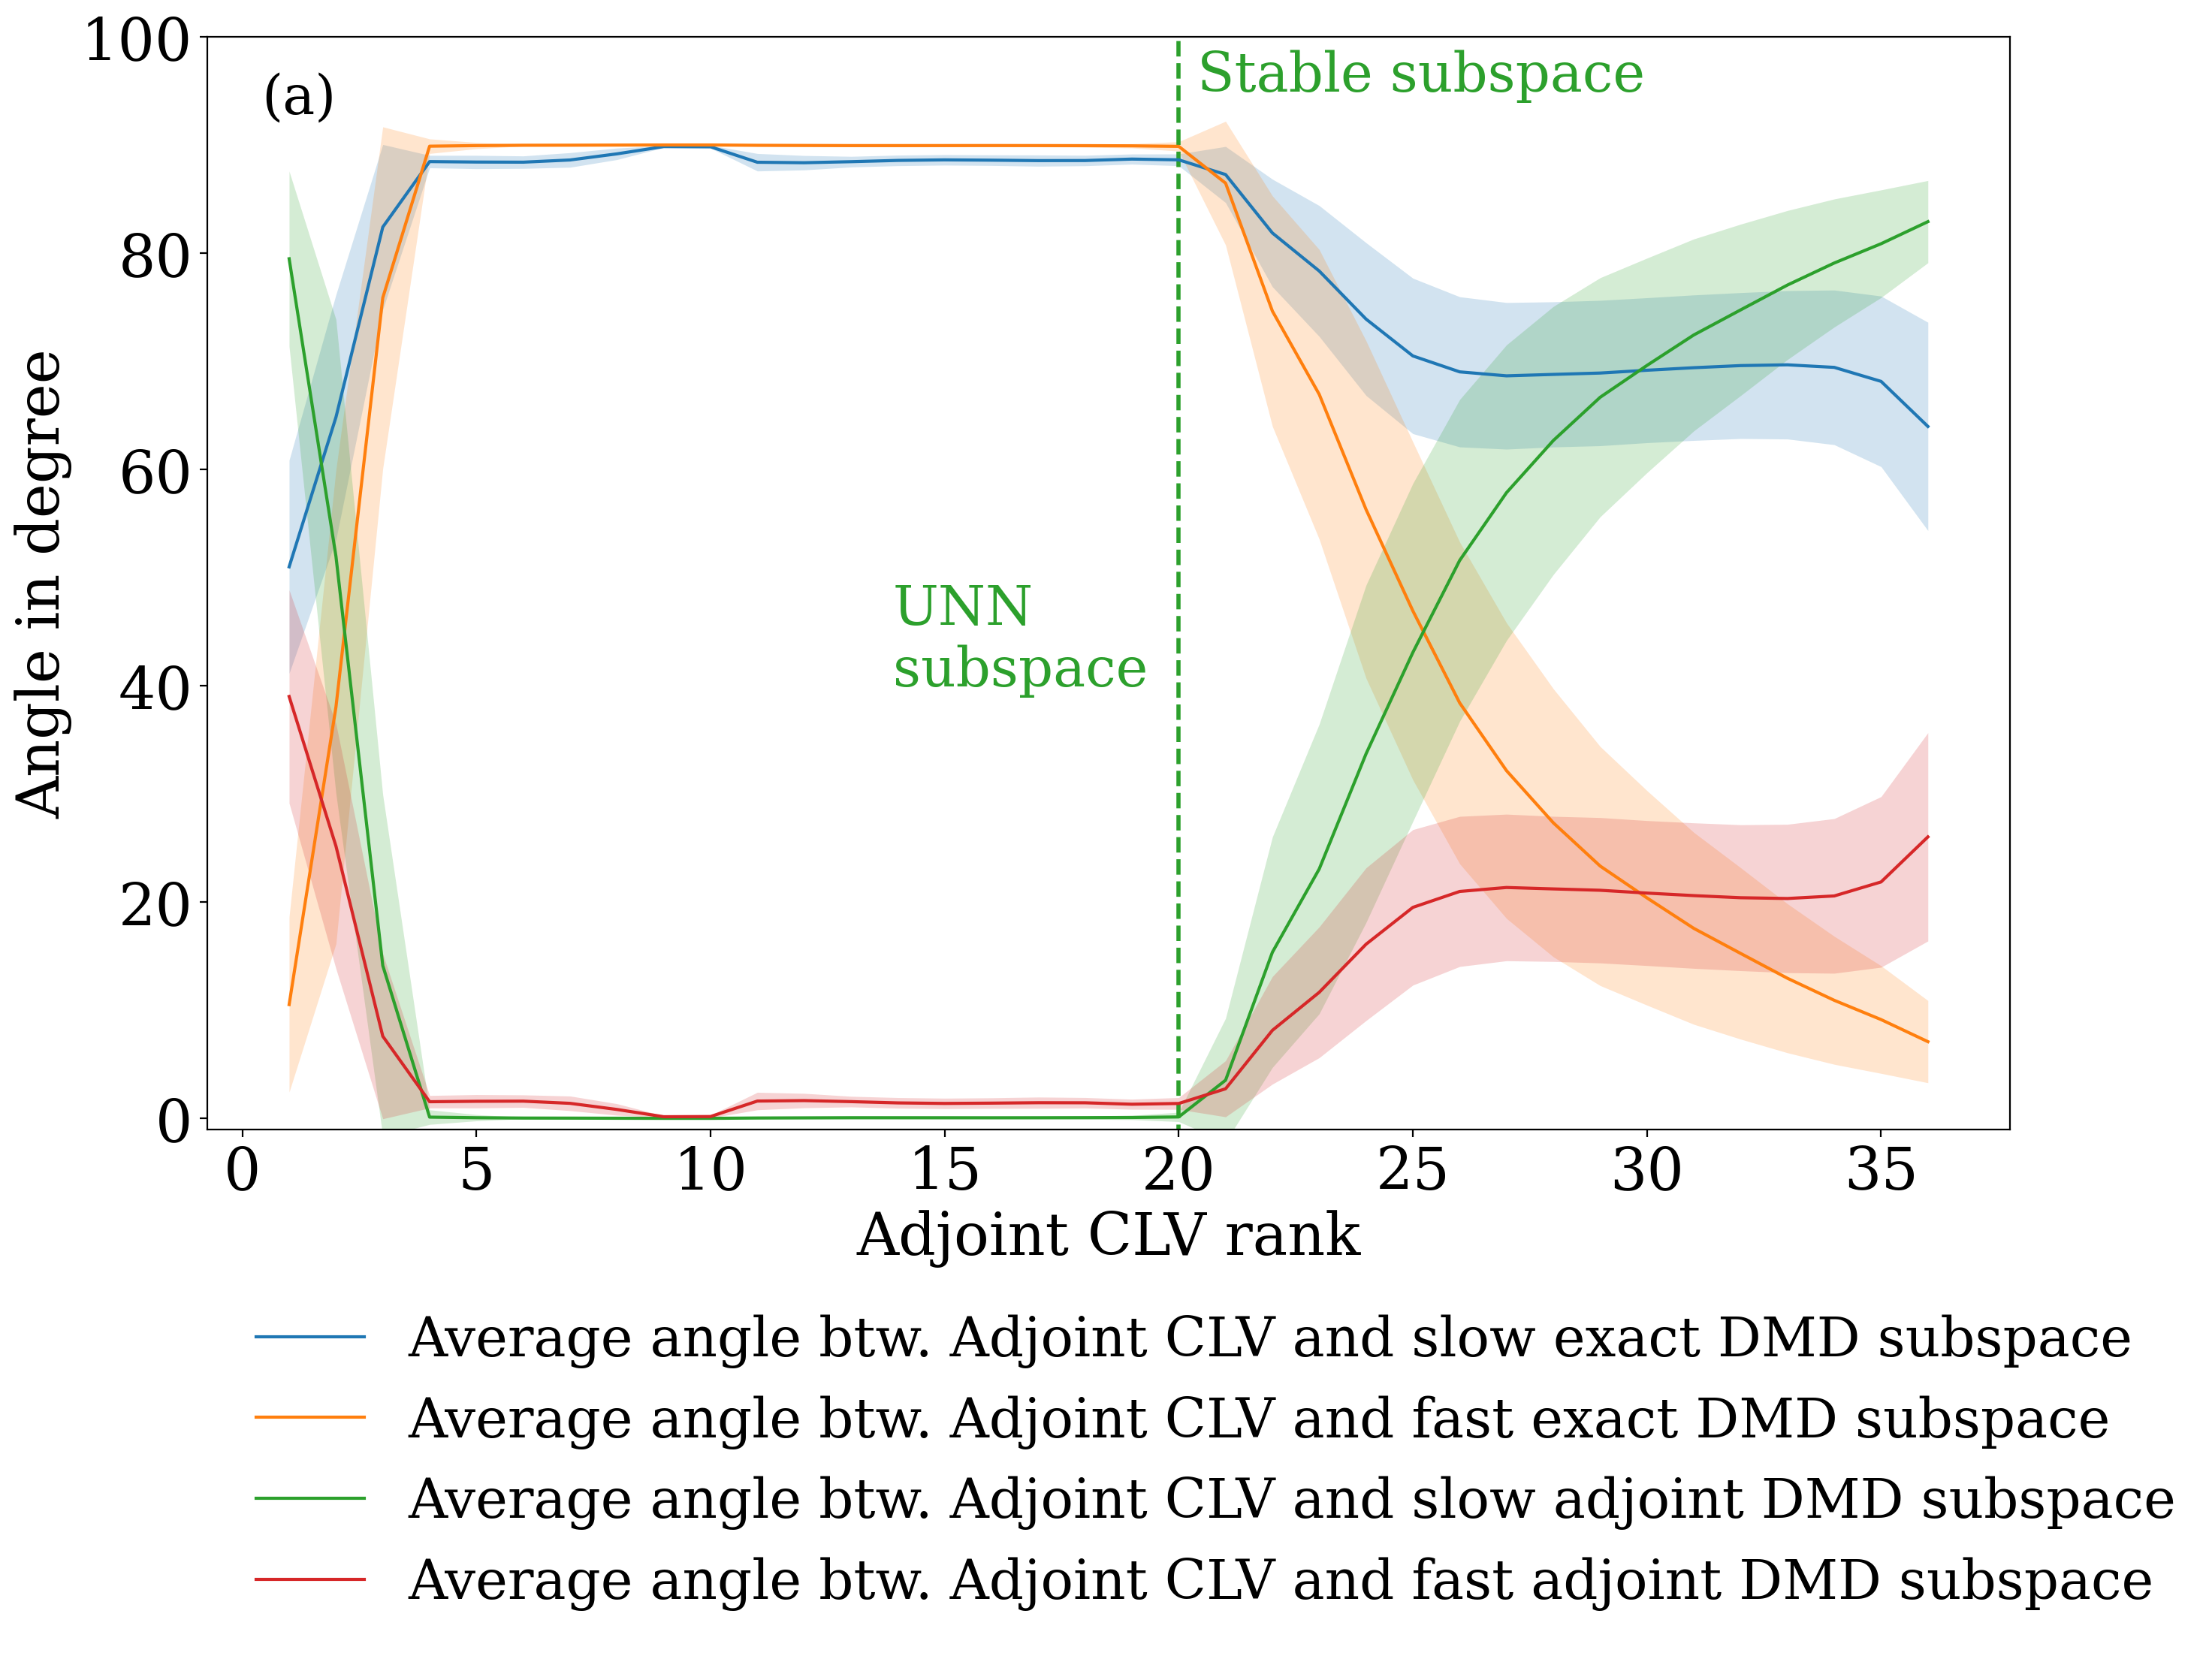

In [122]:
fig = plt.figure(figsize=(15,13.5))

gs = fig.add_gridspec(2, 1, height_ratios=(10,3.5), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

ax = fig.add_subplot(gs[0,0])

obj = list()

l, = ax.plot(range(1, len(angle_btw_aclvs_and_slow_dmds)+1), angle_btw_aclvs_and_slow_dmds, label='Average angle btw. Adjoint CLV and slow exact DMD subspace')
std_plot(range(1, len(angle_btw_aclvs_and_slow_dmds)+1), angle_btw_aclvs_and_slow_dmds, std_angle_btw_aclvs_and_slow_dmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_aclvs_and_fast_dmds)+1), angle_btw_aclvs_and_fast_dmds, label='Average angle btw. Adjoint CLV and fast exact DMD subspace')
std_plot(range(1, len(angle_btw_aclvs_and_fast_dmds)+1), angle_btw_aclvs_and_fast_dmds, std_angle_btw_aclvs_and_fast_dmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_aclvs_and_slow_addmds)+1), angle_btw_aclvs_and_slow_addmds, label='Average angle btw. Adjoint CLV and slow adjoint DMD subspace')
std_plot(range(1, len(angle_btw_aclvs_and_slow_addmds)+1), angle_btw_aclvs_and_slow_addmds, std_angle_btw_aclvs_and_slow_addmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_aclvs_and_fast_addmds)+1), angle_btw_aclvs_and_fast_addmds, label='Average angle btw. Adjoint CLV and fast adjoint DMD subspace')
std_plot(range(1, len(angle_btw_aclvs_and_fast_addmds)+1), angle_btw_aclvs_and_fast_addmds, std_angle_btw_aclvs_and_fast_addmds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)

# ax.legend(fontsize=16.)

ax.text(0.03, 0.93, '(a)', transform=ax.transAxes, fontsize=26.)
ax.set_ylim(-1,100)
ax.vlines(near_neutral_index[-1]+1,-2.,100., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 40., 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 95., 'Stable subspace', fontsize=26., color='tab:green')
ax.set_xlabel('Adjoint CLV rank')
ax.set_ylabel('Angle in degree');

ax = fig.add_subplot(gs[1,0])

ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.legend(handles=obj, frameon=False, fontsize=26., loc='lower left');

 
plt.savefig('./fig11a.pdf', bbox_inches='tight')

### Supplementary figure : Projecting the Adjoint CLVs on the PFMD

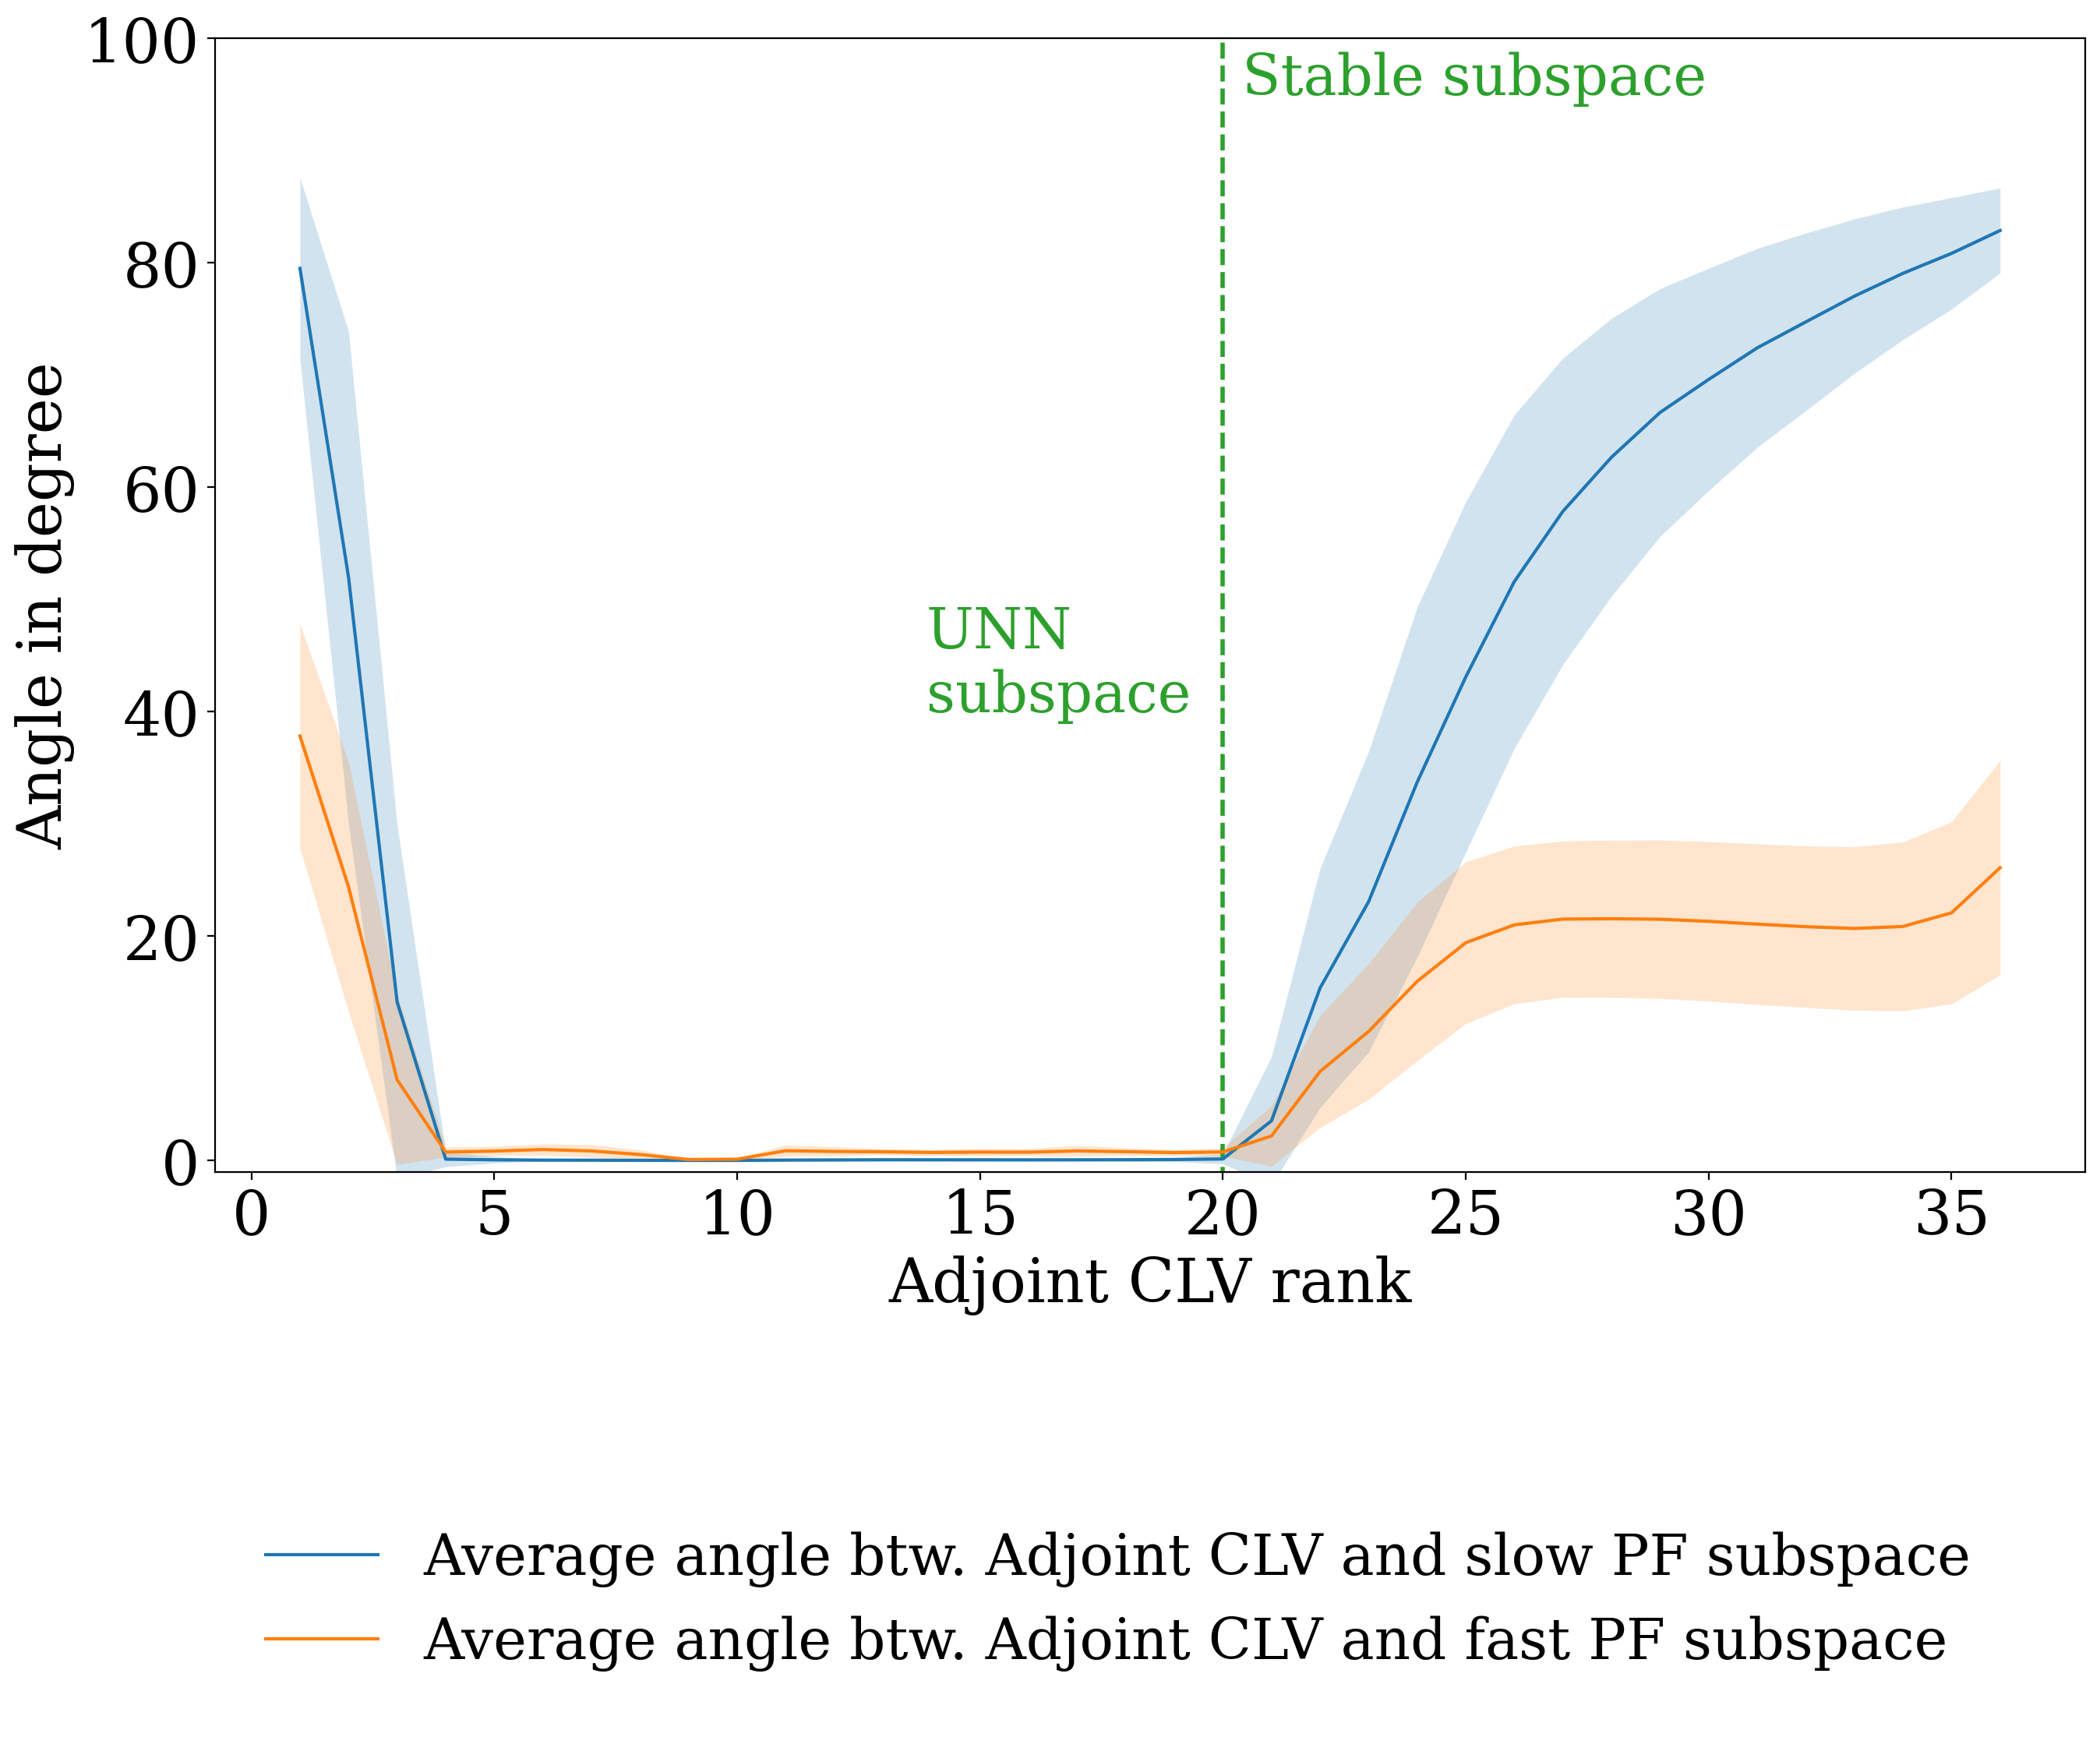

In [123]:
fig = plt.figure(figsize=(15,13.5))

gs = fig.add_gridspec(2, 1, height_ratios=(10,3.5), left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.2)

ax = fig.add_subplot(gs[0,0])

obj = list()

l, = ax.plot(range(1, len(angle_btw_aclvs_and_slow_pfds)+1), angle_btw_aclvs_and_slow_pfds, label='Average angle btw. Adjoint CLV and slow PF subspace')
std_plot(range(1, len(angle_btw_aclvs_and_slow_pfds)+1), angle_btw_aclvs_and_slow_pfds, std_angle_btw_aclvs_and_slow_pfds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)
l, = ax.plot(range(1, len(angle_btw_aclvs_and_fast_pfds)+1), angle_btw_aclvs_and_fast_pfds, label='Average angle btw. Adjoint CLV and fast PF subspace')
std_plot(range(1, len(angle_btw_aclvs_and_fast_pfds)+1), angle_btw_aclvs_and_fast_pfds, std_angle_btw_aclvs_and_fast_pfds, ax, color=l.get_color(), alpha=0.2, lw=0.)
obj.append(l)

# ax.legend(fontsize=16.)

# ax.text(0.03, 0.93, '(a)', transform=ax.transAxes, fontsize=26.)
ax.set_ylim(-1,100)
ax.vlines(near_neutral_index[-1]+1,-2.,100., colors='tab:green', linestyles='dashed', lw=2.)
ax.text(13.9, 40., 'UNN\nsubspace', fontsize=26., color='tab:green')
ax.text(20.4, 95., 'Stable subspace', fontsize=26., color='tab:green')

ax.set_xlabel('Adjoint CLV rank')
ax.set_ylabel('Angle in degree');

ax = fig.add_subplot(gs[1,0])

ax.set_frame_on(False)
ax.axes.get_yaxis().set_visible(False)
ax.axes.get_xaxis().set_visible(False)
ax.legend(handles=obj, frameon=False, fontsize=26., loc='lower left');

 
plt.savefig('./fig_supp_AdCLVvsPFMD_noLFV.pdf', bbox_inches='tight')

The end...